# Notebook for beat and glide model figures featuring knockouts of cell populations and strychnine

### Processing all the KO simulations to extract swimming properties and saving the dictionaries into .json files

In [ ]:
# Import pandas for data saving
import pandas as pd
import numpy as np
import json
from Analysis_tools import *

#this function adds NaN when applicable
def cure_array(tmp_):
    tmp__ = []
    for x in tmp_:
        if len(x) == 0:
            tmp__.append(np.nan)
        else:
            tmp__.append(x[0])
    return tmp__
#This function creates a dictionary containing various cross- and auto-correlation as well as swimming episode duration
# start and end based on muscle output in VLMuscle and VRMuscle
def BnG_pattern_analysis(Time, VLMuscle, VRMuscle):
    DT = 0.1
    nMuscle = len(VLMuscle)
    res_t_d = [(Xcorr(VLMuscle[i,:],VLMuscle[i-9,:])[0:int(150/DT)]).tolist() 
               for i in range(9, nMuscle)] # Time delay
    res_l_r = [(Xcorr(VLMuscle[i,:],VRMuscle[i,:])[0:int(150/DT)]).tolist() 
               for i in range(nMuscle)] # Left/Right cross correlogram
    res_a_c = [(Xcorr(VLMuscle[i,:],VLMuscle[i,:])[int(10/DT):int(150/DT)]).tolist()
               for i in range(nMuscle)] # auto-correlation removing 10 first ms (otherwise max is at 0 ms) and up to 150 ms
    Start, End, Duration = detect_event(VLMuscle, VRMuscle, Time, Threshold=.5)
    values_t_d = [Time[0:int(150/DT)][np.where(res==np.max(res))[0]] / 9. for res in res_t_d]
    values_t_d = cure_array(values_t_d)
    values_l_r = [ Time[0:int(150/DT)][np.where(res==np.max(res))[0]] for res in res_l_r ]
    values_l_r = cure_array(values_l_r)
    values_a_c = [ Time[int(10/DT):int(150/DT)][np.where(res==np.max(res))[0]] for res in res_a_c]
    values_a_c = cure_array(values_a_c)
    num_tail_beats, interbeat_intervals, start_times, beat_times = calc_tail_beat_freq(VRMuscle, VLMuscle, nmax = len(Time), 
                                                    dt = 0.1, lower_bound = -0.5, upper_bound = 0.5, delay = 1000) # 500)
    inst_freq = [1000/interbeat_intervals[i] if not np.isnan(interbeat_intervals[i]) else math.nan for i in range(0, len(interbeat_intervals))]

    if Start == 'No event detected':
        iei = 'No event detected'
    else:    
        iei = [Start[i+1] - End[i] for i in range(len(End)-1)]
    dict_res_sensitivity = {}
    dict_res_sensitivity['Ipsilateral delay'] = {'Cross-correlation curve delta 9 somites' : (Time.tolist(),res_t_d),
                                                     'Computed time delay per somite (ms)': values_t_d }
    dict_res_sensitivity['Left/Right alt. delay'] = {'Cross-correlation curve' : (Time.tolist(),res_l_r),
                                                     'Computed L/R time delay (ms)': values_l_r }
    dict_res_sensitivity['Tail beat delay'] = {'Auto-correlation curve (10-150 ms)' : (Time.tolist(),res_a_c),
                                                     'Computed tail beat time delay (ms)': values_a_c }
    dict_res_sensitivity['Events'] = {'Start times (ms)' : Start.tolist(),
                                      'End times (ms)': End.tolist(),
                                      'Duration (ms)': Duration.tolist(),
                                      'Inter-event intervals': iei
                                     }
    dict_res_sensitivity['Average frequency'] = {'Average frequency (Hz)': 1000/np.nanmean(interbeat_intervals),
                                                 'Instantaneous frequency (Hz)': inst_freq,
                                                 'Number of tail beats': num_tail_beats,
                                                 'Interbeat intervals (ms)': interbeat_intervals,
                                                 'Start times(ms)': start_times,
                                                 'Beat times(ms)': beat_times
                                                }

    return dict_res_sensitivity

# Build the analysis for V2a null
#First read the data file for the V2a null sim
read_data = pd.read_csv("Beat_and_Glide_V2a_KO.csv")
read_data

data_top = list(read_data.columns.values.tolist())
data_top

MN_index = []
dI6_index = [] 
V0v_index = []  
V2a_index = [] 
V1_index = []
Muscle_index = []

for i in range(0, len(data_top)):
    if (data_top[i].find('MN') != -1):
        MN_index.append(int(data_top[i][data_top[i].find('MN')+2:data_top[i].find('MN')+4]))
        nMN = max(MN_index) + 1
    if (data_top[i].find('dI6') != -1):
        dI6_index.append(int(data_top[i][data_top[i].find('dI6')+3:data_top[i].find('dI6')+5]))
        ndI6 = max(dI6_index) + 1
    if (data_top[i].find('V0v') != -1):
        V0v_index.append(int(data_top[i][data_top[i].find('V0v')+3:data_top[i].find('V0v')+5]))
        nV0v = max(V0v_index) + 1
    if (data_top[i].find('V2a') != -1):
        V2a_index.append(int(data_top[i][data_top[i].find('V2a')+3:data_top[i].find('V2a')+5]))
        nV2a = max(V2a_index) + 1
    if (data_top[i].find('V1') != -1):
        V1_index.append(int(data_top[i][data_top[i].find('V1')+2:data_top[i].find('V1')+4]))
        nV1 = max(V1_index) + 1
    if (data_top[i].find('Muscle') != -1):
        Muscle_index.append(int(data_top[i][data_top[i].find('Muscle')+6:data_top[i].find('Muscle')+8]))
        nMuscle = max(Muscle_index) + 1
        
read_sim = np.ascontiguousarray(read_data)
read_sim = np.transpose(read_sim)
read_sim
Time = read_sim[0]
next_start = 1
next_end = next_start + nMN
VLMN = read_sim[1:next_end]
next_start = next_end
next_end = next_start + nMN
VRMN = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + ndI6
VLdI6 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + ndI6
VRdI6 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV0v
VLV0v = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV0v
VRV0v = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV2a
VLV2a = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV2a
VRV2a = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV1
VLV1 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV1
VRV1 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nMuscle
VLMuscle = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nMuscle
VRMuscle = read_sim[next_start:next_end]
TIME_END = Time[-1]
TIME_END

results = dict()
Epoch=5000

#Build the dictionary and save into a .json file
all_results = BnG_pattern_analysis(Time, VLMuscle, VRMuscle)
analysis_file = "V2a_KO_all_results.json"
my_json = json.dumps(all_results)
f = open(analysis_file,"w")
f.write(my_json)
f.close()
for i in range(0,3):
    results[i] = BnG_pattern_analysis(Time[i*Epoch*10:(i+1)*Epoch*10], VLMuscle[:, i*Epoch*10:(i+1)*Epoch*10], VRMuscle[:, i*Epoch*10:(i+1)*Epoch*10])
    my_json = json.dumps(results[i])
    analysis_file = "V2a_KO_results_epoch_" + str(i) + ".json"
    f = open(analysis_file,"w")
    f.write(my_json)
    f.close()

# Build the analysis for V2a null
#First read the data file for the V2a null sim
read_data = pd.read_csv("Beat_and_Glide_V1_KO.csv")
read_data

data_top = list(read_data.columns.values.tolist())
data_top

MN_index = []
dI6_index = [] 
V0v_index = []  
V2a_index = [] 
V1_index = []
Muscle_index = []

for i in range(0, len(data_top)):
    if (data_top[i].find('MN') != -1):
        MN_index.append(int(data_top[i][data_top[i].find('MN')+2:data_top[i].find('MN')+4]))
        nMN = max(MN_index) + 1
    if (data_top[i].find('dI6') != -1):
        dI6_index.append(int(data_top[i][data_top[i].find('dI6')+3:data_top[i].find('dI6')+5]))
        ndI6 = max(dI6_index) + 1
    if (data_top[i].find('V0v') != -1):
        V0v_index.append(int(data_top[i][data_top[i].find('V0v')+3:data_top[i].find('V0v')+5]))
        nV0v = max(V0v_index) + 1
    if (data_top[i].find('V2a') != -1):
        V2a_index.append(int(data_top[i][data_top[i].find('V2a')+3:data_top[i].find('V2a')+5]))
        nV2a = max(V2a_index) + 1
    if (data_top[i].find('V1') != -1):
        V1_index.append(int(data_top[i][data_top[i].find('V1')+2:data_top[i].find('V1')+4]))
        nV1 = max(V1_index) + 1
    if (data_top[i].find('Muscle') != -1):
        Muscle_index.append(int(data_top[i][data_top[i].find('Muscle')+6:data_top[i].find('Muscle')+8]))
        nMuscle = max(Muscle_index) + 1
        
read_sim = np.ascontiguousarray(read_data)
read_sim = np.transpose(read_sim)
read_sim
Time = read_sim[0]
next_start = 1
next_end = next_start + nMN
VLMN = read_sim[1:next_end]
next_start = next_end
next_end = next_start + nMN
VRMN = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + ndI6
VLdI6 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + ndI6
VRdI6 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV0v
VLV0v = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV0v
VRV0v = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV2a
VLV2a = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV2a
VRV2a = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV1
VLV1 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV1
VRV1 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nMuscle
VLMuscle = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nMuscle
VRMuscle = read_sim[next_start:next_end]
TIME_END = Time[-1]
TIME_END

results = dict()
Epoch=5000

#Build the dictionary with the analysis of the V1 null simulation and put into a .json file
all_results = BnG_pattern_analysis(Time, VLMuscle, VRMuscle)
analysis_file = "V1_KO_all_results.json"
my_json = json.dumps(all_results)
f = open(analysis_file,"w")
f.write(my_json)
f.close()
for i in range(0,3):
    results[i] = BnG_pattern_analysis(Time[i*Epoch*10:(i+1)*Epoch*10], VLMuscle[:, i*Epoch*10:(i+1)*Epoch*10], VRMuscle[:, i*Epoch*10:(i+1)*Epoch*10])
    my_json = json.dumps(results[i])
    analysis_file = "V1_KO_results_epoch_" + str(i) + ".json"
    f = open(analysis_file,"w")
    f.write(my_json)
    f.close()

# Build the analysis for dI6 null
#First read the data file for the dI6 null sim
read_data = pd.read_csv("Beat_and_Glide_dI6_KO.csv")
read_data

data_top = list(read_data.columns.values.tolist())
data_top

MN_index = []
dI6_index = [] 
V0v_index = []  
V2a_index = [] 
V1_index = []
Muscle_index = []

for i in range(0, len(data_top)):
    if (data_top[i].find('MN') != -1):
        MN_index.append(int(data_top[i][data_top[i].find('MN')+2:data_top[i].find('MN')+4]))
        nMN = max(MN_index) + 1
    if (data_top[i].find('dI6') != -1):
        dI6_index.append(int(data_top[i][data_top[i].find('dI6')+3:data_top[i].find('dI6')+5]))
        ndI6 = max(dI6_index) + 1
    if (data_top[i].find('V0v') != -1):
        V0v_index.append(int(data_top[i][data_top[i].find('V0v')+3:data_top[i].find('V0v')+5]))
        nV0v = max(V0v_index) + 1
    if (data_top[i].find('V2a') != -1):
        V2a_index.append(int(data_top[i][data_top[i].find('V2a')+3:data_top[i].find('V2a')+5]))
        nV2a = max(V2a_index) + 1
    if (data_top[i].find('V1') != -1):
        V1_index.append(int(data_top[i][data_top[i].find('V1')+2:data_top[i].find('V1')+4]))
        nV1 = max(V1_index) + 1
    if (data_top[i].find('Muscle') != -1):
        Muscle_index.append(int(data_top[i][data_top[i].find('Muscle')+6:data_top[i].find('Muscle')+8]))
        nMuscle = max(Muscle_index) + 1
        
read_sim = np.ascontiguousarray(read_data)
read_sim = np.transpose(read_sim)
read_sim
Time = read_sim[0]
next_start = 1
next_end = next_start + nMN
VLMN = read_sim[1:next_end]
next_start = next_end
next_end = next_start + nMN
VRMN = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + ndI6
VLdI6 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + ndI6
VRdI6 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV0v
VLV0v = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV0v
VRV0v = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV2a
VLV2a = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV2a
VRV2a = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV1
VLV1 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV1
VRV1 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nMuscle
VLMuscle = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nMuscle
VRMuscle = read_sim[next_start:next_end]
TIME_END = Time[-1]
TIME_END

results = dict()
Epoch=5000
#Build the dictionary with the analysis of the dI6 null simulation and output into a .json file
all_results = BnG_pattern_analysis(Time, VLMuscle, VRMuscle)
analysis_file = "dI6_KO_all_results.json"
my_json = json.dumps(all_results)
f = open(analysis_file,"w")
f.write(my_json)
f.close()
for i in range(0,3):
    results[i] = BnG_pattern_analysis(Time[i*Epoch*10:(i+1)*Epoch*10], VLMuscle[:, i*Epoch*10:(i+1)*Epoch*10], VRMuscle[:, i*Epoch*10:(i+1)*Epoch*10])
    my_json = json.dumps(results[i])
    analysis_file = "dI6_KO_results_epoch_" + str(i) + ".json"
    f = open(analysis_file,"w")
    f.write(my_json)
    f.close()

# Build the analysis for V0v null
#First read the data file for the V0v null sim
read_data = pd.read_csv("Beat_and_Glide_V0v_KO.csv")
read_data

data_top = list(read_data.columns.values.tolist())
data_top

MN_index = []
dI6_index = [] 
V0v_index = []  
V2a_index = [] 
V1_index = []
Muscle_index = []

for i in range(0, len(data_top)):
    if (data_top[i].find('MN') != -1):
        MN_index.append(int(data_top[i][data_top[i].find('MN')+2:data_top[i].find('MN')+4]))
        nMN = max(MN_index) + 1
    if (data_top[i].find('dI6') != -1):
        dI6_index.append(int(data_top[i][data_top[i].find('dI6')+3:data_top[i].find('dI6')+5]))
        ndI6 = max(dI6_index) + 1
    if (data_top[i].find('V0v') != -1):
        V0v_index.append(int(data_top[i][data_top[i].find('V0v')+3:data_top[i].find('V0v')+5]))
        nV0v = max(V0v_index) + 1
    if (data_top[i].find('V2a') != -1):
        V2a_index.append(int(data_top[i][data_top[i].find('V2a')+3:data_top[i].find('V2a')+5]))
        nV2a = max(V2a_index) + 1
    if (data_top[i].find('V1') != -1):
        V1_index.append(int(data_top[i][data_top[i].find('V1')+2:data_top[i].find('V1')+4]))
        nV1 = max(V1_index) + 1
    if (data_top[i].find('Muscle') != -1):
        Muscle_index.append(int(data_top[i][data_top[i].find('Muscle')+6:data_top[i].find('Muscle')+8]))
        nMuscle = max(Muscle_index) + 1
        
read_sim = np.ascontiguousarray(read_data)
read_sim = np.transpose(read_sim)
read_sim
Time = read_sim[0]
next_start = 1
next_end = next_start + nMN
VLMN = read_sim[1:next_end]
next_start = next_end
next_end = next_start + nMN
VRMN = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + ndI6
VLdI6 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + ndI6
VRdI6 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV0v
VLV0v = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV0v
VRV0v = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV2a
VLV2a = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV2a
VRV2a = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV1
VLV1 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV1
VRV1 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nMuscle
VLMuscle = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nMuscle
VRMuscle = read_sim[next_start:next_end]
TIME_END = Time[-1]
TIME_END

results = dict()
Epoch=5000
#Build the dictionary for the V0v null simulation and place in a .json file
all_results = BnG_pattern_analysis(Time, VLMuscle, VRMuscle)
analysis_file = "V0v_KO_all_results.json"
my_json = json.dumps(all_results)
f = open(analysis_file,"w")
f.write(my_json)
f.close()

for i in range(0,3):
    results[i] = BnG_pattern_analysis(Time[i*Epoch*10:(i+1)*Epoch*10], VLMuscle[:, i*Epoch*10:(i+1)*Epoch*10], VRMuscle[:, i*Epoch*10:(i+1)*Epoch*10])
    my_json = json.dumps(results[i])
    analysis_file = "V0v_KO_results_epoch_" + str(i) + ".json"
    f = open(analysis_file,"w")
    f.write(my_json)
    f.close()




### Figure 5A-F - V2a null

C:\Users\tuanm\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\tuanm\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\tuanm\anaconda3\lib\site-packages\numpy\core\_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\tuanm\anaconda3\lib\site-packages\numpy\core\_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\tuanm\anaconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\tuanm\anaconda3\lib\site-packages\ipykernel_launcher.py:328: RuntimeWarning: Mean of empty slice
C:\Users\tuanm\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: D

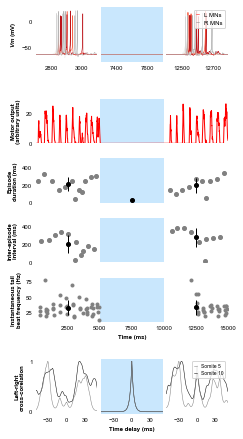

In [1]:
# Import pandas for data saving
import pandas as pd
import numpy as np
import json
from pylab import *
from Analysis_tools import *

results=[]
#Duration of each epoch during V2a null simulation
Epoch = 5000

#open up .json file for each eopoch
for i in range(0,3):
    names = "V2a_KO_results_epoch_" + str(i) + ".json"
    f = open(names,)
    results.append(json.load(f))

names = "V2a_KO_all_results.json"
g = open(names,)
all_results = json.load(g)

#Open simulation file for V2a null simulation
read_data = pd.read_csv("Beat_and_Glide_V2a_KO.csv")
read_data

data_top = list(read_data.columns.values.tolist())
data_top

MN_index = []
dI6_index = [] 
V0v_index = []  
V2a_index = [] 
V1_index = []
Muscle_index = []

for i in range(0, len(data_top)):
    if (data_top[i].find('MN') != -1):
        MN_index.append(int(data_top[i][data_top[i].find('MN')+2:data_top[i].find('MN')+4]))
        nMN = max(MN_index) + 1
    if (data_top[i].find('dI6') != -1):
        dI6_index.append(int(data_top[i][data_top[i].find('dI6')+3:data_top[i].find('dI6')+5]))
        ndI6 = max(dI6_index) + 1
    if (data_top[i].find('V0v') != -1):
        V0v_index.append(int(data_top[i][data_top[i].find('V0v')+3:data_top[i].find('V0v')+5]))
        nV0v = max(V0v_index) + 1
    if (data_top[i].find('V2a') != -1):
        V2a_index.append(int(data_top[i][data_top[i].find('V2a')+3:data_top[i].find('V2a')+5]))
        nV2a = max(V2a_index) + 1
    if (data_top[i].find('V1') != -1):
        V1_index.append(int(data_top[i][data_top[i].find('V1')+2:data_top[i].find('V1')+4]))
        nV1 = max(V1_index) + 1
    if (data_top[i].find('Muscle') != -1):
        Muscle_index.append(int(data_top[i][data_top[i].find('Muscle')+6:data_top[i].find('Muscle')+8]))
        nMuscle = max(Muscle_index) + 1
        
read_sim = np.ascontiguousarray(read_data)
read_sim = np.transpose(read_sim)
read_sim
Time = read_sim[0]
next_start = 1
next_end = next_start + nMN
VLMN = read_sim[1:next_end]
next_start = next_end
next_end = next_start + nMN
VRMN = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + ndI6
VLdI6 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + ndI6
VRdI6 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV0v
VLV0v = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV0v
VRV0v = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV2a
VLV2a = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV2a
VRV2a = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV1
VLV1 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV1
VRV1 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nMuscle
VLMuscle = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nMuscle
VRMuscle = read_sim[next_start:next_end]
TIME_END = Time[-1]
TIME_END

#List of MN traces to plot
list_MNs = [int(nMN*i/4) for i in range(1,4)] #Plot 25th, 50th, and 75th neuron on rostrocaudal axis

#Declare figure and subplots
figKO = plt.figure(constrained_layout=False, figsize=(3.6, 7.5))

widths = [12, 12, 12, 1]
heights = [2.5, 0.3, 2, 2, 2, 2, 0.3, 2.5]
gs = figKO.add_gridspec(nrows=8, ncols=4, width_ratios=widths, height_ratios=heights)

dt = 0.1

#FIRST, GRAPH VOLTAGE TRACES DURING EACH EPOCH

fKO_ax0 = figKO.add_subplot(gs[0, 0])
fKO_ax1 = figKO.add_subplot(gs[0, 1])
fKO_ax2 = figKO.add_subplot(gs[0, 2])

#declare color mpas
cmapBlue = matplotlib.cm.get_cmap('Blues')
cmapRed = matplotlib.cm.get_cmap('Reds')
cmapGreen = matplotlib.cm.get_cmap('Greens')
cmapRedPurple = matplotlib.cm.get_cmap('RdPu')
cmapGrey = matplotlib.cm.get_cmap('Greys')
cmapBrown = matplotlib.cm.get_cmap('YlOrBr')
cmapBrightGreen = matplotlib.cm.get_cmap('hsv') #in the range 0.2 to 0.4
    
#declare line length and width
LINELENGTH = 0.5
LINEWIDTH = 0.5

plt.rc('lines', linewidth=LINEWIDTH) 

# Change default font to Arial
matplotlib.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"

rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.bf'] = 'Arial:italic:bold'

#font size
SMALL_SIZE = 6

FONT_STYLE = 'bold'

MARKER_SIZE = 4

# plotting motoneuron traces for epoch 1
for k in list_MNs:
    lines_left, = fKO_ax0.plot(Time, VLMN[k,:], c=cmapRed((k+1)/nMN),linestyle='-') # adding a color gradient, lighter color -> rostrally located
    lines_right, = fKO_ax0.plot(Time, VRMN[k,:], c=cmapGrey((k+1)/nMN/2), linestyle='-')

#y-axis limits
lower_y = -80
upper_y = 30

fKO_ax0.set_ylabel(r"$\mathbf{Vm}$" + " (mV)", fontsize= SMALL_SIZE, fontweight=FONT_STYLE) #y-axis title
fKO_ax0.set_ylim([lower_y, upper_y]) #y-axis limits
#Remove borders
fKO_ax0.spines['top'].set_visible(False)
fKO_ax0.spines['right'].set_visible(False)
fKO_ax0.spines['bottom'].set_visible(False)
fKO_ax0.spines['left'].set_visible(False)
#Tick parameters
fKO_ax0.tick_params(axis='both', which='both', length=0)
fKO_ax0.set_xticks([2800, 3000])
fKO_ax0.set_yticks([i*50 + -50 for i in range(0,2)])
for item in (fKO_ax0.get_xticklabels() + fKO_ax0.get_yticklabels()):
    item.set_fontsize(SMALL_SIZE)
fKO_ax0.set_xlim([2700,  3100]) #x-axis limit for epoch 1

# plotting motoneuron traces for epoch 2
for k in list_MNs:
    lines_left, = fKO_ax1.plot(Time, VLMN[k,:], c=cmapRed((k+1)/nMN),linestyle='-') # adding a color gradient, lighter color -> rostrally located
    lines_right, = fKO_ax1.plot(Time, VRMN[k,:], c=cmapGrey((k+1)/nMN/2), linestyle='-')

fKO_ax1.set_ylim([lower_y, upper_y])
fKO_ax1.spines['top'].set_visible(False)
fKO_ax1.spines['right'].set_visible(False)
fKO_ax1.spines['bottom'].set_visible(False)
fKO_ax1.spines['left'].set_visible(False)
fKO_ax1.tick_params(axis='both', which='both', length=0)
fKO_ax1.set_xticks([7400,7600])
for item in (fKO_ax1.get_xticklabels()):
    item.set_fontsize(SMALL_SIZE)
fKO_ax1.set_xlim([7300,  7700]) #x-axis limit for epoch 2
fKO_ax1.set_yticks([])
fKO_ax1.axvspan(5000, 10000, facecolor='xkcd:light blue', alpha=0.5) #add a blue background for epoch 2

# plotting motoneuron traces for epoch 3
for k in list_MNs:
    lines_left, = fKO_ax2.plot(Time, VLMN[k,:], c=cmapRed((k+1)/nMN),linestyle='-') # adding a color gradient, lighter color -> rostrally located
    lines_right, = fKO_ax2.plot(Time, VRMN[k,:], c=cmapGrey((k+1)/nMN/2), linestyle='-')

fKO_ax2.set_ylim([lower_y, upper_y])
fKO_ax2.spines['top'].set_visible(False)
fKO_ax2.spines['right'].set_visible(False)
fKO_ax2.spines['bottom'].set_visible(False)
fKO_ax2.spines['left'].set_visible(False)
fKO_ax2.tick_params(axis='both', which='both', length=0)
fKO_ax2.set_xticks([12500, 12700])
for item in (fKO_ax2.get_xticklabels()):
    item.set_fontsize(SMALL_SIZE)
fKO_ax2.set_xlim([12400,  12800]) #x-axis limit for epoch 3
fKO_ax2.set_yticks([])

# plotting motoneuron traces
for k in list_MNs:
    lines_left, = fKO_ax2.plot(Time, VLMN[k,:], c=cmapRed((k+1)/nMN),linestyle='-') # adding a color gradient, lighter color -> rostrally located
    lines_right, = fKO_ax2.plot(Time, VRMN[k,:], c=cmapGrey((k+1)/nMN/2), linestyle='-')
leg=fKO_ax2.legend(handles=[lines_left, lines_right], labels=['L MNs','R MNs'], loc='upper right', handlelength=LINELENGTH, fontsize=SMALL_SIZE)
leg.legendHandles[0].set_color('red')
leg.legendHandles[1].set_color('grey')

## PLOT MOTOR OUTPUT
#Declare subplot
fKO_ax3 = figKO.add_subplot(gs[2, 0:-1])

#add left and right muscle output
X = np.sum(VLMuscle, axis=0) + np.sum(VRMuscle, axis=0)
X = smooth(X, 500) #convolve with a step 50 ms wide

fKO_ax3.plot(Time, X, c='red', linewidth = 1)
fKO_ax3.set_ylabel('Motor output\n' + '(arbitrary units)', fontsize=SMALL_SIZE-1, fontweight = FONT_STYLE) #y-axis title
fKO_ax3.axvspan(5000, 10000, facecolor='xkcd:light blue', alpha=0.5) #add a blue stripe between t=5000 and 1000
fKO_ax3.set_xlim(0,15000) #x-axis limit
fKO_ax3.set_ylim(0,30)    #y-axis limit

#Remove borders
fKO_ax3.spines['top'].set_visible(False)
fKO_ax3.spines['right'].set_visible(False)
fKO_ax3.spines['bottom'].set_visible(False)
fKO_ax3.spines['left'].set_visible(False)        
fKO_ax3.tick_params(axis='both', which='both', length=0)
fKO_ax3.set_xticks([])

for item in ([fKO_ax3.title, fKO_ax3.xaxis.label, fKO_ax3.yaxis.label] +
         fKO_ax3.get_xticklabels() + fKO_ax3.get_yticklabels()):
    item.set_fontsize(SMALL_SIZE)

## NOW PLOT EPISODE DURATION AND INTER-EPISODE DURATION
    
# Declare subplots for episode duration and inter-episode duration
fKO_ax4 = figKO.add_subplot(gs[3, 0:-1])
fKO_ax5 = figKO.add_subplot(gs[4, 0:-1])

#remove borders
fKO_ax4.spines['top'].set_visible(False)
fKO_ax4.spines['right'].set_visible(False)
fKO_ax4.spines['bottom'].set_visible(False)
fKO_ax4.spines['left'].set_visible(False)        
fKO_ax4.tick_params(axis='both', which='both', length=0) #tick parameters
#Set fonts
for item in ([fKO_ax4.title, fKO_ax4.xaxis.label, fKO_ax4.yaxis.label] +
         fKO_ax4.get_xticklabels() + fKO_ax4.get_yticklabels()):
    item.set_fontsize(SMALL_SIZE)

#remove borders
fKO_ax5.spines['top'].set_visible(False)
fKO_ax5.spines['right'].set_visible(False)
fKO_ax5.spines['bottom'].set_visible(False)
fKO_ax5.spines['left'].set_visible(False)        
fKO_ax5.tick_params(axis='both', which='both', length=0) #tick parameters
#Set fonts
for item in ([fKO_ax5.title, fKO_ax5.xaxis.label, fKO_ax5.yaxis.label] +
         fKO_ax5.get_xticklabels() + fKO_ax5.get_yticklabels()):
    item.set_fontsize(SMALL_SIZE)
    
# Set ticks and limts
fKO_ax4.set_xticks([])
fKO_ax5.set_xticks([])
fKO_ax4.set_yticks([i*200 for i in range(0,5)])
fKO_ax5.set_yticks([i*200 for i in range(0,5)])

fKO_ax4.set_xlim([0, TIME_END])
fKO_ax5.set_xlim([0, TIME_END])

fKO_ax4.set_ylim([0, 500])
fKO_ax5.set_ylim([0, 500])

res = all_results['Events']['Duration (ms)']
time_start = all_results['Events']['Start times (ms)']

fKO_ax4.axvspan(5000, 10000, facecolor='xkcd:light blue', alpha=0.5) #blue background between t =5000 and 10000

#calculate mean and standard deviation of episode durations
dur_temp = [results[i]['Events']['Duration (ms)'] for i in range(0,3)]
mean_dur = [np.mean(dur_temp[i]) for i in range (0,3)]
std_dur = [np.std(dur_temp[i]) for i in range (0,3)]
x_mean_dur = [2500, 7500, 12500]
            
fKO_ax4.errorbar(x_mean_dur, mean_dur, yerr=std_dur, linestyle='None', color = 'black', marker='o', markersize=MARKER_SIZE, linewidth = 1.0, zorder=2)
            
fKO_ax4.plot(time_start, res, 'o', color = 'gray', markersize=MARKER_SIZE, zorder=1)
fKO_ax4.set_ylabel('Episode\n' + 'duration (ms)', fontsize=SMALL_SIZE, fontweight = FONT_STYLE)

res = all_results['Events']['Inter-event intervals']
time_start = all_results['Events']['End times (ms)'][:-1]

fKO_ax5.axvspan(5000, 10000, facecolor='xkcd:light blue', alpha=0.5)

#calculate mean and standard deviation of interepisode intervals
dur_temp = [results[i]['Events']['Inter-event intervals'] for i in range(0,3)]
mean_dur = [np.mean(dur_temp[i]) for i in range (0,3)]
std_dur = [np.std(dur_temp[i]) for i in range (0,3)]
x_mean_dur = [2500, 7500, 12500]
            
fKO_ax5.errorbar(x_mean_dur, mean_dur, yerr=std_dur, linestyle='None', color = 'black', marker='o', markersize=MARKER_SIZE, linewidth = 1.0,  zorder=2)

fKO_ax5.plot(time_start, res, 'o', color = 'gray', markersize=MARKER_SIZE, zorder=1)
fKO_ax5.set_ylabel('Inter-episode\n' + 'interval (ms)', fontsize=SMALL_SIZE, fontweight = FONT_STYLE)


### Instantaneous frequency
#Calculate instantaneous tail beat frequency and plot
num_tail_beats, interbeat_intervals, start_times, beat_times = calc_tail_beat_freq(VRMuscle, VLMuscle, nmax = len(Time), 
                                                        dt = 0.1, lower_bound = -0.5, upper_bound = 0.5, delay = 500)

fKO_ax6 = figKO.add_subplot(gs[5, 0:-1])
fKO_ax6.set_xlabel('Time (ms)', fontsize=SMALL_SIZE, fontweight = FONT_STYLE)

fKO_ax6.spines['top'].set_visible(False)
fKO_ax6.spines['right'].set_visible(False)
fKO_ax6.spines['bottom'].set_visible(False)
fKO_ax6.spines['left'].set_visible(False)        
fKO_ax6.tick_params(axis='both', which='both', length=0)

freq_temp = [results[i]['Average frequency']['Instantaneous frequency (Hz)'] for i in range(0,3)]
mean_freq = [np.nanmean(freq_temp[i]) for i in range (0,3)]
std_freq = [np.nanstd(freq_temp[i]) for i in range (0,3)]
x_mean_freq = [2500, 7500, 12500]

res = all_results['Average frequency']['Instantaneous frequency (Hz)']
time_start = all_results['Average frequency']['Beat times(ms)']

fKO_ax6.plot(time_start, res, 'o', color = 'gray', markersize=MARKER_SIZE-1, zorder=1)
fKO_ax6.set_ylabel('Instantaneous tail\n' + 'beat frequency (Hz)', fontsize=SMALL_SIZE-1, fontweight = FONT_STYLE)

for item in ([fKO_ax6.title, fKO_ax6.xaxis.label, fKO_ax6.yaxis.label] +
         fKO_ax6.get_xticklabels() + fKO_ax6.get_yticklabels()):
    item.set_fontsize(SMALL_SIZE)

fKO_ax6.set_xlim([0, TIME_END])

fKO_ax6.set_xticks([i*2500 for i in range(1,7)])

fKO_ax6.axvspan(5000, 10000, facecolor='xkcd:light blue', alpha=0.5)
fKO_ax6.set_xlabel('Time (ms)', fontsize=SMALL_SIZE, fontweight = FONT_STYLE)
            
fKO_ax6.errorbar(x_mean_freq, mean_freq, yerr=std_freq, linestyle='None', color = 'black', marker='o', markersize=MARKER_SIZE, linewidth = 1.0,  zorder=2)

# Plot left-right cross-correlation at somites 5 and 10
Duration_of_condition=5000
for i in range(0,3):
    Somite_index = 9
    res10 = Xcorr_LR(VLMuscle[Somite_index,Duration_of_condition*10*i:Duration_of_condition*10*(i+1)],VRMuscle[Somite_index,Duration_of_condition*10*i:Duration_of_condition*10*(i+1)])
    Somite_index = 4
    res5 = Xcorr_LR(VLMuscle[Somite_index,Duration_of_condition*10*i:Duration_of_condition*10*(i+1)],VRMuscle[Somite_index,Duration_of_condition*10*i:Duration_of_condition*10*(i+1)])

    
    fKO_LR = figKO.add_subplot(gs[-1, i])
    
    right_side = fKO_LR.spines["right"]
    top_side = fKO_LR.spines["top"]
    right_side.set_visible(False)
    top_side.set_visible(False)

    New_time = Time[0:Duration_of_condition*10].tolist()+(-Time[0:Duration_of_condition*10]).tolist()
    order = np.argsort(New_time)
    New_time= np.asarray(New_time)[order]

    line_somite10, = fKO_LR.plot(New_time[1:Duration_of_condition*20], res10, '-k',  c='black')
    line_somite5, =fKO_LR.plot(New_time[1:Duration_of_condition*20], res5, '-k', c='grey')
    
    if i == 2:
        leg_LR=fKO_LR.legend(handles=[line_somite5, line_somite10], labels=['Somite 5','Somite 10'], loc='upper right', handlelength=LINELENGTH, fontsize = SMALL_SIZE-1)
        leg_LR.legendHandles[0].set_color('grey')
        leg_LR.legendHandles[1].set_color('black')

    fKO_LR.set_xlim([-50,50])

    #remove borders
    fKO_LR.spines['top'].set_visible(False)
    fKO_LR.spines['right'].set_visible(False)
    fKO_LR.spines['bottom'].set_visible(False)
    fKO_LR.spines['left'].set_visible(False)
    fKO_LR.tick_params(axis='both', which='both', length=0)
    for item in ([fKO_LR.title, fKO_LR.xaxis.label, fKO_LR.yaxis.label] +
             fKO_LR.get_xticklabels() + fKO_LR.get_yticklabels()):
        item.set_fontsize(SMALL_SIZE)
    fKO_LR.set_xticks([-30,0,30])
    if i > 0:
        fKO_LR.set_yticks([])
    if i == 0:
        fKO_LR.set_ylabel('Left-right\n' + 'cross-corelation', fontsize = SMALL_SIZE, fontweight = FONT_STYLE)
        
    if i == 1:
        fKO_LR.set_xlabel('Time delay (ms)', fontsize = SMALL_SIZE, fontweight = FONT_STYLE)
        fKO_LR.axvspan(-50, 50, facecolor='xkcd:light blue', alpha=0.5)

plt.subplots_adjust(hspace=0.4, wspace=0.075)
plt.savefig('V2a_KO.png', dpi=1000)
plt.show()

### Figure 5 figure supplement 1A-E - membrane potential during V2a null

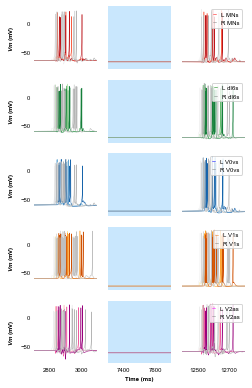

In [3]:
# Import pandas for data saving
import pandas as pd
import numpy as np
from pylab import *
from Analysis_tools import *

# Read data from V2a null simulations
read_data = pd.read_csv("Beat_and_Glide_V2a_KO.csv")
read_data

read_sim = np.ascontiguousarray(read_data)
read_sim = np.transpose(read_sim)
read_sim
Time = read_sim[0]
next_start = 1
next_end = next_start + nMN
VLMN = read_sim[1:next_end]
next_start = next_end
next_end = next_start + nMN
VRMN = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + ndI6
VLdI6 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + ndI6
VRdI6 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV0v
VLV0v = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV0v
VRV0v = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV2a
VLV2a = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV2a
VRV2a = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV1
VLV1 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV1
VRV1 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nMuscle
VLMuscle = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nMuscle
VRMuscle = read_sim[next_start:next_end]
TIME_END = Time[-1]
TIME_END

#list cell traces to plot
list_MNs = [int(nMN*i/4) for i in range(1,4)] #Plot 25th, 50th, and 75th neuron on rostrocaudal axis
list_dI6s = [int(ndI6*i/4) for i in range(1,4)]
list_V0vs = [int(nV0v*i/4) for i in range(1,4)] #Plot 25th, 50th, and 75th neuron on rostrocaudal axis
list_V2as = [int(nV2a*i/4) for i in range(1,4)] #Plot 25th, 50th, and 75th neuron on rostrocaudal axis
list_V1s = [int(nV1*i/4) - 1 for i in range(1,4) if 0 < int(nMN*i/4) - 1 < nV1] #Plot 25th, 50th, and 75th neuron on rostrocaudal axis

#list_dI6s = [int(nMN*i/4) for i in range(1,4) if int(nMN*i/4) < ndI6]
#list_V0vs = [int(nMN*i/4) for i in range(1,4) if int(nMN*i/4) < nV0v] #Plot 25th, 50th, and 75th neuron on rostrocaudal axis
#list_V2as = [int(nMN*i/4) - 2 for i in range(1,4) if 0 < int(nMN*i/4) - 2 < nV2a] #Plot 25th, 50th, and 75th neuron on rostrocaudal axis
#list_V1s = [int(nMN*i/4) - 4 for i in range(1,4) if 0 < int(nMN*i/4) - 4 < nV1] #Plot 25th, 50th, and 75th neuron on rostrocaudal axis

#color maps
cmapBlue = matplotlib.cm.get_cmap('Blues')
cmapRed = matplotlib.cm.get_cmap('Reds')
cmapGreen = matplotlib.cm.get_cmap('Greens')
cmapRedPurple = matplotlib.cm.get_cmap('RdPu')
cmapGrey = matplotlib.cm.get_cmap('Greys')
cmapBrown = matplotlib.cm.get_cmap('YlOrBr')
cmapYellow = matplotlib.cm.get_cmap('YlOrBr')
cmapBrightGreen = matplotlib.cm.get_cmap('hsv') #in the range 0.2 to 0.4

#declare figure
fig_KO, ax = plt.subplots(5, 3, figsize=(3.6, 5.5))

LINELENGTH = 0.5
LINEWIDTH = 0.5

# Change default font to Arial
matplotlib.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"

rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.bf'] = 'Arial:italic:bold'

plt.rc('lines', linewidth=LINEWIDTH) 

#font size and style
SMALL_SIZE = 6

FONT_STYLE = 'bold'

#declare x-axis limits for the three epochs
x_starts = [2700, 7300, 12400]
x_ends = [3100, 7700, 12800]

for j in range(0, 3): #cycle through three epochs
    # plotting motoneuron traces
    for k in list_MNs: #plot MN traces
        lines_left, = ax[0,j].plot(Time, VLMN[k,:], c=cmapRed((k+1)/nMN),linestyle='-') # adding a color gradient, lighter color -> rostrally located
        lines_right, = ax[0,j].plot(Time, VRMN[k,:], c=cmapGrey((k+1)/nMN/2), linestyle='-')
    if j == 2: #add legend in the third panel
        leg=ax[0,j].legend(handles=[lines_left, lines_right], labels=['L MNs','R MNs'], loc='upper right', handlelength=LINELENGTH, fontsize=SMALL_SIZE)
        leg.legendHandles[0].set_color('red')
        leg.legendHandles[1].set_color('grey')
        for line in leg.get_lines():
            line.set_linewidth(LINEWIDTH)

    #y-axis limits
    lower_y = -80
    upper_y = 30
    # set-up for all five rows of the plot
    for i in range (0,5):
        if j == 0:
            ax[i,j].set_ylabel(r"$\mathbf{Vm}$" + " (mV)", fontsize= SMALL_SIZE, fontweight=FONT_STYLE)
            ax[i,j].set_yticks([i*50 + -50 for i in range(0,2)])
            ax[i,j].set_ylim([lower_y, upper_y])
        else:
            ax[i,j].tick_params(labelleft=False) 
        #remove borders
        ax[i,j].spines['top'].set_visible(False)
        ax[i,j].spines['right'].set_visible(False)
        ax[i,j].spines['bottom'].set_visible(False)
        ax[i,j].spines['left'].set_visible(False)
        # tick parameters
        ax[i,j].tick_params(axis='both', which='both', length=0)
        ax[i,j].set_xticks([])
        ax[i,j].set_xlim(x_starts[j], x_ends[j])
        for item in ([ax[i,j].title, ax[i,j].xaxis.label, ax[i,j].yaxis.label] +
                 ax[i,j].get_xticklabels() + ax[i,j].get_yticklabels()):
            item.set_fontsize(SMALL_SIZE)
        if j == 1:
            ax[i,1].axvspan(5000, 10000, facecolor='xkcd:light blue', alpha=0.5) #blue background for epoch 2

    # plotting dI6
    cmapL = matplotlib.cm.get_cmap('Blues')
    cmapR = matplotlib.cm.get_cmap('Reds')
    ax[1,j].plot([0], [0], c=cmapL(0.5))
    ax[1,j].plot([0], [0], c=cmapR(0.5))    

    for k in list_dI6s:
        lines_left, = ax[1,j].plot(Time, VLdI6[k,:], c=cmapGreen((k+1)/ndI6), linestyle='-') 
        lines_right, = ax[1,j].plot(Time, VRdI6[k,:], c=cmapGrey((k+1)/ndI6/2), linestyle='-')
    if j == 2:
        leg=ax[1,j].legend(handles=[lines_left, lines_right], labels=['L dI6s','R dI6s'], loc='upper right', handlelength=LINELENGTH, fontsize=SMALL_SIZE)
        leg.legendHandles[0].set_color('green')
        leg.legendHandles[1].set_color('grey')
        for line in leg.get_lines():
            line.set_linewidth(LINEWIDTH)

    # plotting V0v
    for k in list_V0vs:
        lines_left, = ax[2,j].plot(Time, VLV0v[k,:], c=cmapL((k+1)/nV0v)) 
        lines_right, = ax[2,j].plot(Time, VRV0v[k,:], c=cmapGrey((k+1)/nV0v/2))
    if j == 2:
        leg=ax[2,j].legend(handles=[lines_left, lines_right], labels=['L V0vs','R V0vs'], loc='upper right', handlelength=LINELENGTH, fontsize=SMALL_SIZE)
        leg.legendHandles[0].set_color('blue')
        leg.legendHandles[1].set_color('grey')
        for line in leg.get_lines():
            line.set_linewidth(LINEWIDTH)
    
    # plotting V1
    for k in list_V1s:
        ax[3,j].plot(Time, VLV1[k,:], c=cmapYellow((k+1)/nV1), linestyle='-') 
        ax[3,j].plot(Time, VRV1[k,:], c=cmapGrey((k+1)/nV1/2), linestyle='-')
    if j == 2:
        leg=ax[3,j].legend(handles=[lines_left, lines_right], labels=['L V1s','R V1s'], loc='upper right', handlelength=LINELENGTH, fontsize=SMALL_SIZE)
        leg.legendHandles[0].set_color(cmapYellow(0.6))
        leg.legendHandles[1].set_color('grey')
        for line in leg.get_lines():
            line.set_linewidth(LINEWIDTH)
        
    # plotting V2a
    for k in list_V2as:
        lines_left, = ax[4,j].plot(Time, VLV2a[k,:], c=cmapRedPurple((k+1)/nV2a), linestyle='-') 
        lines_right, = ax[4,j].plot(Time, VRV2a[k,:], c=cmapGrey((k+1)/nV2a/2), linestyle='-')
    if j == 2:
        leg=ax[4,j].legend(handles=[lines_left, lines_right], labels=['L V2as','R V2as'], loc='upper right', handlelength=LINELENGTH, fontsize=SMALL_SIZE)
        leg.legendHandles[0].set_color('magenta')
        leg.legendHandles[1].set_color('grey')
        for line in leg.get_lines():
            line.set_linewidth(LINEWIDTH)
#set ticks for bottom plots
ax[4,0].set_xticks([2800, 3000])
ax[4,1].set_xticks([7400, 7600])
ax[4,2].set_xticks([12500, 12700])

for k in range(0,3):
    for item in (ax[4,k].get_xticklabels()):
        item.set_fontsize(SMALL_SIZE)

ax[4, 1].set_xlabel('Time (ms)', fontsize = SMALL_SIZE, fontweight = FONT_STYLE)

plt.tight_layout()
plt.savefig('V2a_KO_Suppl_Fig.png', dpi=1000)
plt.show()

### Figure 5G-L - V0v null

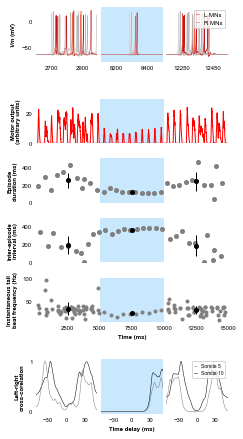

In [4]:
# Import pandas for data saving
import pandas as pd
import numpy as np
import json
from pylab import *
from Analysis_tools import *

results=[]
Epoch = 5000

# open swimming analysis results in .json file for each epoch
for i in range(0,3):
    names = "V0v_KO_results_epoch_" + str(i) + ".json"
    f = open(names,)
    results.append(json.load(f))

names = "V0v_KO_all_results.json"
f = open(names,)
all_results = json.load(f)

#open simulation results for V0v null model
read_data = pd.read_csv("Beat_and_Glide_V0v_KO.csv")
read_data

read_sim = np.ascontiguousarray(read_data)
read_sim = np.transpose(read_sim)
read_sim
Time = read_sim[0]
next_start = 1
next_end = next_start + nMN
VLMN = read_sim[1:next_end]
next_start = next_end
next_end = next_start + nMN
VRMN = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + ndI6
VLdI6 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + ndI6
VRdI6 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV0v
VLV0v = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV0v
VRV0v = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV2a
VLV2a = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV2a
VRV2a = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV1
VLV1 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV1
VRV1 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nMuscle
VLMuscle = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nMuscle
VRMuscle = read_sim[next_start:next_end]
TIME_END = Time[-1]
TIME_END

list_MNs = [int(nMN*i/4) for i in range(1,4)] #Plot 25th, 50th, and 75th neuron on rostrocaudal axis

#Declare the figure and subplots
figKO = plt.figure(constrained_layout=False, figsize=(3.6, 7.5))

widths = [12, 12, 12, 1]
heights = [2.5, 0.3, 2, 2, 2, 2, 0.3, 2.5]
gs = figKO.add_gridspec(nrows=8, ncols=4, width_ratios=widths, height_ratios=heights)

dt = 0.1 #discretization time

#FIRST, GRAPH VOLTAGE TRACES DURING THREE EPOCHS

fKO_ax0 = figKO.add_subplot(gs[0, 0])
fKO_ax1 = figKO.add_subplot(gs[0, 1])
fKO_ax2 = figKO.add_subplot(gs[0, 2])

nMN = 15

#Color maps
cmapBlue = matplotlib.cm.get_cmap('Blues')
cmapRed = matplotlib.cm.get_cmap('Reds')
cmapGreen = matplotlib.cm.get_cmap('Greens')
cmapRedPurple = matplotlib.cm.get_cmap('RdPu')
cmapGrey = matplotlib.cm.get_cmap('Greys')
cmapBrown = matplotlib.cm.get_cmap('YlOrBr')
cmapBrightGreen = matplotlib.cm.get_cmap('hsv') #in the range 0.2 to 0.4
    
# Line length and width    
LINELENGTH = 0.5
LINEWIDTH = 0.5

plt.rc('lines', linewidth=LINEWIDTH) 

# Change default font to Arial
matplotlib.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"

rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.bf'] = 'Arial:italic:bold'

#font size
SMALL_SIZE = 6

FONT_STYLE = 'bold'

MARKER_SIZE = 4

# plotting MN traces for epoch 1
for k in list_MNs:
    lines_left, = fKO_ax0.plot(Time, VLMN[k,:], c=cmapRed((k+1)/nMN),linestyle='-') # adding a color gradient, lighter color -> rostrally located
    lines_right, = fKO_ax0.plot(Time, VRMN[k,:], c=cmapGrey((k+1)/nMN/2), linestyle='-')

#y-axis limt
lower_y = -80
upper_y = 30

fKO_ax0.set_ylabel(r"$\mathbf{Vm}$" + " (mV)", fontsize= SMALL_SIZE, fontweight=FONT_STYLE) #y-axis label
fKO_ax0.set_ylim([lower_y, upper_y]) #y-axis limit
# Remove borders
fKO_ax0.spines['top'].set_visible(False)
fKO_ax0.spines['right'].set_visible(False)
fKO_ax0.spines['bottom'].set_visible(False)
fKO_ax0.spines['left'].set_visible(False)
# Tick parameters
fKO_ax0.tick_params(axis='both', which='both', length=0)
fKO_ax0.set_xticks([2700,2900])
fKO_ax0.set_yticks([i*50 + -50 for i in range(0,2)])
for item in (fKO_ax0.get_xticklabels() + fKO_ax0.get_yticklabels()):
    item.set_fontsize(SMALL_SIZE)
fKO_ax0.set_xlim([2600,  3000])

# plotting MN traces for epoch 2
for k in list_MNs:
    lines_left, = fKO_ax1.plot(Time, VLMN[k,:], c=cmapRed((k+1)/nMN),linestyle='-') # adding a color gradient, lighter color -> rostrally located
    lines_right, = fKO_ax1.plot(Time, VRMN[k,:], c=cmapGrey((k+1)/nMN/2), linestyle='-')

fKO_ax1.set_ylim([lower_y, upper_y])
fKO_ax1.spines['top'].set_visible(False)
fKO_ax1.spines['right'].set_visible(False)
fKO_ax1.spines['bottom'].set_visible(False)
fKO_ax1.spines['left'].set_visible(False)
fKO_ax1.tick_params(axis='both', which='both', length=0)
fKO_ax1.set_xticks([8200,8400])
for item in (fKO_ax1.get_xticklabels()):
    item.set_fontsize(SMALL_SIZE)
fKO_ax1.set_xlim([8100,  8500])
fKO_ax1.set_yticks([])
fKO_ax1.axvspan(5000, 10000, facecolor='xkcd:light blue', alpha=0.5)

# plotting MN traces for epoch 3
for k in list_MNs:
    lines_left, = fKO_ax2.plot(Time, VLMN[k,:], c=cmapRed((k+1)/nMN),linestyle='-') # adding a color gradient, lighter color -> rostrally located
    lines_right, = fKO_ax2.plot(Time, VRMN[k,:], c=cmapGrey((k+1)/nMN/2), linestyle='-')

fKO_ax2.set_ylim([lower_y, upper_y])
fKO_ax2.spines['top'].set_visible(False)
fKO_ax2.spines['right'].set_visible(False)
fKO_ax2.spines['bottom'].set_visible(False)
fKO_ax2.spines['left'].set_visible(False)
fKO_ax2.tick_params(axis='both', which='both', length=0)
fKO_ax2.set_xticks([12250,12450])
for item in (fKO_ax2.get_xticklabels()):
    item.set_fontsize(SMALL_SIZE)
fKO_ax2.set_xlim([12150,  12550])
fKO_ax2.set_yticks([])

# plotting motoneuron traces
for k in list_MNs:
    lines_left, = fKO_ax2.plot(Time, VLMN[k,:], c=cmapRed((k+1)/nMN),linestyle='-') # adding a color gradient, lighter color -> rostrally located
    lines_right, = fKO_ax2.plot(Time, VRMN[k,:], c=cmapGrey((k+1)/nMN/2), linestyle='-')
#Legend set-up
leg=fKO_ax2.legend(handles=[lines_left, lines_right], labels=['L MNs','R MNs'], loc='upper right', handlelength=LINELENGTH, fontsize=SMALL_SIZE)
leg.legendHandles[0].set_color('red')
leg.legendHandles[1].set_color('grey')

## PLOT MOTOR OUTPUT
#Declare subplot
fKO_ax3 = figKO.add_subplot(gs[2, 0:-1])

#add left and right muscle output
X = np.sum(VLMuscle, axis=0) + np.sum(VRMuscle, axis=0)
X = smooth(X, 500) #convolve with a step 50 ms wide

fKO_ax3.plot(Time, X, c='red', linewidth = 1)
fKO_ax3.set_ylabel('Motor output\n' + '(arbitrary units)', fontsize=SMALL_SIZE-1, fontweight = FONT_STYLE) #y-axis title
fKO_ax3.axvspan(5000, 10000, facecolor='xkcd:light blue', alpha=0.5) #add a blue stripe between t=5000 and 1000
fKO_ax3.set_xlim(0,15000) #x-axis limit
fKO_ax3.set_ylim(0,30)    #y-axis limit

#Remove borders
fKO_ax3.spines['top'].set_visible(False)
fKO_ax3.spines['right'].set_visible(False)
fKO_ax3.spines['bottom'].set_visible(False)
fKO_ax3.spines['left'].set_visible(False)        
fKO_ax3.tick_params(axis='both', which='both', length=0)
fKO_ax3.set_xticks([])

for item in ([fKO_ax3.title, fKO_ax3.xaxis.label, fKO_ax3.yaxis.label] +
         fKO_ax3.get_xticklabels() + fKO_ax3.get_yticklabels()):
    item.set_fontsize(SMALL_SIZE)

## NOW PLOT EPISODE DURATION AND INTER-EPISODE DURATION
    
# Declare subplots for episode duration and inter-episode duration
fKO_ax4 = figKO.add_subplot(gs[3, 0:-1])
fKO_ax5 = figKO.add_subplot(gs[4, 0:-1])

#remove borders
fKO_ax4.spines['top'].set_visible(False)
fKO_ax4.spines['right'].set_visible(False)
fKO_ax4.spines['bottom'].set_visible(False)
fKO_ax4.spines['left'].set_visible(False)        
fKO_ax4.tick_params(axis='both', which='both', length=0) #tick parameters
#Set fonts
for item in ([fKO_ax4.title, fKO_ax4.xaxis.label, fKO_ax4.yaxis.label] +
         fKO_ax4.get_xticklabels() + fKO_ax4.get_yticklabels()):
    item.set_fontsize(SMALL_SIZE)

#remove borders
fKO_ax5.spines['top'].set_visible(False)
fKO_ax5.spines['right'].set_visible(False)
fKO_ax5.spines['bottom'].set_visible(False)
fKO_ax5.spines['left'].set_visible(False)        
fKO_ax5.tick_params(axis='both', which='both', length=0) #tick parameters
#Set fonts
for item in ([fKO_ax5.title, fKO_ax5.xaxis.label, fKO_ax5.yaxis.label] +
         fKO_ax5.get_xticklabels() + fKO_ax5.get_yticklabels()):
    item.set_fontsize(SMALL_SIZE)
    
# Set ticks and limts
fKO_ax4.set_xticks([])
fKO_ax5.set_xticks([])
fKO_ax4.set_yticks([i*200 for i in range(0,5)])
fKO_ax5.set_yticks([i*200 for i in range(0,5)])

fKO_ax4.set_xlim([0, TIME_END])
fKO_ax5.set_xlim([0, TIME_END])

fKO_ax4.set_ylim([0, 500])
fKO_ax5.set_ylim([0, 500])

res = all_results['Events']['Duration (ms)']
time_start = all_results['Events']['Start times (ms)']

fKO_ax4.axvspan(5000, 10000, facecolor='xkcd:light blue', alpha=0.5) #blue background between t =5000 and 10000

#calculate mean and standard deviation of episode durations
dur_temp = [results[i]['Events']['Duration (ms)'] for i in range(0,3)]
mean_dur = [np.mean(dur_temp[i]) for i in range (0,3)]
std_dur = [np.std(dur_temp[i]) for i in range (0,3)]
x_mean_dur = [2500, 7500, 12500]
            
fKO_ax4.errorbar(x_mean_dur, mean_dur, yerr=std_dur, linestyle='None', color = 'black', marker='o', markersize=MARKER_SIZE, linewidth = 1.0, zorder=2)
            
fKO_ax4.plot(time_start, res, 'o', color = 'gray', markersize=MARKER_SIZE, zorder=1)
fKO_ax4.set_ylabel('Episode\n' + 'duration (ms)', fontsize=SMALL_SIZE, fontweight = FONT_STYLE)

res = all_results['Events']['Inter-event intervals']
time_start = all_results['Events']['End times (ms)'][:-1]

fKO_ax5.axvspan(5000, 10000, facecolor='xkcd:light blue', alpha=0.5)

#calculate mean and standard deviation of interepisode intervals
dur_temp = [results[i]['Events']['Inter-event intervals'] for i in range(0,3)]
mean_dur = [np.mean(dur_temp[i]) for i in range (0,3)]
std_dur = [np.std(dur_temp[i]) for i in range (0,3)]
x_mean_dur = [2500, 7500, 12500]
            
fKO_ax5.errorbar(x_mean_dur, mean_dur, yerr=std_dur, linestyle='None', color = 'black', marker='o', markersize=MARKER_SIZE, linewidth = 1.0,  zorder=2)

fKO_ax5.plot(time_start, res, 'o', color = 'gray', markersize=MARKER_SIZE, zorder=1)
fKO_ax5.set_ylabel('Inter-episode\n' + 'interval (ms)', fontsize=SMALL_SIZE, fontweight = FONT_STYLE)


### Instantaneous frequency
#Calculate instantaneous tail beat frequency and plot
num_tail_beats, interbeat_intervals, start_times, beat_times = calc_tail_beat_freq(VRMuscle, VLMuscle, nmax = len(Time), 
                                                        dt = 0.1, lower_bound = -0.5, upper_bound = 0.5, delay = 500)

fKO_ax6 = figKO.add_subplot(gs[5, 0:-1])
fKO_ax6.set_xlabel('Time (ms)', fontsize=SMALL_SIZE, fontweight = FONT_STYLE)

fKO_ax6.spines['top'].set_visible(False)
fKO_ax6.spines['right'].set_visible(False)
fKO_ax6.spines['bottom'].set_visible(False)
fKO_ax6.spines['left'].set_visible(False)        
fKO_ax6.tick_params(axis='both', which='both', length=0)

freq_temp = [results[i]['Average frequency']['Instantaneous frequency (Hz)'] for i in range(0,3)]
mean_freq = [np.nanmean(freq_temp[i]) for i in range (0,3)]
std_freq = [np.nanstd(freq_temp[i]) for i in range (0,3)]
x_mean_freq = [2500, 7500, 12500]

res = all_results['Average frequency']['Instantaneous frequency (Hz)']
time_start = all_results['Average frequency']['Beat times(ms)']

fKO_ax6.plot(time_start, res, 'o', color = 'gray', markersize=MARKER_SIZE-1, zorder=1)
fKO_ax6.set_ylabel('Instantaneous tail\n' + 'beat frequency (Hz)', fontsize=SMALL_SIZE-1, fontweight = FONT_STYLE)

for item in ([fKO_ax6.title, fKO_ax6.xaxis.label, fKO_ax6.yaxis.label] +
         fKO_ax6.get_xticklabels() + fKO_ax6.get_yticklabels()):
    item.set_fontsize(SMALL_SIZE)

fKO_ax6.set_xlim([0, TIME_END])

fKO_ax6.set_xticks([i*2500 for i in range(1,7)])

fKO_ax6.axvspan(5000, 10000, facecolor='xkcd:light blue', alpha=0.5)
fKO_ax6.set_xlabel('Time (ms)', fontsize=SMALL_SIZE, fontweight = FONT_STYLE)
            
fKO_ax6.errorbar(x_mean_freq, mean_freq, yerr=std_freq, linestyle='None', color = 'black', marker='o', markersize=MARKER_SIZE, linewidth = 1.0,  zorder=2)

# Plot left-right cross-correlation at somites 5 and 10
Duration_of_condition=5000
for i in range(0,3):
    Somite_index = 9
    res10 = Xcorr_LR(VLMuscle[Somite_index,Duration_of_condition*10*i:Duration_of_condition*10*(i+1)],VRMuscle[Somite_index,Duration_of_condition*10*i:Duration_of_condition*10*(i+1)])
    Somite_index = 4
    res5 = Xcorr_LR(VLMuscle[Somite_index,Duration_of_condition*10*i:Duration_of_condition*10*(i+1)],VRMuscle[Somite_index,Duration_of_condition*10*i:Duration_of_condition*10*(i+1)])

    
    fKO_LR = figKO.add_subplot(gs[-1, i])
    
    right_side = fKO_LR.spines["right"]
    top_side = fKO_LR.spines["top"]
    right_side.set_visible(False)
    top_side.set_visible(False)

    New_time = Time[0:Duration_of_condition*10].tolist()+(-Time[0:Duration_of_condition*10]).tolist()
    order = np.argsort(New_time)
    New_time= np.asarray(New_time)[order]

    line_somite10, = fKO_LR.plot(New_time[1:Duration_of_condition*20], res10, '-k',  c='black')
    line_somite5, =fKO_LR.plot(New_time[1:Duration_of_condition*20], res5, '-k', c='grey')
    
    if i == 2:
        leg_LR=fKO_LR.legend(handles=[line_somite5, line_somite10], labels=['Somite 5','Somite 10'], loc='upper right', handlelength=LINELENGTH, fontsize = SMALL_SIZE-1)
        leg_LR.legendHandles[0].set_color('grey')
        leg_LR.legendHandles[1].set_color('black')

    fKO_LR.set_xlim([-50,50])

    #remove borders
    fKO_LR.spines['top'].set_visible(False)
    fKO_LR.spines['right'].set_visible(False)
    fKO_LR.spines['bottom'].set_visible(False)
    fKO_LR.spines['left'].set_visible(False)
    fKO_LR.tick_params(axis='both', which='both', length=0)
    for item in ([fKO_LR.title, fKO_LR.xaxis.label, fKO_LR.yaxis.label] +
             fKO_LR.get_xticklabels() + fKO_LR.get_yticklabels()):
        item.set_fontsize(SMALL_SIZE)
    fKO_LR.set_xticks([-30,0,30])
    if i > 0:
        fKO_LR.set_yticks([])
    if i == 0:
        fKO_LR.set_ylabel('Left-right\n' + 'cross-corelation', fontsize = SMALL_SIZE, fontweight = FONT_STYLE)
        
    if i == 1:
        fKO_LR.set_xlabel('Time delay (ms)', fontsize = SMALL_SIZE, fontweight = FONT_STYLE)
        fKO_LR.axvspan(-50, 50, facecolor='xkcd:light blue', alpha=0.5)


plt.subplots_adjust(hspace=0.4, wspace=0.075)
plt.savefig('V0v_KO.png', dpi=1000)
plt.show()

### Figure 5 - figure supplement 1F-J - membrane potentials during V0v null

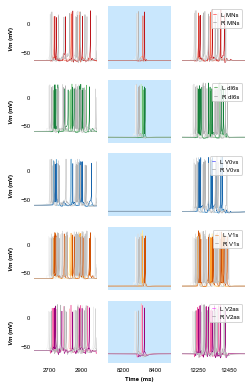

In [5]:
# Import pandas for data saving
import pandas as pd
import numpy as np
from pylab import *
from Analysis_tools import *

read_data = pd.read_csv("Beat_and_Glide_V0v_KO.csv")
read_data

read_sim = np.ascontiguousarray(read_data)
read_sim = np.transpose(read_sim)
read_sim
Time = read_sim[0]
next_start = 1
next_end = next_start + nMN
VLMN = read_sim[1:next_end]
next_start = next_end
next_end = next_start + nMN
VRMN = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + ndI6
VLdI6 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + ndI6
VRdI6 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV0v
VLV0v = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV0v
VRV0v = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV2a
VLV2a = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV2a
VRV2a = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV1
VLV1 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV1
VRV1 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nMuscle
VLMuscle = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nMuscle
VRMuscle = read_sim[next_start:next_end]
TIME_END = Time[-1]
TIME_END

#list cell traces to plot
list_MNs = [int(nMN*i/4) for i in range(1,4)] #Plot 25th, 50th, and 75th neuron on rostrocaudal axis
list_dI6s = [int(ndI6*i/4) for i in range(1,4)]
list_V0vs = [int(nV0v*i/4) for i in range(1,4)] #Plot 25th, 50th, and 75th neuron on rostrocaudal axis
list_V2as = [int(nV2a*i/4) for i in range(1,4)] #Plot 25th, 50th, and 75th neuron on rostrocaudal axis
list_V1s = [int(nV1*i/4) - 1 for i in range(1,4) if 0 < int(nMN*i/4) - 1 < nV1] #Plot 25th, 50th, and 75th neuron on rostrocaudal axis

#list_dI6s = [int(nMN*i/4) for i in range(1,4) if int(nMN*i/4) < ndI6]
#list_V0vs = [int(nMN*i/4) for i in range(1,4) if int(nMN*i/4) < nV0v] #Plot 25th, 50th, and 75th neuron on rostrocaudal axis
#list_V2as = [int(nMN*i/4) - 2 for i in range(1,4) if 0 < int(nMN*i/4) - 2 < nV2a] #Plot 25th, 50th, and 75th neuron on rostrocaudal axis
#list_V1s = [int(nMN*i/4) - 4 for i in range(1,4) if 0 < int(nMN*i/4) - 4 < nV1] #Plot 25th, 50th, and 75th neuron on rostrocaudal axis

#color maps
cmapBlue = matplotlib.cm.get_cmap('Blues')
cmapRed = matplotlib.cm.get_cmap('Reds')
cmapGreen = matplotlib.cm.get_cmap('Greens')
cmapRedPurple = matplotlib.cm.get_cmap('RdPu')
cmapGrey = matplotlib.cm.get_cmap('Greys')
cmapBrown = matplotlib.cm.get_cmap('YlOrBr')
cmapYellow = matplotlib.cm.get_cmap('YlOrBr')
cmapBrightGreen = matplotlib.cm.get_cmap('hsv') #in the range 0.2 to 0.4

#declare figure
fig_KO, ax = plt.subplots(5, 3, figsize=(3.6, 5.5))

LINELENGTH = 0.5
LINEWIDTH = 0.5

# Change default font to Arial
matplotlib.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"

rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.bf'] = 'Arial:italic:bold'

plt.rc('lines', linewidth=LINEWIDTH) 

#font size and style
SMALL_SIZE = 6

FONT_STYLE = 'bold'

x_starts = [2600, 8100, 12150]
x_ends = [3000, 8500, 12550]

for j in range(0, 3): #cycle through three epochs
    # plotting motoneuron traces
    for k in list_MNs: #plot MN traces
        lines_left, = ax[0,j].plot(Time, VLMN[k,:], c=cmapRed((k+1)/nMN),linestyle='-') # adding a color gradient, lighter color -> rostrally located
        lines_right, = ax[0,j].plot(Time, VRMN[k,:], c=cmapGrey((k+1)/nMN/2), linestyle='-')
    if j == 2: #add legend in the third panel
        leg=ax[0,j].legend(handles=[lines_left, lines_right], labels=['L MNs','R MNs'], loc='upper right', handlelength=LINELENGTH, fontsize=SMALL_SIZE)
        leg.legendHandles[0].set_color('red')
        leg.legendHandles[1].set_color('grey')
        for line in leg.get_lines():
            line.set_linewidth(LINEWIDTH)

    #y-axis limits
    lower_y = -80
    upper_y = 30
    # set-up for all five rows of the plot
    for i in range (0,5):
        if j == 0:
            ax[i,j].set_ylabel(r"$\mathbf{Vm}$" + " (mV)", fontsize= SMALL_SIZE, fontweight=FONT_STYLE)
            ax[i,j].set_yticks([i*50 + -50 for i in range(0,2)])
            ax[i,j].set_ylim([lower_y, upper_y])
        else:
            ax[i,j].tick_params(labelleft=False) 
        #remove borders
        ax[i,j].spines['top'].set_visible(False)
        ax[i,j].spines['right'].set_visible(False)
        ax[i,j].spines['bottom'].set_visible(False)
        ax[i,j].spines['left'].set_visible(False)
        # tick parameters
        ax[i,j].tick_params(axis='both', which='both', length=0)
        ax[i,j].set_xticks([])
        ax[i,j].set_xlim(x_starts[j], x_ends[j])
        for item in ([ax[i,j].title, ax[i,j].xaxis.label, ax[i,j].yaxis.label] +
                 ax[i,j].get_xticklabels() + ax[i,j].get_yticklabels()):
            item.set_fontsize(SMALL_SIZE)
        if j == 1:
            ax[i,1].axvspan(5000, 10000, facecolor='xkcd:light blue', alpha=0.5) #blue background for epoch 2

    # plotting dI6
    cmapL = matplotlib.cm.get_cmap('Blues')
    cmapR = matplotlib.cm.get_cmap('Reds')
    ax[1,j].plot([0], [0], c=cmapL(0.5))
    ax[1,j].plot([0], [0], c=cmapR(0.5))    

    for k in list_dI6s:
        lines_left, = ax[1,j].plot(Time, VLdI6[k,:], c=cmapGreen((k+1)/ndI6), linestyle='-') 
        lines_right, = ax[1,j].plot(Time, VRdI6[k,:], c=cmapGrey((k+1)/ndI6/2), linestyle='-')
    if j == 2:
        leg=ax[1,j].legend(handles=[lines_left, lines_right], labels=['L dI6s','R dI6s'], loc='upper right', handlelength=LINELENGTH, fontsize=SMALL_SIZE)
        leg.legendHandles[0].set_color('green')
        leg.legendHandles[1].set_color('grey')
        for line in leg.get_lines():
            line.set_linewidth(LINEWIDTH)

    # plotting V0v
    for k in list_V0vs:
        lines_left, = ax[2,j].plot(Time, VLV0v[k,:], c=cmapL((k+1)/nV0v)) 
        lines_right, = ax[2,j].plot(Time, VRV0v[k,:], c=cmapGrey((k+1)/nV0v/2))
    if j == 2:
        leg=ax[2,j].legend(handles=[lines_left, lines_right], labels=['L V0vs','R V0vs'], loc='upper right', handlelength=LINELENGTH, fontsize=SMALL_SIZE)
        leg.legendHandles[0].set_color('blue')
        leg.legendHandles[1].set_color('grey')
        for line in leg.get_lines():
            line.set_linewidth(LINEWIDTH)
    
    # plotting V1
    for k in list_V1s:
        ax[3,j].plot(Time, VLV1[k,:], c=cmapYellow((k+1)/nV1), linestyle='-') 
        ax[3,j].plot(Time, VRV1[k,:], c=cmapGrey((k+1)/nV1/2), linestyle='-')
    if j == 2:
        leg=ax[3,j].legend(handles=[lines_left, lines_right], labels=['L V1s','R V1s'], loc='upper right', handlelength=LINELENGTH, fontsize=SMALL_SIZE)
        leg.legendHandles[0].set_color(cmapYellow(0.6))
        leg.legendHandles[1].set_color('grey')
        for line in leg.get_lines():
            line.set_linewidth(LINEWIDTH)
        
    # plotting V2a
    for k in list_V2as:
        lines_left, = ax[4,j].plot(Time, VLV2a[k,:], c=cmapRedPurple((k+1)/nV2a), linestyle='-') 
        lines_right, = ax[4,j].plot(Time, VRV2a[k,:], c=cmapGrey((k+1)/nV2a/2), linestyle='-')
    if j == 2:
        leg=ax[4,j].legend(handles=[lines_left, lines_right], labels=['L V2as','R V2as'], loc='upper right', handlelength=LINELENGTH, fontsize=SMALL_SIZE)
        leg.legendHandles[0].set_color('magenta')
        leg.legendHandles[1].set_color('grey')
        for line in leg.get_lines():
            line.set_linewidth(LINEWIDTH)

ax[4,0].set_xticks([2700, 2900])
ax[4,1].set_xticks([8200, 8400])
ax[4,2].set_xticks([12250, 12450])

for k in range(0,3):
    for item in (ax[4,k].get_xticklabels()):
        item.set_fontsize(SMALL_SIZE)        
ax[4, 1].set_xlabel('Time (ms)', fontsize = SMALL_SIZE, fontweight = FONT_STYLE)

plt.tight_layout()

plt.savefig('V0v_KO_Suppl_Fig.png', dpi=1000)
plt.show()

### Figure 6A-F - V1 null

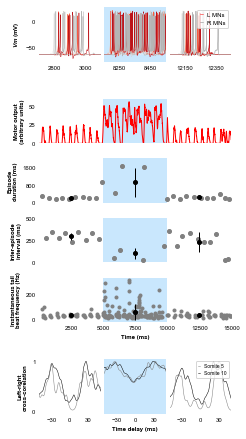

In [6]:
# Import pandas for data saving
import pandas as pd
import numpy as np
import json
from pylab import *
from Analysis_tools import *

results=[]
Epoch = 5000

# open swimming analysis results in .json file for each epoch
for i in range(0,3):
    names = "V1_KO_results_epoch_" + str(i) + ".json"
    f = open(names,)
    results.append(json.load(f))

names = "V1_KO_all_results.json"
f = open(names,)
all_results = json.load(f)

#open simulation results for V0v null model
read_data = pd.read_csv("Beat_and_Glide_V1_KO.csv")
read_data

read_sim = np.ascontiguousarray(read_data)
read_sim = np.transpose(read_sim)
read_sim
Time = read_sim[0]
next_start = 1
next_end = next_start + nMN
VLMN = read_sim[1:next_end]
next_start = next_end
next_end = next_start + nMN
VRMN = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + ndI6
VLdI6 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + ndI6
VRdI6 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV0v
VLV0v = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV0v
VRV0v = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV2a
VLV2a = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV2a
VRV2a = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV1
VLV1 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV1
VRV1 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nMuscle
VLMuscle = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nMuscle
VRMuscle = read_sim[next_start:next_end]
TIME_END = Time[-1]
TIME_END

list_MNs = [int(nMN*i/4) for i in range(1,4)] #Plot 25th, 50th, and 75th neuron on rostrocaudal axis

#Declare the figure and subplots
figKO = plt.figure(constrained_layout=False, figsize=(3.6, 7.5))

widths = [12, 12, 12, 1]
heights = [2.5, 0.3, 2, 2, 2, 2, 0.3, 2.5]
gs = figKO.add_gridspec(nrows=8, ncols=4, width_ratios=widths, height_ratios=heights)

dt = 0.1 #discretization time

#FIRST, GRAPH VOLTAGE TRACES DURING THREE EPOCHS

fKO_ax0 = figKO.add_subplot(gs[0, 0])
fKO_ax1 = figKO.add_subplot(gs[0, 1])
fKO_ax2 = figKO.add_subplot(gs[0, 2])

nMN = 15

#Color maps
cmapBlue = matplotlib.cm.get_cmap('Blues')
cmapRed = matplotlib.cm.get_cmap('Reds')
cmapGreen = matplotlib.cm.get_cmap('Greens')
cmapRedPurple = matplotlib.cm.get_cmap('RdPu')
cmapGrey = matplotlib.cm.get_cmap('Greys')
cmapBrown = matplotlib.cm.get_cmap('YlOrBr')
cmapBrightGreen = matplotlib.cm.get_cmap('hsv') #in the range 0.2 to 0.4
    
# Line length and width    
LINELENGTH = 0.5
LINEWIDTH = 0.5

plt.rc('lines', linewidth=LINEWIDTH) 

# Change default font to Arial
matplotlib.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"

rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.bf'] = 'Arial:italic:bold'

#font size
SMALL_SIZE = 6

FONT_STYLE = 'bold'

MARKER_SIZE = 4

# plotting motoneuron traces for epoch 1
for k in list_MNs:
    lines_left, = fKO_ax0.plot(Time, VLMN[k,:], c=cmapRed((k+1)/nMN),linestyle='-') # adding a color gradient, lighter color -> rostrally located
    lines_right, = fKO_ax0.plot(Time, VRMN[k,:], c=cmapGrey((k+1)/nMN/2), linestyle='-')

lower_y = -80
upper_y = 30

fKO_ax0.set_ylabel(r"$\mathbf{Vm}$" + " (mV)", fontsize= SMALL_SIZE, fontweight=FONT_STYLE)
fKO_ax0.set_ylim([lower_y, upper_y])
fKO_ax0.spines['top'].set_visible(False)
fKO_ax0.spines['right'].set_visible(False)
fKO_ax0.spines['bottom'].set_visible(False)
fKO_ax0.spines['left'].set_visible(False)
fKO_ax0.tick_params(axis='both', which='both', length=0)
fKO_ax0.set_xticks([2800,3000])
fKO_ax0.set_yticks([i*50 + -50 for i in range(0,2)])
for item in (fKO_ax0.get_xticklabels() + fKO_ax0.get_yticklabels()):
    item.set_fontsize(SMALL_SIZE)
fKO_ax0.set_xlim([2700,  3100])

# plotting motoneuron traces  for epoch 2
for k in list_MNs:
    lines_left, = fKO_ax1.plot(Time, VLMN[k,:], c=cmapRed((k+1)/nMN),linestyle='-') # adding a color gradient, lighter color -> rostrally located
    lines_right, = fKO_ax1.plot(Time, VRMN[k,:], c=cmapGrey((k+1)/nMN/2), linestyle='-')

fKO_ax1.set_ylim([lower_y, upper_y])
fKO_ax1.spines['top'].set_visible(False)
fKO_ax1.spines['right'].set_visible(False)
fKO_ax1.spines['bottom'].set_visible(False)
fKO_ax1.spines['left'].set_visible(False)
fKO_ax1.tick_params(axis='both', which='both', length=0)
fKO_ax1.set_xticks([8250,8450])
for item in (fKO_ax1.get_xticklabels()):
    item.set_fontsize(SMALL_SIZE)
fKO_ax1.set_xlim([8150,  8550])
fKO_ax1.set_yticks([])
fKO_ax1.axvspan(5000, 10000, facecolor='xkcd:light blue', alpha=0.5)

# plotting motoneuron traces for epoch 3
for k in list_MNs:
    lines_left, = fKO_ax2.plot(Time, VLMN[k,:], c=cmapRed((k+1)/nMN),linestyle='-') # adding a color gradient, lighter color -> rostrally located
    lines_right, = fKO_ax2.plot(Time, VRMN[k,:], c=cmapGrey((k+1)/nMN/2), linestyle='-')

fKO_ax2.set_ylim([lower_y, upper_y])
fKO_ax2.spines['top'].set_visible(False)
fKO_ax2.spines['right'].set_visible(False)
fKO_ax2.spines['bottom'].set_visible(False)
fKO_ax2.spines['left'].set_visible(False)
fKO_ax2.tick_params(axis='both', which='both', length=0)
fKO_ax2.set_xticks([12150,12350])
for item in (fKO_ax2.get_xticklabels()):
    item.set_fontsize(SMALL_SIZE)
fKO_ax2.set_xlim([12050,  12450])
fKO_ax2.set_yticks([])

# plotting motoneuron traces
for k in list_MNs:
    lines_left, = fKO_ax2.plot(Time, VLMN[k,:], c=cmapRed((k+1)/nMN),linestyle='-') # adding a color gradient, lighter color -> rostrally located
    lines_right, = fKO_ax2.plot(Time, VRMN[k,:], c=cmapGrey((k+1)/nMN/2), linestyle='-')
leg=fKO_ax2.legend(handles=[lines_left, lines_right], labels=['L MNs','R MNs'], loc='upper right', handlelength=LINELENGTH, fontsize=SMALL_SIZE)
leg.legendHandles[0].set_color('red')
leg.legendHandles[1].set_color('grey')

## PLOT MOTOR OUTPUT

fKO_ax3 = figKO.add_subplot(gs[2, 0:-1])
#motor output is the sum of left and right muscles
X = np.sum(VLMuscle, axis=0) + np.sum(VRMuscle, axis=0)
X = smooth(X, 500) #convolve with a step 50 ms wide
    
fKO_ax3.plot(Time, X, c='red', linewidth = 1)
fKO_ax3.set_ylabel('Motor output\n' + '(arbitrary units)', fontsize=SMALL_SIZE-1, fontweight = FONT_STYLE)
fKO_ax3.set_yticks([i*25 for i in range(0,5)])
fKO_ax3.axvspan(5000, 10000, facecolor='xkcd:light blue', alpha=0.5)
fKO_ax3.set_xlim(0,15000) 
fKO_ax3.set_ylim(0,60)    

#remove borders
fKO_ax3.spines['top'].set_visible(False)
fKO_ax3.spines['right'].set_visible(False)
fKO_ax3.spines['bottom'].set_visible(False)
fKO_ax3.spines['left'].set_visible(False)
#tick parameters
fKO_ax3.tick_params(axis='both', which='both', length=0)
fKO_ax3.set_xticks([])

for item in ([fKO_ax3.title, fKO_ax3.xaxis.label, fKO_ax3.yaxis.label] +
         fKO_ax3.get_xticklabels() + fKO_ax3.get_yticklabels()):
    item.set_fontsize(SMALL_SIZE)

## NOW PLOT EPISODE DURATION AND INTER-EPISODE DURATION
    
fKO_ax4 = figKO.add_subplot(gs[3, 0:-1])
fKO_ax5 = figKO.add_subplot(gs[4, 0:-1])
#remove borders
fKO_ax4.spines['top'].set_visible(False)
fKO_ax4.spines['right'].set_visible(False)
fKO_ax4.spines['bottom'].set_visible(False)
fKO_ax4.spines['left'].set_visible(False)        
fKO_ax4.tick_params(axis='both', which='both', length=0) #set ticks

for item in ([fKO_ax4.title, fKO_ax4.xaxis.label, fKO_ax4.yaxis.label] +
         fKO_ax4.get_xticklabels() + fKO_ax4.get_yticklabels()):
    item.set_fontsize(SMALL_SIZE)
#remove borders        
fKO_ax5.spines['top'].set_visible(False)
fKO_ax5.spines['right'].set_visible(False)
fKO_ax5.spines['bottom'].set_visible(False)
fKO_ax5.spines['left'].set_visible(False)        
fKO_ax5.tick_params(axis='both', which='both', length=0)  #set ticks

for item in ([fKO_ax5.title, fKO_ax5.xaxis.label, fKO_ax5.yaxis.label] +
         fKO_ax5.get_xticklabels() + fKO_ax5.get_yticklabels()):
    item.set_fontsize(SMALL_SIZE)

# tick settings
fKO_ax4.set_xticks([])
fKO_ax5.set_xticks([])
fKO_ax4.set_yticks([i*800 for i in range(0,5)])
fKO_ax5.set_yticks([i*250 for i in range(0,5)])

fKO_ax4.set_xlim([0, TIME_END])
fKO_ax5.set_xlim([0, TIME_END])

fKO_ax4.set_ylim([0, 2000])
fKO_ax5.set_ylim([0, 500])


res = all_results['Events']['Duration (ms)']
time_start = all_results['Events']['Start times (ms)']

fKO_ax4.axvspan(5000, 10000, facecolor='xkcd:light blue', alpha=0.5)
# mean duration
dur_temp = [results[i]['Events']['Duration (ms)'] for i in range(0,3)]
mean_dur = [np.mean(dur_temp[i]) for i in range (0,3)]
std_dur = [np.std(dur_temp[i]) for i in range (0,3)]
x_mean_dur = [2500, 7500, 12500]
#plot mean duration and error bar          
fKO_ax4.errorbar(x_mean_dur, mean_dur, yerr=std_dur, linestyle='None', color = 'black', marker='o', markersize=MARKER_SIZE, linewidth = 1.0, zorder=2)

#plot durations
fKO_ax4.plot(time_start, res, 'o', color = 'gray', markersize=MARKER_SIZE, zorder=1)
fKO_ax4.set_ylabel('Episode\n' + 'duration (ms)', fontsize=SMALL_SIZE, fontweight = FONT_STYLE)

res = all_results['Events']['Inter-event intervals']
time_start = all_results['Events']['End times (ms)'][:-1]

fKO_ax5.axvspan(5000, 10000, facecolor='xkcd:light blue', alpha=0.5)
# inter-episode intervals
dur_temp = [results[i]['Events']['Inter-event intervals'] for i in range(0,3)]
mean_dur = [np.mean(dur_temp[i]) for i in range (0,3)]
std_dur = [np.std(dur_temp[i]) for i in range (0,3)]
x_mean_dur = [2500, 7500, 12500]
#plot mean inter-episode intervals and error bar            
fKO_ax5.errorbar(x_mean_dur, mean_dur, yerr=std_dur, linestyle='None', color = 'black', marker='o', markersize=MARKER_SIZE, linewidth = 1.0,  zorder=2)
#plot inter-episode intervals
fKO_ax5.plot(time_start, res, 'o', color = 'gray', markersize=MARKER_SIZE, zorder=1)
fKO_ax5.set_ylabel('Inter-episode\n' + 'interval (ms)', fontsize=SMALL_SIZE, fontweight = FONT_STYLE)


### Instantaneous frequency

num_tail_beats, interbeat_intervals, start_times, beat_times = calc_tail_beat_freq(VRMuscle, VLMuscle, nmax = len(Time), 
                                                        dt = 0.1, lower_bound = -0.5, upper_bound = 0.5, delay = 500)

fKO_ax6 = figKO.add_subplot(gs[5, 0:-1])
fKO_ax6.set_xlabel('Time (ms)', fontsize=SMALL_SIZE, fontweight = FONT_STYLE)

fKO_ax6.spines['top'].set_visible(False)
fKO_ax6.spines['right'].set_visible(False)
fKO_ax6.spines['bottom'].set_visible(False)
fKO_ax6.spines['left'].set_visible(False)        
fKO_ax6.tick_params(axis='both', which='both', length=0)

# mean frequency
freq_temp = [results[i]['Average frequency']['Instantaneous frequency (Hz)'] for i in range(0,3)]
mean_freq = [np.nanmean(freq_temp[i]) for i in range (0,3)]
std_freq = [np.nanstd(freq_temp[i]) for i in range (0,3)]
x_mean_freq = [2500, 7500, 12500]

res = all_results['Average frequency']['Instantaneous frequency (Hz)']
time_start = all_results['Average frequency']['Beat times(ms)']

#plot frequency
fKO_ax6.plot(time_start, res, 'o', color = 'gray', markersize=MARKER_SIZE-1, zorder=1)
fKO_ax6.set_ylabel('Instantaneous tail\n' + 'beat frequency (Hz)', fontsize=SMALL_SIZE-1, fontweight = FONT_STYLE)

for item in ([fKO_ax6.title, fKO_ax6.xaxis.label, fKO_ax6.yaxis.label] +
         fKO_ax6.get_xticklabels() + fKO_ax6.get_yticklabels()):
    item.set_fontsize(SMALL_SIZE)

fKO_ax6.set_xlim([0, TIME_END])
    
fKO_ax6.set_xticks([i*2500 for i in range(1,7)])

fKO_ax6.axvspan(5000, 10000, facecolor='xkcd:light blue', alpha=0.5)
fKO_ax6.set_xlabel('Time (ms)', fontsize=SMALL_SIZE, fontweight = FONT_STYLE)
            
fKO_ax6.errorbar(x_mean_freq, mean_freq, yerr=std_freq, linestyle='None', color = 'black', marker='o', markersize=MARKER_SIZE, linewidth = 1.0,  zorder=2)

# plot left-right correlation

Duration_of_condition=5000
for i in range(0,3):
    #calculate left-right cross-correlation from somite 4 and 9
    Somite_index = 9
    res10 = Xcorr_LR(VLMuscle[Somite_index,Duration_of_condition*10*i:Duration_of_condition*10*(i+1)],VRMuscle[Somite_index,Duration_of_condition*10*i:Duration_of_condition*10*(i+1)])
    Somite_index = 4
    res5 = Xcorr_LR(VLMuscle[Somite_index,Duration_of_condition*10*i:Duration_of_condition*10*(i+1)],VRMuscle[Somite_index,Duration_of_condition*10*i:Duration_of_condition*10*(i+1)])

    fKO_LR = figKO.add_subplot(gs[-1, i])
    
    right_side = fKO_LR.spines["right"]
    top_side = fKO_LR.spines["top"]
    right_side.set_visible(False)
    top_side.set_visible(False)

    New_time = Time[0:Duration_of_condition*10].tolist()+(-Time[0:Duration_of_condition*10]).tolist()
    order = np.argsort(New_time)
    New_time= np.asarray(New_time)[order]

    #plot left-right cross-correlation from somite 4 and 9
    line_somite10, = fKO_LR.plot(New_time[1:Duration_of_condition*20], res10, '-k',  c='black')
    line_somite5, =fKO_LR.plot(New_time[1:Duration_of_condition*20], res5, '-k', c='grey')
    
    if i == 2:
        leg_LR=fKO_LR.legend(handles=[line_somite5, line_somite10], labels=['Somite 5','Somite 10'], loc='upper right', handlelength=LINELENGTH, fontsize = SMALL_SIZE-1)
        leg_LR.legendHandles[0].set_color('grey')
        leg_LR.legendHandles[1].set_color('black')

    fKO_LR.set_xlim([-50,50])

    fKO_LR.spines['top'].set_visible(False)
    fKO_LR.spines['right'].set_visible(False)
    fKO_LR.spines['bottom'].set_visible(False)
    fKO_LR.spines['left'].set_visible(False)
    fKO_LR.tick_params(axis='both', which='both', length=0)
    for item in ([fKO_LR.title, fKO_LR.xaxis.label, fKO_LR.yaxis.label] +
             fKO_LR.get_xticklabels() + fKO_LR.get_yticklabels()):
        item.set_fontsize(SMALL_SIZE)
    fKO_LR.set_xticks([-30,0,30])
    if i > 0:
        fKO_LR.set_yticks([])
    if i == 0:
        fKO_LR.set_ylabel('Left-right\n' + 'cross-corelation', fontsize = SMALL_SIZE, fontweight = FONT_STYLE)
        
    if i == 1:
        fKO_LR.set_xlabel('Time delay (ms)', fontsize = SMALL_SIZE, fontweight = FONT_STYLE)
        fKO_LR.axvspan(-50, 50, facecolor='xkcd:light blue', alpha=0.5)

plt.subplots_adjust(hspace=0.4, wspace=0.075)
plt.savefig('V1_KO.png', dpi=1000)
plt.show()

### Figure 6 - figure supplement 1A-E - membrane potential during V1 null

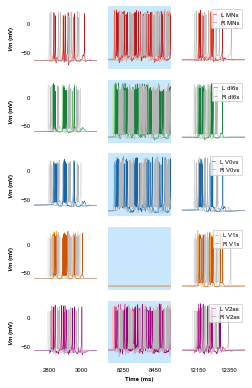

In [7]:
# Import pandas for data saving
import pandas as pd
import numpy as np
from pylab import *
from Analysis_tools import *

read_data = pd.read_csv("Beat_and_Glide_V1_KO.csv")
read_data

read_sim = np.ascontiguousarray(read_data)
read_sim = np.transpose(read_sim)
read_sim
Time = read_sim[0]
next_start = 1
next_end = next_start + nMN
VLMN = read_sim[1:next_end]
next_start = next_end
next_end = next_start + nMN
VRMN = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + ndI6
VLdI6 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + ndI6
VRdI6 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV0v
VLV0v = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV0v
VRV0v = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV2a
VLV2a = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV2a
VRV2a = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV1
VLV1 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV1
VRV1 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nMuscle
VLMuscle = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nMuscle
VRMuscle = read_sim[next_start:next_end]
TIME_END = Time[-1]
TIME_END

#list cell traces to plot
list_MNs = [int(nMN*i/4) for i in range(1,4)] #Plot 25th, 50th, and 75th neuron on rostrocaudal axis
list_dI6s = [int(ndI6*i/4) for i in range(1,4)]
list_V0vs = [int(nV0v*i/4) for i in range(1,4)] #Plot 25th, 50th, and 75th neuron on rostrocaudal axis
list_V2as = [int(nV2a*i/4) for i in range(1,4)] #Plot 25th, 50th, and 75th neuron on rostrocaudal axis
list_V1s = [int(nV1*i/4) - 1 for i in range(1,4) if 0 < int(nMN*i/4) - 1 < nV1] #Plot 25th, 50th, and 75th neuron on rostrocaudal axis

#list_dI6s = [int(nMN*i/4) for i in range(1,4) if int(nMN*i/4) < ndI6]
#list_V0vs = [int(nMN*i/4) for i in range(1,4) if int(nMN*i/4) < nV0v] #Plot 25th, 50th, and 75th neuron on rostrocaudal axis
#list_V2as = [int(nMN*i/4) - 2 for i in range(1,4) if 0 < int(nMN*i/4) - 2 < nV2a] #Plot 25th, 50th, and 75th neuron on rostrocaudal axis
#list_V1s = [int(nMN*i/4) - 4 for i in range(1,4) if 0 < int(nMN*i/4) - 4 < nV1] #Plot 25th, 50th, and 75th neuron on rostrocaudal axis

#color maps
cmapBlue = matplotlib.cm.get_cmap('Blues')
cmapRed = matplotlib.cm.get_cmap('Reds')
cmapGreen = matplotlib.cm.get_cmap('Greens')
cmapRedPurple = matplotlib.cm.get_cmap('RdPu')
cmapGrey = matplotlib.cm.get_cmap('Greys')
cmapBrown = matplotlib.cm.get_cmap('YlOrBr')
cmapYellow = matplotlib.cm.get_cmap('YlOrBr')
cmapBrightGreen = matplotlib.cm.get_cmap('hsv') #in the range 0.2 to 0.4

#declare figure
fig_KO, ax = plt.subplots(5, 3, figsize=(3.6, 5.5))

LINELENGTH = 0.5
LINEWIDTH = 0.5

# Change default font to Arial
matplotlib.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"

rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.bf'] = 'Arial:italic:bold'

plt.rc('lines', linewidth=LINEWIDTH) 

#font size and style
SMALL_SIZE = 6

FONT_STYLE = 'bold'

x_starts = [2700, 8150, 12050]
x_ends = [3100, 8550, 12450]

for j in range(0, 3): #cycle through three epochs
    # plotting motoneuron traces
    for k in list_MNs: #plot MN traces
        lines_left, = ax[0,j].plot(Time, VLMN[k,:], c=cmapRed((k+1)/nMN),linestyle='-') # adding a color gradient, lighter color -> rostrally located
        lines_right, = ax[0,j].plot(Time, VRMN[k,:], c=cmapGrey((k+1)/nMN/2), linestyle='-')
    if j == 2: #add legend in the third panel
        leg=ax[0,j].legend(handles=[lines_left, lines_right], labels=['L MNs','R MNs'], loc='upper right', handlelength=LINELENGTH, fontsize=SMALL_SIZE)
        leg.legendHandles[0].set_color('red')
        leg.legendHandles[1].set_color('grey')
        for line in leg.get_lines():
            line.set_linewidth(LINEWIDTH)

    #y-axis limits
    lower_y = -80
    upper_y = 30
    # set-up for all five rows of the plot
    for i in range (0,5):
        if j == 0:
            ax[i,j].set_ylabel(r"$\mathbf{Vm}$" + " (mV)", fontsize= SMALL_SIZE, fontweight=FONT_STYLE)
            ax[i,j].set_yticks([i*50 + -50 for i in range(0,2)])
            ax[i,j].set_ylim([lower_y, upper_y])
        else:
            ax[i,j].tick_params(labelleft=False) 
        #remove borders
        ax[i,j].spines['top'].set_visible(False)
        ax[i,j].spines['right'].set_visible(False)
        ax[i,j].spines['bottom'].set_visible(False)
        ax[i,j].spines['left'].set_visible(False)
        # tick parameters
        ax[i,j].tick_params(axis='both', which='both', length=0)
        ax[i,j].set_xticks([])
        ax[i,j].set_xlim(x_starts[j], x_ends[j])
        for item in ([ax[i,j].title, ax[i,j].xaxis.label, ax[i,j].yaxis.label] +
                 ax[i,j].get_xticklabels() + ax[i,j].get_yticklabels()):
            item.set_fontsize(SMALL_SIZE)
        if j == 1:
            ax[i,1].axvspan(5000, 10000, facecolor='xkcd:light blue', alpha=0.5) #blue background for epoch 2

    # plotting dI6
    cmapL = matplotlib.cm.get_cmap('Blues')
    cmapR = matplotlib.cm.get_cmap('Reds')
    ax[1,j].plot([0], [0], c=cmapL(0.5))
    ax[1,j].plot([0], [0], c=cmapR(0.5))    

    for k in list_dI6s:
        lines_left, = ax[1,j].plot(Time, VLdI6[k,:], c=cmapGreen((k+1)/ndI6), linestyle='-') 
        lines_right, = ax[1,j].plot(Time, VRdI6[k,:], c=cmapGrey((k+1)/ndI6/2), linestyle='-')
    if j == 2:
        leg=ax[1,j].legend(handles=[lines_left, lines_right], labels=['L dI6s','R dI6s'], loc='upper right', handlelength=LINELENGTH, fontsize=SMALL_SIZE)
        leg.legendHandles[0].set_color('green')
        leg.legendHandles[1].set_color('grey')
        for line in leg.get_lines():
            line.set_linewidth(LINEWIDTH)

    # plotting V0v
    for k in list_V0vs:
        lines_left, = ax[2,j].plot(Time, VLV0v[k,:], c=cmapL((k+1)/nV0v)) 
        lines_right, = ax[2,j].plot(Time, VRV0v[k,:], c=cmapGrey((k+1)/nV0v/2))
    if j == 2:
        leg=ax[2,j].legend(handles=[lines_left, lines_right], labels=['L V0vs','R V0vs'], loc='upper right', handlelength=LINELENGTH, fontsize=SMALL_SIZE)
        leg.legendHandles[0].set_color('blue')
        leg.legendHandles[1].set_color('grey')
        for line in leg.get_lines():
            line.set_linewidth(LINEWIDTH)
    
    # plotting V1
    for k in list_V1s:
        ax[3,j].plot(Time, VLV1[k,:], c=cmapYellow((k+1)/nV1), linestyle='-') 
        ax[3,j].plot(Time, VRV1[k,:], c=cmapGrey((k+1)/nV1/2), linestyle='-')
    if j == 2:
        leg=ax[3,j].legend(handles=[lines_left, lines_right], labels=['L V1s','R V1s'], loc='upper right', handlelength=LINELENGTH, fontsize=SMALL_SIZE)
        leg.legendHandles[0].set_color(cmapYellow(0.6))
        leg.legendHandles[1].set_color('grey')
        for line in leg.get_lines():
            line.set_linewidth(LINEWIDTH)
        
    # plotting V2a
    for k in list_V2as:
        lines_left, = ax[4,j].plot(Time, VLV2a[k,:], c=cmapRedPurple((k+1)/nV2a), linestyle='-') 
        lines_right, = ax[4,j].plot(Time, VRV2a[k,:], c=cmapGrey((k+1)/nV2a/2), linestyle='-')
    if j == 2:
        leg=ax[4,j].legend(handles=[lines_left, lines_right], labels=['L V2as','R V2as'], loc='upper right', handlelength=LINELENGTH, fontsize=SMALL_SIZE)
        leg.legendHandles[0].set_color('magenta')
        leg.legendHandles[1].set_color('grey')
        for line in leg.get_lines():
            line.set_linewidth(LINEWIDTH)

ax[4,0].set_xticks([2800, 3000])
ax[4,1].set_xticks([8250, 8450])
ax[4,2].set_xticks([12150, 12350])

for k in range(0,3):
    for item in (ax[4,k].get_xticklabels()):
        item.set_fontsize(SMALL_SIZE)        
        
ax[4, 1].set_xlabel('Time (ms)', fontsize = SMALL_SIZE, fontweight = FONT_STYLE)

plt.tight_layout()

plt.savefig('V1_KO_Suppl_Fig.png', dpi=1000)
plt.show()

### Figure 6G-L - dI6 null

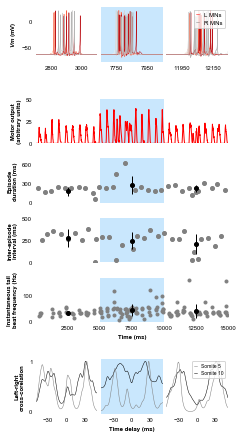

In [8]:
# Import pandas for data saving
import pandas as pd
import numpy as np
import json
from pylab import *
from Analysis_tools import *

results=[]
Epoch = 5000

# open swimming analysis results in .json file for each epoch
for i in range(0,3):
    names = "dI6_KO_results_epoch_" + str(i) + ".json"
    f = open(names,)
    results.append(json.load(f))

names = "dI6_KO_all_results.json"
f = open(names,)
all_results = json.load(f)

#open simulation results for V0v null model
read_data = pd.read_csv("Beat_and_Glide_dI6_KO.csv")
read_data

read_sim = np.ascontiguousarray(read_data)
read_sim = np.transpose(read_sim)
read_sim
Time = read_sim[0]
next_start = 1
next_end = next_start + nMN
VLMN = read_sim[1:next_end]
next_start = next_end
next_end = next_start + nMN
VRMN = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + ndI6
VLdI6 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + ndI6
VRdI6 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV0v
VLV0v = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV0v
VRV0v = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV2a
VLV2a = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV2a
VRV2a = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV1
VLV1 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV1
VRV1 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nMuscle
VLMuscle = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nMuscle
VRMuscle = read_sim[next_start:next_end]
TIME_END = Time[-1]
TIME_END

list_MNs = [int(nMN*i/4) for i in range(1,4)] #Plot 25th, 50th, and 75th neuron on rostrocaudal axis

#Declare the figure and subplots
figKO = plt.figure(constrained_layout=False, figsize=(3.6, 7.5))

widths = [12, 12, 12, 1]
heights = [2.5, 0.3, 2, 2, 2, 2, 0.3, 2.5]
gs = figKO.add_gridspec(nrows=8, ncols=4, width_ratios=widths, height_ratios=heights)

dt = 0.1 #discretization time

#FIRST, GRAPH VOLTAGE TRACES DURING THREE EPOCHS

fKO_ax0 = figKO.add_subplot(gs[0, 0])
fKO_ax1 = figKO.add_subplot(gs[0, 1])
fKO_ax2 = figKO.add_subplot(gs[0, 2])

nMN = 15

#Color maps
cmapBlue = matplotlib.cm.get_cmap('Blues')
cmapRed = matplotlib.cm.get_cmap('Reds')
cmapGreen = matplotlib.cm.get_cmap('Greens')
cmapRedPurple = matplotlib.cm.get_cmap('RdPu')
cmapGrey = matplotlib.cm.get_cmap('Greys')
cmapBrown = matplotlib.cm.get_cmap('YlOrBr')
cmapBrightGreen = matplotlib.cm.get_cmap('hsv') #in the range 0.2 to 0.4
    
# Line length and width    
LINELENGTH = 0.5
LINEWIDTH = 0.5

plt.rc('lines', linewidth=LINEWIDTH) 

# Change default font to Arial
matplotlib.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"

rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.bf'] = 'Arial:italic:bold'

#font size
SMALL_SIZE = 6

FONT_STYLE = 'bold'

MARKER_SIZE = 4

# plotting motoneuron traces for epoch 1
for k in list_MNs:
    lines_left, = fKO_ax0.plot(Time, VLMN[k,:], c=cmapRed((k+1)/nMN),linestyle='-') # adding a color gradient, lighter color -> rostrally located
    lines_right, = fKO_ax0.plot(Time, VRMN[k,:], c=cmapGrey((k+1)/nMN/2), linestyle='-')

lower_y = -80
upper_y = 30

fKO_ax0.set_ylabel(r"$\mathbf{Vm}$" + " (mV)", fontsize= SMALL_SIZE, fontweight=FONT_STYLE) #y-axis title
fKO_ax0.set_ylim([lower_y, upper_y])
#Remove borders
fKO_ax0.spines['top'].set_visible(False)
fKO_ax0.spines['right'].set_visible(False)
fKO_ax0.spines['bottom'].set_visible(False)
fKO_ax0.spines['left'].set_visible(False)
#tick parameters
fKO_ax0.tick_params(axis='both', which='both', length=0)
fKO_ax0.set_xticks([2800,3000])
fKO_ax0.set_yticks([i*50 + -50 for i in range(0,2)])
for item in (fKO_ax0.get_xticklabels() + fKO_ax0.get_yticklabels()):
    item.set_fontsize(SMALL_SIZE)
fKO_ax0.set_xlim([2700,  3100])

# plotting motoneuron traces for epoch 2
for k in list_MNs:
    lines_left, = fKO_ax1.plot(Time, VLMN[k,:], c=cmapRed((k+1)/nMN),linestyle='-') # adding a color gradient, lighter color -> rostrally located
    lines_right, = fKO_ax1.plot(Time, VRMN[k,:], c=cmapGrey((k+1)/nMN/2), linestyle='-')

fKO_ax1.set_ylim([lower_y, upper_y])
#Remove borders
fKO_ax1.spines['top'].set_visible(False)
fKO_ax1.spines['right'].set_visible(False)
fKO_ax1.spines['bottom'].set_visible(False)
fKO_ax1.spines['left'].set_visible(False)
#tick parameters
fKO_ax1.tick_params(axis='both', which='both', length=0)
fKO_ax1.set_xticks([7750,7950])
for item in (fKO_ax1.get_xticklabels()):
    item.set_fontsize(SMALL_SIZE)
fKO_ax1.set_xlim([7650,  8050])
fKO_ax1.set_yticks([])
fKO_ax1.axvspan(5000, 10000, facecolor='xkcd:light blue', alpha=0.5)

# plotting motoneuron traces
for k in list_MNs:
    lines_left, = fKO_ax2.plot(Time, VLMN[k,:], c=cmapRed((k+1)/nMN),linestyle='-') # adding a color gradient, lighter color -> rostrally located
    lines_right, = fKO_ax2.plot(Time, VRMN[k,:], c=cmapGrey((k+1)/nMN/2), linestyle='-')

fKO_ax2.set_ylim([lower_y, upper_y])
#Remove borders
fKO_ax2.spines['top'].set_visible(False)
fKO_ax2.spines['right'].set_visible(False)
fKO_ax2.spines['bottom'].set_visible(False)
fKO_ax2.spines['left'].set_visible(False)
#tick parameters
fKO_ax2.tick_params(axis='both', which='both', length=0)
fKO_ax2.set_xticks([11950,12150])
for item in (fKO_ax2.get_xticklabels()):
    item.set_fontsize(SMALL_SIZE)
fKO_ax2.set_xlim([11850,  12250])
fKO_ax2.set_yticks([])

# plotting motoneuron traces for epoch 3
for k in list_MNs:
    lines_left, = fKO_ax2.plot(Time, VLMN[k,:], c=cmapRed((k+1)/nMN),linestyle='-') # adding a color gradient, lighter color -> rostrally located
    lines_right, = fKO_ax2.plot(Time, VRMN[k,:], c=cmapGrey((k+1)/nMN/2), linestyle='-')
leg=fKO_ax2.legend(handles=[lines_left, lines_right], labels=['L MNs','R MNs'], loc='upper right', handlelength=LINELENGTH, fontsize=SMALL_SIZE)
leg.legendHandles[0].set_color('red')
leg.legendHandles[1].set_color('grey')

## PLOT MOTOR OUTPUT

fKO_ax3 = figKO.add_subplot(gs[2, 0:-1])
#Summate left and right muscle output
X = np.sum(VLMuscle, axis=0) + np.sum(VRMuscle, axis=0)
X = smooth(X, 500) #convolve with a step 50 ms wide
    
fKO_ax3.plot(Time, X, c='red', linewidth = 1)
fKO_ax3.set_ylabel('Motor output\n' + '(arbitrary units)', fontsize=SMALL_SIZE-1, fontweight = FONT_STYLE)
fKO_ax3.axvspan(5000, 10000, facecolor='xkcd:light blue', alpha=0.5)
fKO_ax3.set_xlim(0,15000) 
fKO_ax3.set_ylim(0,50)    

#Remove borders
fKO_ax3.spines['top'].set_visible(False)
fKO_ax3.spines['right'].set_visible(False)
fKO_ax3.spines['bottom'].set_visible(False)
fKO_ax3.spines['left'].set_visible(False)        
#Tick parameters
fKO_ax3.tick_params(axis='both', which='both', length=0)
fKO_ax3.set_xticks([])

for item in ([fKO_ax3.title, fKO_ax3.xaxis.label, fKO_ax3.yaxis.label] +
         fKO_ax3.get_xticklabels() + fKO_ax3.get_yticklabels()):
    item.set_fontsize(SMALL_SIZE)

## NOW PLOT EPISODE DURATION AND INTER-EPISODE DURATION
    
fKO_ax4 = figKO.add_subplot(gs[3, 0:-1])
fKO_ax5 = figKO.add_subplot(gs[4, 0:-1])

#Remove borders
fKO_ax4.spines['top'].set_visible(False)
fKO_ax4.spines['right'].set_visible(False)
fKO_ax4.spines['bottom'].set_visible(False)
fKO_ax4.spines['left'].set_visible(False)        
fKO_ax4.tick_params(axis='both', which='both', length=0)

for item in ([fKO_ax4.title, fKO_ax4.xaxis.label, fKO_ax4.yaxis.label] +
         fKO_ax4.get_xticklabels() + fKO_ax4.get_yticklabels()):
    item.set_fontsize(SMALL_SIZE)

#Remove borders        
fKO_ax5.spines['top'].set_visible(False)
fKO_ax5.spines['right'].set_visible(False)
fKO_ax5.spines['bottom'].set_visible(False)
fKO_ax5.spines['left'].set_visible(False)        
fKO_ax5.tick_params(axis='both', which='both', length=0)

for item in ([fKO_ax5.title, fKO_ax5.xaxis.label, fKO_ax5.yaxis.label] +
         fKO_ax5.get_xticklabels() + fKO_ax5.get_yticklabels()):
    item.set_fontsize(SMALL_SIZE)


#tick parameters
fKO_ax4.set_xticks([])
fKO_ax5.set_xticks([])
fKO_ax4.set_yticks([i*300 for i in range(0,5)])
fKO_ax5.set_yticks([i*250 for i in range(0,3)])

fKO_ax4.set_xlim([0, TIME_END])
fKO_ax5.set_xlim([0, TIME_END])

fKO_ax4.set_ylim([0, 700])
fKO_ax5.set_ylim([0, 500])

res = all_results['Events']['Duration (ms)']
time_start = all_results['Events']['Start times (ms)']

fKO_ax4.axvspan(5000, 10000, facecolor='xkcd:light blue', alpha=0.5)

#mean duration
dur_temp = [results[i]['Events']['Duration (ms)'] for i in range(0,3)]
mean_dur = [np.mean(dur_temp[i]) for i in range (0,3)]
std_dur = [np.std(dur_temp[i]) for i in range (0,3)]
x_mean_dur = [2500, 7500, 12500]

#plot mean duration
fKO_ax4.errorbar(x_mean_dur, mean_dur, yerr=std_dur, linestyle='None', color = 'black', marker='o', markersize=MARKER_SIZE, linewidth = 1.0, zorder=2)
#plot durations            
fKO_ax4.plot(time_start, res, 'o', color = 'gray', markersize=MARKER_SIZE, zorder=1)
fKO_ax4.set_ylabel('Episode\n' + 'duration (ms)', fontsize=SMALL_SIZE, fontweight = FONT_STYLE)

res = all_results['Events']['Inter-event intervals']
time_start = all_results['Events']['End times (ms)'][:-1]

fKO_ax5.axvspan(5000, 10000, facecolor='xkcd:light blue', alpha=0.5)

#mean inter-event intervals
dur_temp = [results[i]['Events']['Inter-event intervals'] for i in range(0,3)]
mean_dur = [np.mean(dur_temp[i]) for i in range (0,3)]
std_dur = [np.std(dur_temp[i]) for i in range (0,3)]
x_mean_dur = [2500, 7500, 12500]

#plot mean inter-event intervals
fKO_ax5.errorbar(x_mean_dur, mean_dur, yerr=std_dur, linestyle='None', color = 'black', marker='o', markersize=MARKER_SIZE, linewidth = 1.0,  zorder=2)
#plot inter-event intervals
fKO_ax5.plot(time_start, res, 'o', color = 'gray', markersize=MARKER_SIZE, zorder=1)
fKO_ax5.set_ylabel('Inter-episode\n' + 'interval (ms)', fontsize=SMALL_SIZE, fontweight = FONT_STYLE)


### Instantaneous frequency

num_tail_beats, interbeat_intervals, start_times, beat_times = calc_tail_beat_freq(VRMuscle, VLMuscle, nmax = len(Time), 
                                                        dt = 0.1, lower_bound = -0.5, upper_bound = 0.5, delay = 500)

fKO_ax6 = figKO.add_subplot(gs[5, 0:-1])
fKO_ax6.set_xlabel('Time (ms)', fontsize=SMALL_SIZE, fontweight = FONT_STYLE)

fKO_ax6.spines['top'].set_visible(False)
fKO_ax6.spines['right'].set_visible(False)
fKO_ax6.spines['bottom'].set_visible(False)
fKO_ax6.spines['left'].set_visible(False)        
fKO_ax6.tick_params(axis='both', which='both', length=0)

freq_temp = [results[i]['Average frequency']['Instantaneous frequency (Hz)'] for i in range(0,3)]
mean_freq = [np.nanmean(freq_temp[i]) for i in range (0,3)]
std_freq = [np.nanstd(freq_temp[i]) for i in range (0,3)]
x_mean_freq = [2500, 7500, 12500]

res = all_results['Average frequency']['Instantaneous frequency (Hz)']
time_start = all_results['Average frequency']['Beat times(ms)']

fKO_ax6.plot(time_start, res, 'o', color = 'gray', markersize=MARKER_SIZE-1, zorder=1)
fKO_ax6.set_ylabel('Instantaneous tail\n' + 'beat frequency (Hz)', fontsize=SMALL_SIZE-1, fontweight = FONT_STYLE)

for item in ([fKO_ax6.title, fKO_ax6.xaxis.label, fKO_ax6.yaxis.label] +
         fKO_ax6.get_xticklabels() + fKO_ax6.get_yticklabels()):
    item.set_fontsize(SMALL_SIZE)

fKO_ax6.set_xlim([0, TIME_END])
fKO_ax6.set_xticks([i*2500 for i in range(1,7)])

fKO_ax6.axvspan(5000, 10000, facecolor='xkcd:light blue', alpha=0.5)
fKO_ax6.set_xlabel('Time (ms)', fontsize=SMALL_SIZE, fontweight = FONT_STYLE)
            
fKO_ax6.errorbar(x_mean_freq, mean_freq, yerr=std_freq, linestyle='None', color = 'black', marker='o', markersize=MARKER_SIZE, linewidth = 1.0,  zorder=2)

# Left right correlation
Duration_of_condition=5000
for i in range(0,3):
    #calculate left-right correlation for somites 4 and 9
    Somite_index = 9
    res10 = Xcorr_LR(VLMuscle[Somite_index,Duration_of_condition*10*i:Duration_of_condition*10*(i+1)],VRMuscle[Somite_index,Duration_of_condition*10*i:Duration_of_condition*10*(i+1)])
    Somite_index = 4
    res5 = Xcorr_LR(VLMuscle[Somite_index,Duration_of_condition*10*i:Duration_of_condition*10*(i+1)],VRMuscle[Somite_index,Duration_of_condition*10*i:Duration_of_condition*10*(i+1)])

    
    fKO_LR = figKO.add_subplot(gs[-1, i])
    
    right_side = fKO_LR.spines["right"]
    top_side = fKO_LR.spines["top"]
    right_side.set_visible(False)
    top_side.set_visible(False)

    New_time = Time[0:Duration_of_condition*10].tolist()+(-Time[0:Duration_of_condition*10]).tolist()
    order = np.argsort(New_time)
    New_time= np.asarray(New_time)[order]

    #plot left-right correlation for somites 4 and 9
    line_somite10, = fKO_LR.plot(New_time[1:Duration_of_condition*20], res10, '-k',  c='black')
    line_somite5, =fKO_LR.plot(New_time[1:Duration_of_condition*20], res5, '-k', c='grey')
    
    if i == 2:
        leg_LR=fKO_LR.legend(handles=[line_somite5, line_somite10], labels=['Somite 5','Somite 10'], loc='upper right', handlelength=LINELENGTH, fontsize = SMALL_SIZE-1)
        leg_LR.legendHandles[0].set_color('grey')
        leg_LR.legendHandles[1].set_color('black')

    fKO_LR.set_xlim([-50,50])

    fKO_LR.spines['top'].set_visible(False)
    fKO_LR.spines['right'].set_visible(False)
    fKO_LR.spines['bottom'].set_visible(False)
    fKO_LR.spines['left'].set_visible(False)
    fKO_LR.tick_params(axis='both', which='both', length=0)
    for item in ([fKO_LR.title, fKO_LR.xaxis.label, fKO_LR.yaxis.label] +
             fKO_LR.get_xticklabels() + fKO_LR.get_yticklabels()):
        item.set_fontsize(SMALL_SIZE)
    fKO_LR.set_xticks([-30,0,30])
    if i > 0:
        fKO_LR.set_yticks([])
    if i == 0:
        fKO_LR.set_ylabel('Left-right\n' + 'cross-corelation', fontsize = SMALL_SIZE, fontweight = FONT_STYLE)
        
    if i == 1:
        fKO_LR.set_xlabel('Time delay (ms)', fontsize = SMALL_SIZE, fontweight = FONT_STYLE)
        fKO_LR.axvspan(-50, 50, facecolor='xkcd:light blue', alpha=0.5)


plt.subplots_adjust(hspace=0.4, wspace=0.075)
plt.savefig('dI6_KO.png', dpi=1000)
plt.show()

### Figure 6 - figure supplement 1F-J - membrane potentials for dI6 null

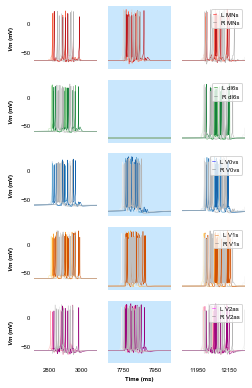

In [9]:
# Import pandas for data saving
import pandas as pd
import numpy as np
from pylab import *
from Analysis_tools import *

read_data = pd.read_csv("Beat_and_Glide_dI6_KO.csv")
read_data

read_sim = np.ascontiguousarray(read_data)
read_sim = np.transpose(read_sim)
read_sim
Time = read_sim[0]
next_start = 1
next_end = next_start + nMN
VLMN = read_sim[1:next_end]
next_start = next_end
next_end = next_start + nMN
VRMN = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + ndI6
VLdI6 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + ndI6
VRdI6 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV0v
VLV0v = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV0v
VRV0v = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV2a
VLV2a = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV2a
VRV2a = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV1
VLV1 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV1
VRV1 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nMuscle
VLMuscle = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nMuscle
VRMuscle = read_sim[next_start:next_end]
TIME_END = Time[-1]
TIME_END

#list cell traces to plot
list_MNs = [int(nMN*i/4) for i in range(1,4)] #Plot 25th, 50th, and 75th neuron on rostrocaudal axis
list_dI6s = [int(ndI6*i/4) for i in range(1,4)]
list_V0vs = [int(nV0v*i/4) for i in range(1,4)] #Plot 25th, 50th, and 75th neuron on rostrocaudal axis
list_V2as = [int(nV2a*i/4) for i in range(1,4)] #Plot 25th, 50th, and 75th neuron on rostrocaudal axis
list_V1s = [int(nV1*i/4) - 1 for i in range(1,4) if 0 < int(nMN*i/4) - 1 < nV1] #Plot 25th, 50th, and 75th neuron on rostrocaudal axis

#list_dI6s = [int(nMN*i/4) for i in range(1,4) if int(nMN*i/4) < ndI6]
#list_V0vs = [int(nMN*i/4) for i in range(1,4) if int(nMN*i/4) < nV0v] #Plot 25th, 50th, and 75th neuron on rostrocaudal axis
#list_V2as = [int(nMN*i/4) - 2 for i in range(1,4) if 0 < int(nMN*i/4) - 2 < nV2a] #Plot 25th, 50th, and 75th neuron on rostrocaudal axis
#list_V1s = [int(nMN*i/4) - 4 for i in range(1,4) if 0 < int(nMN*i/4) - 4 < nV1] #Plot 25th, 50th, and 75th neuron on rostrocaudal axis

#color maps
cmapBlue = matplotlib.cm.get_cmap('Blues')
cmapRed = matplotlib.cm.get_cmap('Reds')
cmapGreen = matplotlib.cm.get_cmap('Greens')
cmapRedPurple = matplotlib.cm.get_cmap('RdPu')
cmapGrey = matplotlib.cm.get_cmap('Greys')
cmapBrown = matplotlib.cm.get_cmap('YlOrBr')
cmapYellow = matplotlib.cm.get_cmap('YlOrBr')
cmapBrightGreen = matplotlib.cm.get_cmap('hsv') #in the range 0.2 to 0.4

#declare figure
fig_KO, ax = plt.subplots(5, 3, figsize=(3.6, 5.5))

LINELENGTH = 0.5
LINEWIDTH = 0.5

# Change default font to Arial
matplotlib.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"

rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.bf'] = 'Arial:italic:bold'

plt.rc('lines', linewidth=LINEWIDTH) 

#font size and style
SMALL_SIZE = 6

FONT_STYLE = 'bold'

x_starts = [2700, 7650, 11850]
x_ends = [3100, 8050, 12250]

for j in range(0, 3): #cycle through three epochs
    # plotting motoneuron traces
    for k in list_MNs: #plot MN traces
        lines_left, = ax[0,j].plot(Time, VLMN[k,:], c=cmapRed((k+1)/nMN),linestyle='-') # adding a color gradient, lighter color -> rostrally located
        lines_right, = ax[0,j].plot(Time, VRMN[k,:], c=cmapGrey((k+1)/nMN/2), linestyle='-')
    if j == 2: #add legend in the third panel
        leg=ax[0,j].legend(handles=[lines_left, lines_right], labels=['L MNs','R MNs'], loc='upper right', handlelength=LINELENGTH, fontsize=SMALL_SIZE)
        leg.legendHandles[0].set_color('red')
        leg.legendHandles[1].set_color('grey')
        for line in leg.get_lines():
            line.set_linewidth(LINEWIDTH)

    #y-axis limits
    lower_y = -80
    upper_y = 30
    # set-up for all five rows of the plot
    for i in range (0,5):
        if j == 0:
            ax[i,j].set_ylabel(r"$\mathbf{Vm}$" + " (mV)", fontsize= SMALL_SIZE, fontweight=FONT_STYLE)
            ax[i,j].set_yticks([i*50 + -50 for i in range(0,2)])
            ax[i,j].set_ylim([lower_y, upper_y])
        else:
            ax[i,j].tick_params(labelleft=False) 
        #remove borders
        ax[i,j].spines['top'].set_visible(False)
        ax[i,j].spines['right'].set_visible(False)
        ax[i,j].spines['bottom'].set_visible(False)
        ax[i,j].spines['left'].set_visible(False)
        # tick parameters
        ax[i,j].tick_params(axis='both', which='both', length=0)
        ax[i,j].set_xticks([])
        ax[i,j].set_xlim(x_starts[j], x_ends[j])
        for item in ([ax[i,j].title, ax[i,j].xaxis.label, ax[i,j].yaxis.label] +
                 ax[i,j].get_xticklabels() + ax[i,j].get_yticklabels()):
            item.set_fontsize(SMALL_SIZE)
        if j == 1:
            ax[i,1].axvspan(5000, 10000, facecolor='xkcd:light blue', alpha=0.5) #blue background for epoch 2

    # plotting dI6
    cmapL = matplotlib.cm.get_cmap('Blues')
    cmapR = matplotlib.cm.get_cmap('Reds')
    ax[1,j].plot([0], [0], c=cmapL(0.5))
    ax[1,j].plot([0], [0], c=cmapR(0.5))    

    for k in list_dI6s:
        lines_left, = ax[1,j].plot(Time, VLdI6[k,:], c=cmapGreen((k+1)/ndI6), linestyle='-') 
        lines_right, = ax[1,j].plot(Time, VRdI6[k,:], c=cmapGrey((k+1)/ndI6/2), linestyle='-')
    if j == 2:
        leg=ax[1,j].legend(handles=[lines_left, lines_right], labels=['L dI6s','R dI6s'], loc='upper right', handlelength=LINELENGTH, fontsize=SMALL_SIZE)
        leg.legendHandles[0].set_color('green')
        leg.legendHandles[1].set_color('grey')
        for line in leg.get_lines():
            line.set_linewidth(LINEWIDTH)

    # plotting V0v
    for k in list_V0vs:
        lines_left, = ax[2,j].plot(Time, VLV0v[k,:], c=cmapL((k+1)/nV0v)) 
        lines_right, = ax[2,j].plot(Time, VRV0v[k,:], c=cmapGrey((k+1)/nV0v/2))
    if j == 2:
        leg=ax[2,j].legend(handles=[lines_left, lines_right], labels=['L V0vs','R V0vs'], loc='upper right', handlelength=LINELENGTH, fontsize=SMALL_SIZE)
        leg.legendHandles[0].set_color('blue')
        leg.legendHandles[1].set_color('grey')
        for line in leg.get_lines():
            line.set_linewidth(LINEWIDTH)
    
    # plotting V1
    for k in list_V1s:
        ax[3,j].plot(Time, VLV1[k,:], c=cmapYellow((k+1)/nV1), linestyle='-') 
        ax[3,j].plot(Time, VRV1[k,:], c=cmapGrey((k+1)/nV1/2), linestyle='-')
    if j == 2:
        leg=ax[3,j].legend(handles=[lines_left, lines_right], labels=['L V1s','R V1s'], loc='upper right', handlelength=LINELENGTH, fontsize=SMALL_SIZE)
        leg.legendHandles[0].set_color(cmapYellow(0.6))
        leg.legendHandles[1].set_color('grey')
        for line in leg.get_lines():
            line.set_linewidth(LINEWIDTH)
        
    # plotting V2a
    for k in list_V2as:
        lines_left, = ax[4,j].plot(Time, VLV2a[k,:], c=cmapRedPurple((k+1)/nV2a), linestyle='-') 
        lines_right, = ax[4,j].plot(Time, VRV2a[k,:], c=cmapGrey((k+1)/nV2a/2), linestyle='-')
    if j == 2:
        leg=ax[4,j].legend(handles=[lines_left, lines_right], labels=['L V2as','R V2as'], loc='upper right', handlelength=LINELENGTH, fontsize=SMALL_SIZE)
        leg.legendHandles[0].set_color('magenta')
        leg.legendHandles[1].set_color('grey')
        for line in leg.get_lines():
            line.set_linewidth(LINEWIDTH)
            
ax[4,0].set_xticks([2800, 3000])
ax[4,1].set_xticks([7750, 7950])
ax[4,2].set_xticks([11950, 12150])

for k in range(0,3):
    for item in (ax[4,k].get_xticklabels()):
        item.set_fontsize(SMALL_SIZE)          
ax[4, 1].set_xlabel('Time (ms)', fontsize = SMALL_SIZE, fontweight = FONT_STYLE)

plt.tight_layout()
plt.savefig('dI6_KO_Suppl_Fig.png', dpi=1000)
plt.show()

### Figure 6 - figure suppplement 2 - Midlines and histogram for dI6 null with 30 somites

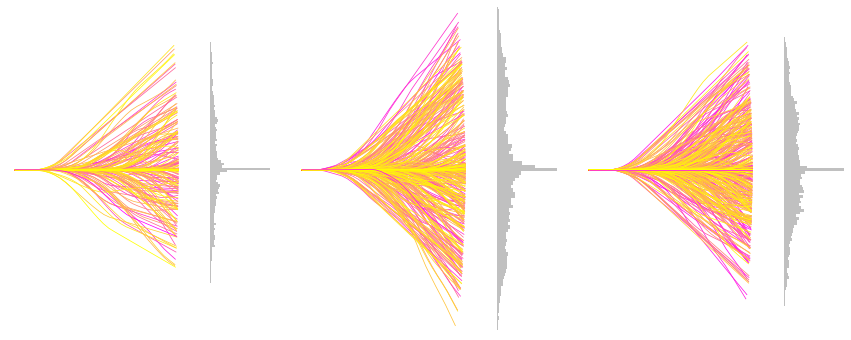

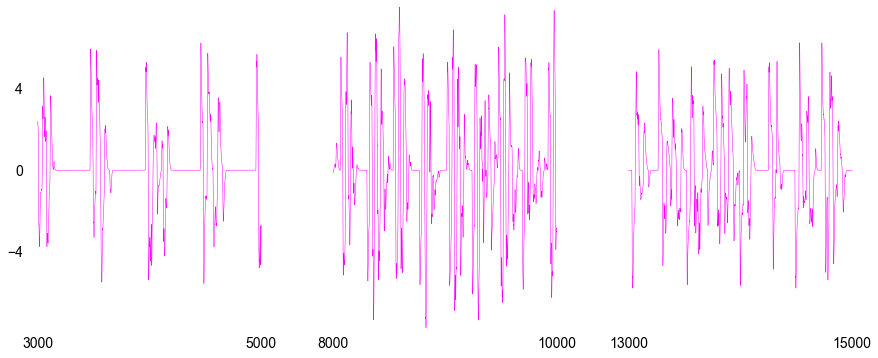

In [10]:
%matplotlib inline
# Import pandas for data saving
import pandas as pd
import numpy as np
import scipy.stats as stats
from pylab import *
from Analysis_tools import *

# Change default font to Arial
matplotlib.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"

rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.bf'] = 'Arial:italic:bold'

matplotlib.rcParams.update({'font.size': 14})

#This function computes midlines
def compute_midlines(Time, angle):
    
    midlines = []
    all_X = []
    all_Y = []
    for i,t in enumerate(Time):
        X = [np.cos(np.sum(angle[i,:j])) for j in range(len(angle[i]))]
        X = [np.sum(X[:i]) for i in range(len(X))]
        Y = [np.sin(np.sum(angle[i,:j])) for j in range(len(angle[i]))]
        Y = [np.sum(Y[:i]) for i in range(len(Y))]

        all_X.append(X)
        all_Y.append(Y)
        midlines.append((X,Y)) 
    
    return midlines, all_X, all_Y

read_data = pd.read_csv("Beat_and_Glide_30_somites_dI6_KO.csv")
read_data

data_top = list(read_data.columns.values.tolist())
data_top

MN_index = []
dI6_index = [] 
V0v_index = []  
V2a_index = [] 
V1_index = []
Muscle_index = []

for i in range(0, len(data_top)):
    if (data_top[i].find('MN') != -1):
        MN_index.append(int(data_top[i][data_top[i].find('MN')+2:data_top[i].find('MN')+4]))
        nMN = max(MN_index) + 1
    if (data_top[i].find('dI6') != -1):
        dI6_index.append(int(data_top[i][data_top[i].find('dI6')+3:data_top[i].find('dI6')+5]))
        ndI6 = max(dI6_index) + 1
    if (data_top[i].find('V0v') != -1):
        V0v_index.append(int(data_top[i][data_top[i].find('V0v')+3:data_top[i].find('V0v')+5]))
        nV0v = max(V0v_index) + 1
    if (data_top[i].find('V2a') != -1):
        V2a_index.append(int(data_top[i][data_top[i].find('V2a')+3:data_top[i].find('V2a')+5]))
        nV2a = max(V2a_index) + 1
    if (data_top[i].find('V1') != -1):
        V1_index.append(int(data_top[i][data_top[i].find('V1')+2:data_top[i].find('V1')+4]))
        nV1 = max(V1_index) + 1
    if (data_top[i].find('Muscle') != -1):
        Muscle_index.append(int(data_top[i][data_top[i].find('Muscle')+6:data_top[i].find('Muscle')+8]))
        nMuscle = max(Muscle_index) + 1

read_sim = np.ascontiguousarray(read_data)
read_sim = np.transpose(read_sim)
read_sim
Time = read_sim[0]
next_start = 1
next_end = next_start + nMN
VLMN = read_sim[1:next_end]
next_start = next_end
next_end = next_start + nMN
VRMN = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + ndI6
VLdI6 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + ndI6
VRdI6 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV0v
VLV0v = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV0v
VRV0v = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV2a
VLV2a = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV2a
VRV2a = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV1
VLV1 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV1
VRV1 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nMuscle
VLMuscle = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nMuscle
VRMuscle = read_sim[next_start:next_end]
TIME_END = Time[-1]
TIME_END

dt = 0.1 # discretization time

# Line length and width
LINELENGTH = 0.5
LINEWIDTH = 0.75

# font size
SMALL_SIZE = 7
MEDIUM_SIZE = 16
BIGGER_SIZE = 6
STANDARD_FONT_SIZE = 7

FONT_STYLE = 'bold'

### Calculate angles

vmin_=-0.1 
vmax_=0.1

nmax = len(VLMuscle[0,:])
nMuscle = len(VLMuscle[:,0])

# Allocating arrays for velocity and position
vel = np.zeros((nMuscle, nmax))
pos = np.zeros((nMuscle, nmax))

# Setting constants and initial values for vel. and pos.
khi = 3.0  #damping cste , high khi =0.5/ low = 0.1
w0 = 2.5 #2.5  #20Hz = 125.6
vel0 = 0.0
pos0 = 0.0
Wd = w0

for k in range (0,nMuscle):
    vel[k,0] = vel0    #Sets the initial velocity
    pos[k,0] = pos0    #Sets the initial position
    pos[nMuscle-1,0] = 0.0
    for i in range(1,nmax):

        vel[k,i] = -(w0**2)*pos[k,i-1]*dt + vel[k,i-1]*(1-(2*dt*khi*w0)) + 0.1*VRMuscle[k,i-1]*dt - 0.1*VLMuscle[k,i-1]*dt
        pos[k,i] = dt*vel[k,i-1] + pos[k,i-1]

pos2 = pos.transpose()
angle = pos2

fig, ax = plt.subplots(1,6, gridspec_kw={'width_ratios': [3, 1,3,1,3,1]}, frameon=False, figsize=(15, 6))


start_times = [0, 5000, 10000]
end_times = [5000, 10000, 15000]

EPOCH_SIZE = 50000
for i in range(0, 3): #compute midlines for each epoch

    midlines, all_X, all_Y = compute_midlines(Time[start_times[i]*10:end_times[i]*10], angle[start_times[i]*10:end_times[i]*10])

    for side in ["top", "right", "bottom", "left"]:
        ax[i*2].spines[side].set_visible(False)

    time_min = start_times[i]#5000*i
    time_max = end_times[i]#5000*(i+1)
    #CONSTANTS
    nMIDLINES = int((time_max-time_min)/10)
    INTERVAL = 10
    MAP='spring' # choose carefully, or color transitions will not appear smoooth

    # Choose a color map, loop through the colors, and assign them to the color 
    # cycle. You need NPOINTS-1 colors, because you'll plot that many lines 
    # between pairs. In other words, your line is not cyclic, so there's 
    # no line from end to beginning
    cm = plt.get_cmap(MAP)
    #ax0.set_prop_cycle(color=[cm(1.*i/(NPOINTS-1)) for i in range(NPOINTS-1)])
    ax[i*2].set_prop_cycle(color=[cm(1.*i/(nMIDLINES-1)) for i in range(nMIDLINES-1)])

    for j,t in enumerate(Time[time_min*10:time_max*10]):
        if t%INTERVAL == 0:
            (X,Y) = midlines[j]
            ax[i*2].plot(X, Y, linewidth = LINEWIDTH)
    ax[i*2].set_xticks([])
    ax[i*2].set_yticks([])
    ax[i*2].set_ylim([-8, 8])

    # Plot histogram of terminal coordinates
    all_Y_terminals = [all_Y[i][-1] for i in range (len(all_Y))]
    ax[i*2+1].hist(all_Y_terminals, weights=np.ones(len(all_Y_terminals)) / len(all_Y_terminals), bins=100, color='silver', orientation='horizontal') # histogram of the last segment to get the density
    max_ = np.max(all_Y_terminals)
    min_ = np.min(all_Y_terminals)
    ax[i*2+1].axis('off')
    ax[i*2+1].set_xlim([0, 0.05])
    ax[i*2+1].set_ylim([-8, 8])
    ax[i*2+1].set_xticks([0, 0.025, 0.05])
    ax[i*2+1].set_yticks([-4, 4])
    
plt.savefig('dI6_KO_30_somites_midlines_and_histogram.png', dpi=1000)
plt.show()
    
fig, ax = plt.subplots(1,3, gridspec_kw={'width_ratios': [1,1,1]}, frameon=False, figsize=(15, 6))

for i in range(0, 3):

    midlines, all_X, all_Y = compute_midlines(Time[start_times[i]*10:end_times[i]*10], angle[start_times[i]*10:end_times[i]*10])

    for side in ["top", "right", "bottom", "left"]:
        ax[i].spines[side].set_visible(False)

    time_min = start_times[i]#5000*i
    time_max = end_times[i]#5000*(i+1)
    #CONSTANTS
    nMIDLINES = int((time_max-time_min)/10)
    INTERVAL = 10
    MAP='spring' # choose carefully, or color transitions will not appear smoooth

    # Choose a color map, loop through the colors, and assign them to the color 
    # cycle. You need NPOINTS-1 colors, because you'll plot that many lines 
    # between pairs. In other words, your line is not cyclic, so there's 
    # no line from end to beginning
    cm = plt.get_cmap(MAP)
    #ax0.set_prop_cycle(color=[cm(1.*i/(NPOINTS-1)) for i in range(NPOINTS-1)])
    ax[i].set_prop_cycle(color=[cm(1.*i/(nMIDLINES-1)) for i in range(nMIDLINES-1)])

    for j,t in enumerate(Time[time_min*10:time_max*10]):
        if t%INTERVAL == 0:
            (X,Y) = midlines[j]

    # Plot histogram of terminal coordinates
    all_Y_terminals = [all_Y[i][-1] for i in range (len(all_Y))]
    ax[i].plot(Time[(time_min+3000)*10:time_max*10], all_Y_terminals[EPOCH_SIZE-20000:EPOCH_SIZE], linewidth = 0.5)
    ax[i].set_xticks([time_min+3000+2000*i for i in range(0,2)])
    if i == 0:
        ax[i].set_yticks([-4,0,4])
    else:
        ax[i].set_yticks([])
    ax[i].set_ylim([-8, 8])
    ax[i].tick_params(axis='both', which='both', length=0)


plt.savefig('dI6_KO_30_somites_y_coordinates.png', dpi=1000)
plt.show()

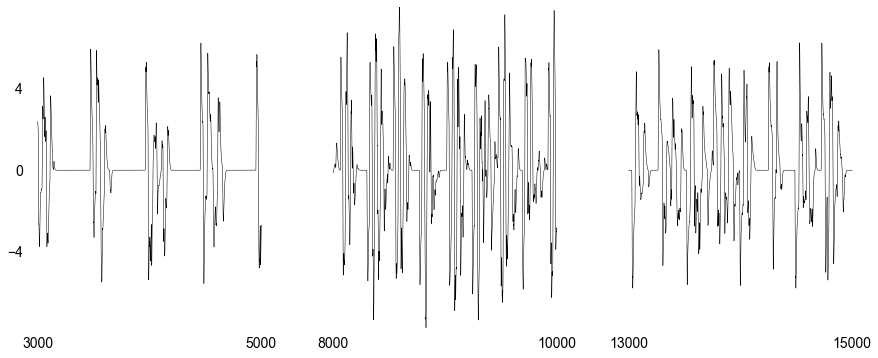

In [37]:
cmapGray = matplotlib.cm.get_cmap('gray')
fig, ax = plt.subplots(1,3, gridspec_kw={'width_ratios': [1,1,1]}, frameon=False, figsize=(15, 6))

for i in range(0, 3):

    midlines, all_X, all_Y = compute_midlines(Time[start_times[i]*10:end_times[i]*10], angle[start_times[i]*10:end_times[i]*10])

    for side in ["top", "right", "bottom", "left"]:
        ax[i].spines[side].set_visible(False)

    time_min = start_times[i]#5000*i
    time_max = end_times[i]#5000*(i+1)
    #CONSTANTS
    nMIDLINES = int((time_max-time_min)/10)
    INTERVAL = 10
    MAP='spring' # choose carefully, or color transitions will not appear smoooth

    # Choose a color map, loop through the colors, and assign them to the color 
    # cycle. You need NPOINTS-1 colors, because you'll plot that many lines 
    # between pairs. In other words, your line is not cyclic, so there's 
    # no line from end to beginning
    #cm = plt.get_cmap(MAP)
    #ax[i].set_prop_cycle(color=[cm(1.*i/(nMIDLINES-1)) for i in range(nMIDLINES-1)])

    for j,t in enumerate(Time[time_min*10:time_max*10]):
        if t%INTERVAL == 0:
            (X,Y) = midlines[j]


    all_Y_terminals = [all_Y[i][-1] for i in range (len(all_Y))]
    ax[i].plot(Time[(time_min+3000)*10:time_max*10], all_Y_terminals[EPOCH_SIZE-20000:EPOCH_SIZE], linewidth = 0.5, c = cmapGray(0))
    ax[i].set_xticks([time_min+3000+2000*i for i in range(0,2)])
    if i == 0:
        ax[i].set_yticks([-4,0,4])
    else:
        ax[i].set_yticks([])
    ax[i].set_ylim([-8, 8])
    ax[i].tick_params(axis='both', which='both', length=0)

#fig.tight_layout()
plt.savefig('dI6_KO_30_somites_y_coordinates.png', dpi=1000)
plt.show()

### Figure 7 - Strychine

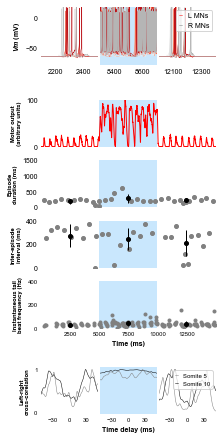

F_onewayResult(statistic=2.464298567977612, pvalue=0.10269880162642743)
31
Ttest_indResult(statistic=-1.9234896642201993, pvalue=0.06953370888492406)
Ttest_indResult(statistic=1.0936131086016128, pvalue=0.2877965266743939)
Ttest_indResult(statistic=-1.513726998520896, pvalue=0.1457386098523365)
F_onewayResult(statistic=0.9126007419950555, pvalue=0.41395715412692163)
28
Ttest_indResult(statistic=0.6219071081650831, pvalue=0.5422544112132888)
Ttest_indResult(statistic=0.7038875328247323, pvalue=0.49103270798988696)
Ttest_indResult(statistic=1.3233646127274847, pvalue=0.20227838572435264)
F_onewayResult(statistic=2.5868728604162916, pvalue=0.07874935358463647)
146
Ttest_indResult(statistic=-2.6244537278871536, pvalue=0.01014523430238412)
Ttest_indResult(statistic=1.0013746920484123, pvalue=0.3187664885959744)
Ttest_indResult(statistic=-1.275733398269193, pvalue=0.2056961600504427)


'\nSTATS FOR STRYCHNINE\n\nEPISODE DURATION\nF_onewayResult(statistic=25.00198645852743, pvalue=2.1663490366893403e-06)\n24\nTtest_indResult(statistic=-4.949468115138222, pvalue=0.00026568780796932374)\nTtest_indResult(statistic=5.109471156165166, pvalue=0.00020038854431112348)\nTtest_indResult(statistic=0.7265034026511731, pvalue=0.47687243141129076)\n\nINTER-EPISODE INTERVALS\nF_onewayResult(statistic=32.00224533011943, pvalue=8.254563522402112e-07)\n21\nTtest_indResult(statistic=5.9588305306833504, pvalue=9.470896969446267e-05)\nTtest_indResult(statistic=-9.232463674007038, pvalue=1.6321607446749463e-06)\nTtest_indResult(statistic=-1.0792811888422678, pvalue=0.2964643805590475)\n\nINSTANTANEOUS TAIL BEAT FREQUENCY\nF_onewayResult(statistic=8.31399919684361, pvalue=0.0003147973121725655)\n267\nTtest_indResult(statistic=-3.2782809537758353, pvalue=0.0012099188742072796)\nTtest_indResult(statistic=2.553295583914268, pvalue=0.011341504640895238)\nTtest_indResult(statistic=-1.01375355489

In [11]:
# Import pandas for data saving
import pandas as pd
import numpy as np
import scipy.stats as stats
from pylab import *
from Analysis_tools import *

# read data from strychnine stimulation
read_data = pd.read_csv("Beat_and_Glide_strychnine.csv")
read_data

data_top = list(read_data.columns.values.tolist())
data_top

MN_index = []
dI6_index = [] 
V0v_index = []  
V2a_index = [] 
V1_index = []
Muscle_index = []

for i in range(0, len(data_top)):
    if (data_top[i].find('MN') != -1):
        MN_index.append(int(data_top[i][data_top[i].find('MN')+2:data_top[i].find('MN')+4]))
        nMN = max(MN_index) + 1
    if (data_top[i].find('dI6') != -1):
        dI6_index.append(int(data_top[i][data_top[i].find('dI6')+3:data_top[i].find('dI6')+5]))
        ndI6 = max(dI6_index) + 1
    if (data_top[i].find('V0v') != -1):
        V0v_index.append(int(data_top[i][data_top[i].find('V0v')+3:data_top[i].find('V0v')+5]))
        nV0v = max(V0v_index) + 1
    if (data_top[i].find('V2a') != -1):
        V2a_index.append(int(data_top[i][data_top[i].find('V2a')+3:data_top[i].find('V2a')+5]))
        nV2a = max(V2a_index) + 1
    if (data_top[i].find('V1') != -1):
        V1_index.append(int(data_top[i][data_top[i].find('V1')+2:data_top[i].find('V1')+4]))
        nV1 = max(V1_index) + 1
    if (data_top[i].find('Muscle') != -1):
        Muscle_index.append(int(data_top[i][data_top[i].find('Muscle')+6:data_top[i].find('Muscle')+8]))
        nMuscle = max(Muscle_index) + 1

read_sim = np.ascontiguousarray(read_data)
read_sim = np.transpose(read_sim)
read_sim
Time = read_sim[0]
next_start = 1
next_end = next_start + nMN
VLMN = read_sim[1:next_end]
next_start = next_end
next_end = next_start + nMN
VRMN = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + ndI6
VLdI6 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + ndI6
VRdI6 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV0v
VLV0v = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV0v
VRV0v = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV2a
VLV2a = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV2a
VRV2a = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV1
VLV1 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV1
VRV1 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nMuscle
VLMuscle = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nMuscle
VRMuscle = read_sim[next_start:next_end]
TIME_END = Time[-1]
TIME_END

# This function detects start and ends of swimming episodes and then calculates episode durations.  The value of Threshold
# can change these values

def detect_event(VLMuscle, VRMuscle, Time, Threshold):
    
    X = np.sum(VLMuscle, axis=0) + np.sum(VRMuscle, axis=0)
    X = smooth(X, 500) #convolve with a step 50 ms wide
    Xt = Time[np.where(X > Threshold)]
    
    plt.plot(Time, X)
    plt.axhline(y=Threshold, ls='--', c='r')

    if not any(Xt):
        end =[]
        start=[]
        duration = []
    else:
        end = Xt[[Xt[i+1] - Xt[i] > 0.2 for i in range(len(Xt)-1)]+[True]]
        start = Xt[[True]+[Xt[i+1] - Xt[i] > 0.2 for i in range(len(Xt)-1)]]
        duration = end - start
        
    
    return start, end, duration

#Function to add nan to empty elements
def cure_array(tmp_):
    tmp__ = []
    for x in tmp_:
        if len(x) == 0:
            tmp__.append(np.nan)
        else:
            tmp__.append(x[0])
    return tmp__

# This function calculates autocorrelations, left right correlations and  calls detect_events for all somites of a simulation
def BnG_pattern_analysis(Time, VLMuscle, VRMuscle, Thresh):
    DT = 0.1
    nMuscle = len(VLMuscle)
    res_t_d = [(Xcorr(VLMuscle[i,:],VLMuscle[i-9,:])[0:int(150/DT)]).tolist() 
               for i in range(9, nMuscle)] # Time delay
    res_l_r = [(Xcorr(VLMuscle[i,:],VRMuscle[i,:])[0:int(150/DT)]).tolist() 
               for i in range(nMuscle)] # Left/Right cross correlogram
    res_a_c = [(Xcorr(VLMuscle[i,:],VLMuscle[i,:])[int(10/DT):int(150/DT)]).tolist()
               for i in range(nMuscle)] # auto-correlation removing 10 first ms (otherwise max is at 0 ms) and up to 150 ms
    Start, End, Duration = detect_event(VLMuscle, VRMuscle, Time, Threshold=Thresh)
    values_t_d = [Time[0:int(150/DT)][np.where(res==np.max(res))[0]] / 9. for res in res_t_d]
    values_t_d = cure_array(values_t_d)
    values_l_r = [ Time[0:int(150/DT)][np.where(res==np.max(res))[0]] for res in res_l_r ]
    values_l_r = cure_array(values_l_r)
    values_a_c = [ Time[int(10/DT):int(150/DT)][np.where(res==np.max(res))[0]] for res in res_a_c]
    values_a_c = cure_array(values_a_c)
    num_tail_beats, interbeat_intervals, start_times, beat_times = calc_tail_beat_freq(VRMuscle, VLMuscle, nmax = len(Time), 
                                                    dt = 0.1, lower_bound = -0.5, upper_bound = 0.5, delay = 1000)
    inst_freq = [1000/interbeat_intervals[i] if not np.isnan(interbeat_intervals[i]) else math.nan for i in range(0, len(interbeat_intervals))]

    if Start == 'No event detected':
        iei = 'No event detected'
    else:    
        iei = [Start[i+1] - End[i] for i in range(len(End)-1)]
    dict_res_sensitivity = {}
    dict_res_sensitivity['Ipsilateral delay'] = {'Cross-correlation curve delta 9 somites' : (Time.tolist(),res_t_d),
                                                     'Computed time delay per somite (ms)': values_t_d }
    dict_res_sensitivity['Left/Right alt. delay'] = {'Cross-correlation curve' : (Time.tolist(),res_l_r),
                                                     'Computed L/R time delay (ms)': values_l_r }
    dict_res_sensitivity['Tail beat delay'] = {'Auto-correlation curve (10-150 ms)' : (Time.tolist(),res_a_c),
                                                     'Computed tail beat time delay (ms)': values_a_c }
    dict_res_sensitivity['Events'] = {'Start times (ms)' : Start.tolist(),
                                      'End times (ms)': End.tolist(),
                                      'Duration (ms)': Duration.tolist(),
                                      'Inter-event intervals': iei
                                     }
    dict_res_sensitivity['Average frequency'] = {'Average frequency (Hz)': 1000/np.nanmean(interbeat_intervals),
                                                 'Instantaneous frequency (Hz)': inst_freq,
                                                 'Number of tail beats': num_tail_beats,
                                                 'Interbeat intervals (ms)': interbeat_intervals,
                                                 'Start times(ms)': start_times,
                                                 'Beat times(ms)': beat_times
                                                }
    return dict_res_sensitivity

# This function calculates autocorrelations, left right correlations and  calls detect_events for all somites of a simulation
# It is the same as the above except that threshold is hard coded as 0.5
def BnG_pattern_analysis_3P(Time, VLMuscle, VRMuscle):
    DT = 0.1
    nMuscle = len(VLMuscle)
    res_t_d = [(Xcorr(VLMuscle[i,:],VLMuscle[i-9,:])[0:int(150/DT)]).tolist() 
               for i in range(9, nMuscle)] # Time delay
    res_l_r = [(Xcorr(VLMuscle[i,:],VRMuscle[i,:])[0:int(150/DT)]).tolist() 
               for i in range(nMuscle)] # Left/Right cross correlogram
    res_a_c = [(Xcorr(VLMuscle[i,:],VLMuscle[i,:])[int(10/DT):int(150/DT)]).tolist()
               for i in range(nMuscle)] # auto-correlation removing 10 first ms (otherwise max is at 0 ms) and up to 150 ms
    Start, End, Duration = detect_event(VLMuscle, VRMuscle, Time, Threshold=0.5)
    values_t_d = [Time[0:int(150/DT)][np.where(res==np.max(res))[0]] / 9. for res in res_t_d]
    values_t_d = cure_array(values_t_d)
    values_l_r = [ Time[0:int(150/DT)][np.where(res==np.max(res))[0]] for res in res_l_r ]
    values_l_r = cure_array(values_l_r)
    values_a_c = [ Time[int(10/DT):int(150/DT)][np.where(res==np.max(res))[0]] for res in res_a_c]
    values_a_c = cure_array(values_a_c)
    num_tail_beats, interbeat_intervals, start_times, beat_times = calc_tail_beat_freq(VRMuscle, VLMuscle, nmax = len(Time), 
                                                    dt = 0.1, lower_bound = -0.5, upper_bound = 0.5, delay = 1000)
    inst_freq = [1000/interbeat_intervals[i] if not np.isnan(interbeat_intervals[i]) else math.nan for i in range(0, len(interbeat_intervals))]

    if Start == 'No event detected':
        iei = 'No event detected'
    else:    
        iei = [Start[i+1] - End[i] for i in range(len(End)-1)]
    dict_res_sensitivity = {}
    dict_res_sensitivity['Ipsilateral delay'] = {'Cross-correlation curve delta 9 somites' : (Time.tolist(),res_t_d),
                                                     'Computed time delay per somite (ms)': values_t_d }
    dict_res_sensitivity['Left/Right alt. delay'] = {'Cross-correlation curve' : (Time.tolist(),res_l_r),
                                                     'Computed L/R time delay (ms)': values_l_r }
    dict_res_sensitivity['Tail beat delay'] = {'Auto-correlation curve (10-150 ms)' : (Time.tolist(),res_a_c),
                                                     'Computed tail beat time delay (ms)': values_a_c }
    dict_res_sensitivity['Events'] = {'Start times (ms)' : Start.tolist(),
                                      'End times (ms)': End.tolist(),
                                      'Duration (ms)': Duration.tolist(),
                                      'Inter-event intervals': iei
                                     }
    dict_res_sensitivity['Average frequency'] = {'Average frequency (Hz)': 1000/np.nanmean(interbeat_intervals),
                                                 'Instantaneous frequency (Hz)': inst_freq,
                                                 'Number of tail beats': num_tail_beats,
                                                 'Interbeat intervals (ms)': interbeat_intervals,
                                                 'Start times(ms)': start_times,
                                                 'Beat times(ms)': beat_times
                                                }
    return dict_res_sensitivity

# Build results if not done yet
try:
    results
except NameError:
    #Process per epoch
    results = dict()
    Epoch=5000
#    for i in range(0,3):
    
    results[0] = BnG_pattern_analysis_3P(Time[0:50000], VLMuscle[:, 0:50000], VRMuscle[:, 0:50000])
    results[2] = BnG_pattern_analysis_3P(Time[100000:150000], VLMuscle[:, 100000:150000], VRMuscle[:, 100000:150000])
    results[1] = BnG_pattern_analysis(Time[50000:100000], VLMuscle[:, 50000:100000], VRMuscle[:, 50000:100000], Thresh = 10)
    
    #Process for the whole simulation
    all_results = BnG_pattern_analysis_3P(Time, VLMuscle, VRMuscle)


### SETUP FIGURE ###

# Change default font to Arial
matplotlib.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"

rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.bf'] = 'Arial:italic:bold'

# set figure and subplots
figKO = plt.figure(constrained_layout=False, figsize=(3.6, 7.5))

widths = [12, 12, 12, 1]
heights = [2.5, 0.3, 2, 2, 2, 2, 0.5, 2]
gs = figKO.add_gridspec(nrows=8, ncols=4, width_ratios=widths, height_ratios=heights)

dt = 0.1

#FIRST, GRAPH VOLTAGE TRACES FOR EACH SUBPLOTS

fKO_ax0 = figKO.add_subplot(gs[0, 0])
fKO_ax1 = figKO.add_subplot(gs[0, 1])
fKO_ax2 = figKO.add_subplot(gs[0, 2])

nMN = len(VLMN[:,0])
list_MNs = [int(nMN*i/4) for i in range(1,4)] #Plot 25th, 50th, and 75th neuron on rostrocaudal axis

# DECLARE Color maps and Constants for the figure
cmapBlue = matplotlib.cm.get_cmap('Blues')
cmapRed = matplotlib.cm.get_cmap('Reds')
cmapGreen = matplotlib.cm.get_cmap('Greens')
cmapRedPurple = matplotlib.cm.get_cmap('RdPu')
cmapGrey = matplotlib.cm.get_cmap('Greys')
cmapBrown = matplotlib.cm.get_cmap('YlOrBr')
cmapBrightGreen = matplotlib.cm.get_cmap('hsv') #in the range 0.2 to 0.4
    
LINELENGTH = 0.5
LINEWIDTH = 0.5

plt.rc('lines', linewidth=LINEWIDTH)  

SMALL_SIZE = 7
FONT_STYLE = 'bold'

MARKER_SIZE = 4

# plotting motoneuron traces for epoch 1
for k in list_MNs:
    lines_left, = fKO_ax0.plot(Time, VLMN[k,:], c=cmapRed((k+1)/nMN),linestyle='-') # adding a color gradient, lighter color -> rostrally located
    lines_right, = fKO_ax0.plot(Time, VRMN[k,:], c=cmapGrey((k+1)/nMN/2), linestyle='-')

lower_y = -80
upper_y = 20

fKO_ax0.set_ylabel(r"$\mathbf{Vm}$" + " (mV)", fontsize= SMALL_SIZE, fontweight=FONT_STYLE)
fKO_ax0.set_ylim([lower_y, upper_y])
#Remove borders
fKO_ax0.spines['top'].set_visible(False)
fKO_ax0.spines['right'].set_visible(False)
fKO_ax0.spines['bottom'].set_visible(False)
fKO_ax0.spines['left'].set_visible(False)
fKO_ax0.tick_params(axis='both', which='both', length=0)
fKO_ax0.set_xticks([2200, 2400])
fKO_ax0.set_yticks([i*50 + -50 for i in range(0,2)])
for item in (fKO_ax0.get_xticklabels() + fKO_ax0.get_yticklabels()):
    item.set_fontsize(SMALL_SIZE)
fKO_ax0.set_xlim([2100,  2500])

# plotting motoneuron traces for epoch 2
for k in list_MNs:
    lines_left, = fKO_ax1.plot(Time, VLMN[k,:], c=cmapRed((k+1)/nMN),linestyle='-') # adding a color gradient, lighter color -> rostrally located
    lines_right, = fKO_ax1.plot(Time, VRMN[k,:], c=cmapGrey((k+1)/nMN/2), linestyle='-')

fKO_ax1.set_ylim([lower_y, upper_y])
#Remove borders
fKO_ax1.spines['top'].set_visible(False)
fKO_ax1.spines['right'].set_visible(False)
fKO_ax1.spines['bottom'].set_visible(False)
fKO_ax1.spines['left'].set_visible(False)
fKO_ax1.tick_params(axis='both', which='both', length=0)
fKO_ax1.set_xticks([8400,8600])
for item in (fKO_ax1.get_xticklabels()):
    item.set_fontsize(SMALL_SIZE)
fKO_ax1.set_xlim([8300,  8700])
fKO_ax1.set_yticks([])
fKO_ax1.axvspan(5000, 10000, facecolor='xkcd:light blue', alpha=0.5)

# plotting motoneuron traces for epoch 3
for k in list_MNs:
    lines_left, = fKO_ax2.plot(Time, VLMN[k,:], c=cmapRed((k+1)/nMN),linestyle='-') # adding a color gradient, lighter color -> rostrally located
    lines_right, = fKO_ax2.plot(Time, VRMN[k,:], c=cmapGrey((k+1)/nMN/2), linestyle='-')

fKO_ax2.set_ylim([lower_y, upper_y])
#Remove borders
fKO_ax2.spines['top'].set_visible(False)
fKO_ax2.spines['right'].set_visible(False)
fKO_ax2.spines['bottom'].set_visible(False)
fKO_ax2.spines['left'].set_visible(False)
fKO_ax2.tick_params(axis='both', which='both', length=0)
fKO_ax2.set_xticks([12100,12300])
for item in (fKO_ax2.get_xticklabels()):
    item.set_fontsize(SMALL_SIZE)
fKO_ax2.set_xlim([12000,  12400])
fKO_ax2.set_yticks([])

# plotting motoneuron traces
for k in list_MNs:
    lines_left, = fKO_ax2.plot(Time, VLMN[k,:], c=cmapRed((k+1)/nMN),linestyle='-') # adding a color gradient, lighter color -> rostrally located
    lines_right, = fKO_ax2.plot(Time, VRMN[k,:], c=cmapGrey((k+1)/nMN/2), linestyle='-')
leg=fKO_ax2.legend(handles=[lines_left, lines_right], labels=['L MNs','R MNs'], loc='upper right', handlelength=LINELENGTH, fontsize=SMALL_SIZE)
leg.legendHandles[0].set_color('red')
leg.legendHandles[1].set_color('grey')

## PLOT MOTOR OUTPUT

fKO_ax3 = figKO.add_subplot(gs[2, 0:-1])
# Summate left and right muscles
X = np.sum(VLMuscle, axis=0) + np.sum(VRMuscle, axis=0)
X = smooth(X, 500) #convolve with a step 50 ms wide
    
fKO_ax3.plot(Time, X, c='red', linewidth = 1)
fKO_ax3.set_ylabel('Motor output\n' + '(arbitrary units)', fontsize=SMALL_SIZE-1, fontweight = FONT_STYLE)
fKO_ax3.axvspan(5000, 10000, facecolor='xkcd:light blue', alpha=0.5)
fKO_ax3.set_xlim(0,15000) 
fKO_ax3.set_ylim(0,100)    

#Remove borders
fKO_ax3.spines['top'].set_visible(False)
fKO_ax3.spines['right'].set_visible(False)
fKO_ax3.spines['bottom'].set_visible(False)
fKO_ax3.spines['left'].set_visible(False)        
fKO_ax3.tick_params(axis='both', which='both', length=0)
fKO_ax3.set_xticks([])

for item in ([fKO_ax3.xaxis.label] +
         fKO_ax3.get_xticklabels() + fKO_ax3.get_yticklabels()):
    item.set_fontsize(SMALL_SIZE)

## NOW PLOT EPISODE DURATION
    
fKO_ax4 = figKO.add_subplot(gs[3, 0:-1])
fKO_ax5 = figKO.add_subplot(gs[4, 0:-1])

fKO_ax4.spines['top'].set_visible(False)
fKO_ax4.spines['right'].set_visible(False)
fKO_ax4.spines['bottom'].set_visible(False)
fKO_ax4.spines['left'].set_visible(False)        
fKO_ax4.tick_params(axis='both', which='both', length=0)

for item in ([fKO_ax4.title, fKO_ax4.xaxis.label, fKO_ax4.yaxis.label] +
         fKO_ax4.get_xticklabels() + fKO_ax4.get_yticklabels()):
    item.set_fontsize(SMALL_SIZE)
    
fKO_ax5.spines['top'].set_visible(False)
fKO_ax5.spines['right'].set_visible(False)
fKO_ax5.spines['bottom'].set_visible(False)
fKO_ax5.spines['left'].set_visible(False)        
fKO_ax5.tick_params(axis='both', which='both', length=0)

for item in ([fKO_ax5.title, fKO_ax5.xaxis.label, fKO_ax5.yaxis.label] +
         fKO_ax5.get_xticklabels() + fKO_ax5.get_yticklabels()):
    item.set_fontsize(SMALL_SIZE)
    
fKO_ax4.set_xticks([])
fKO_ax5.set_xticks([])
fKO_ax4.set_yticks([0, 500, 1000, 1500])
fKO_ax5.set_yticks([0, 200, 400])

fKO_ax4.set_xlim([0, TIME_END])
fKO_ax5.set_xlim([0, TIME_END])
fKO_ax4.set_ylim([0, 1500])
fKO_ax5.set_ylim([0, 400])

fKO_ax4.axvspan(5000, 10000, facecolor='xkcd:light blue', alpha=0.5)

#Calculate mean duration
dur_temp = [results[i]['Events']['Duration (ms)'] for i in range(0,3)]
mean_dur = [np.mean(dur_temp[i]) for i in range (0,3)]
std_dur = [np.std(dur_temp[i]) for i in range (0,3)]
x_mean_dur = [2500, 7500, 12500]

#Plot mean duration
fKO_ax4.errorbar(x_mean_dur, mean_dur, yerr=std_dur, linestyle='None',  color = 'black', marker='o', markersize=MARKER_SIZE, linewidth = 1, zorder = 2)

time_start = results[0]['Events']['Start times (ms)'] + results[1]['Events']['Start times (ms)'] + results[2]['Events']['Start times (ms)']
res_sum = results[0]['Events']['Duration (ms)'] + results[1]['Events']['Duration (ms)'] + results[2]['Events']['Duration (ms)']
#Plot duration
fKO_ax4.plot(time_start, res_sum, 'o',  color = 'gray', markersize=MARKER_SIZE, zorder = 1)
fKO_ax4.set_ylabel('Episode\n' + 'duration (ms)', fontsize=SMALL_SIZE-1, fontweight = FONT_STYLE)

# res = all_results['Events']['Inter-event intervals']
time_start = results[0]['Events']['End times (ms)'][:-1] + results[1]['Events']['End times (ms)'][:-1] + results[2]['Events']['End times (ms)'][:-1]

fKO_ax5.axvspan(5000, 10000, facecolor='xkcd:light blue', alpha=0.5)

res_sum = results[0]['Events']['Inter-event intervals'] + results[1]['Events']['Inter-event intervals'] + results[2]['Events']['Inter-event intervals']
#Calculate inter-episode intervals
dur_temp = [results[i]['Events']['Inter-event intervals'] for i in range(0,3)]
mean_dur = [np.mean(dur_temp[i]) for i in range (0,3)]
std_dur = [np.std(dur_temp[i]) for i in range (0,3)]
x_mean_dur = [2500, 7500, 12500]
#Plot mean inter-episode intervals            
fKO_ax5.errorbar(x_mean_dur, mean_dur, yerr=std_dur, linestyle='None',  color = 'black', marker='o', markersize=MARKER_SIZE, linewidth = 1, zorder = 2)
#Plot inter-episode intervals
fKO_ax5.plot(time_start, res_sum, 'o',  color = 'gray', markersize=MARKER_SIZE, zorder = 1)
fKO_ax5.set_ylabel('Inter-episode\n' + 'interval (ms)', fontsize=SMALL_SIZE-1, fontweight = FONT_STYLE)


### Instantaneous frequency

num_tail_beats, interbeat_intervals, start_times, beat_times = calc_tail_beat_freq(VRMuscle, VLMuscle, nmax = len(Time), 
                                                        dt = 0.1, lower_bound = -0.5, upper_bound = 0.5, delay = 500)

fKO_ax6 = figKO.add_subplot(gs[5, 0:-1])
fKO_ax6.set_xlabel('Time (ms)', fontsize=SMALL_SIZE, fontweight = FONT_STYLE)

#Remove borders
fKO_ax6.spines['top'].set_visible(False)
fKO_ax6.spines['right'].set_visible(False)
fKO_ax6.spines['bottom'].set_visible(False)
fKO_ax6.spines['left'].set_visible(False)        
fKO_ax6.tick_params(axis='both', which='both', length=0)

freq_temp = [results[i]['Average frequency']['Instantaneous frequency (Hz)'] for i in range(0,3)]
mean_freq = [np.nanmean(freq_temp[i]) for i in range (0,3)]
std_freq = [np.nanstd(freq_temp[i]) for i in range (0,3)]
x_mean_freq = [2500, 7500, 12500]

res = all_results['Average frequency']['Instantaneous frequency (Hz)']
time_start = all_results['Average frequency']['Beat times(ms)']

fKO_ax6.plot(time_start, res, 'o', color = 'gray', markersize=MARKER_SIZE-1, zorder=1)
fKO_ax6.set_ylabel('Instantaneous tail\n' + 'beat frequency (Hz)', fontsize=SMALL_SIZE-1, fontweight = FONT_STYLE)

for item in ([fKO_ax6.title, fKO_ax6.xaxis.label, fKO_ax6.yaxis.label] +
         fKO_ax6.get_xticklabels() + fKO_ax6.get_yticklabels()):
    item.set_fontsize(SMALL_SIZE-1)
    
fKO_ax6.set_yticks([0, 200, 400])
fKO_ax6.set_xticks([i*2500 for i in range(1,7)])

fKO_ax6.set_xlim([0, TIME_END])
fKO_ax6.set_ylim([0, 400])

fKO_ax6.axvspan(5000, 10000, facecolor='xkcd:light blue', alpha=0.5)
fKO_ax6.set_xlabel('Time (ms)', fontsize=SMALL_SIZE, fontweight = FONT_STYLE)
            
fKO_ax6.errorbar(x_mean_freq, mean_freq, yerr=std_freq, linestyle='None', color = 'black', marker='o', markersize=MARKER_SIZE, linewidth = 1.0,  zorder=2)

Duration_of_condition = 5000
#Calculate left-right coordination
for i in range(0,3):
    #Calculate left-right correlation for somites 4 and 9
    Somite_index = 9
    res10 = Xcorr_LR(VLMuscle[Somite_index,Duration_of_condition*10*i:Duration_of_condition*10*(i+1)],VRMuscle[Somite_index,Duration_of_condition*10*i:Duration_of_condition*10*(i+1)])
    Somite_index = 4
    res5 = Xcorr_LR(VLMuscle[Somite_index,Duration_of_condition*10*i:Duration_of_condition*10*(i+1)],VRMuscle[Somite_index,Duration_of_condition*10*i:Duration_of_condition*10*(i+1)])

    
    L_R_ax = figKO.add_subplot(gs[-1, i])
    
    right_side = L_R_ax.spines["right"]
    top_side = L_R_ax.spines["top"]
    right_side.set_visible(False)
    top_side.set_visible(False)

    New_time = Time[0:Duration_of_condition*10].tolist()+(-Time[0:Duration_of_condition*10]).tolist()
    order = np.argsort(New_time)
    New_time= np.asarray(New_time)[order]

    #Plot left-right correlation for somites 4 and 9
    line_somite10, = L_R_ax.plot(New_time[1:Duration_of_condition*20], res10, '-k',  c='black')
    line_somite5, =L_R_ax.plot(New_time[1:Duration_of_condition*20], res5, '-k', c='grey')
    
    if i == 2:
        leg_LR=L_R_ax.legend(handles=[line_somite5, line_somite10], labels=['Somite 5','Somite 10'], loc='upper right', handlelength=LINELENGTH, fontsize = SMALL_SIZE-1)
        leg_LR.legendHandles[0].set_color('grey')
        leg_LR.legendHandles[1].set_color('black')
    
    L_R_ax.set_xlim([-50,50])

    L_R_ax.spines['top'].set_visible(False)
    L_R_ax.spines['right'].set_visible(False)
    L_R_ax.spines['bottom'].set_visible(False)
    L_R_ax.spines['left'].set_visible(False)
    L_R_ax.tick_params(axis='both', which='both', length=0)
    for item in ([L_R_ax.title, L_R_ax.xaxis.label, L_R_ax.yaxis.label] +
             L_R_ax.get_xticklabels() + L_R_ax.get_yticklabels()):
        item.set_fontsize(SMALL_SIZE-1)
    L_R_ax.set_xticks([-30,0,30])
    if i > 0:
        L_R_ax.set_yticks([])
    if i == 0:
        L_R_ax.set_ylabel('Left-right\n' + 'cross-corelation', fontsize = SMALL_SIZE-1, fontweight = FONT_STYLE)
        
    if i == 1:
        L_R_ax.set_xlabel('Time delay (ms)', fontsize = SMALL_SIZE, fontweight = FONT_STYLE)
        L_R_ax.axvspan(-50, 50, facecolor='xkcd:light blue', alpha=0.5)
    
plt.subplots_adjust(wspace = 0.05, hspace = 0.35, left = 0.15, right = 0.85)
plt.savefig('Strychnine.png', dpi=1000)
plt.show()

# Calculate statistics
print(stats.f_oneway(results[0]['Events']['Duration (ms)'], results[1]['Events']['Duration (ms)'], results[2]['Events']['Duration (ms)']))
print(len(results[0]['Events']['Duration (ms)']) + len(results[1]['Events']['Duration (ms)']) + len(results[2]['Events']['Duration (ms)'])-1)

print(stats.ttest_ind(results[0]['Events']['Duration (ms)'], results[1]['Events']['Duration (ms)']))
print(stats.ttest_ind(results[1]['Events']['Duration (ms)'], results[2]['Events']['Duration (ms)']))
print(stats.ttest_ind(results[0]['Events']['Duration (ms)'], results[2]['Events']['Duration (ms)']))

print(stats.f_oneway(results[0]['Events']['Inter-event intervals'], results[1]['Events']['Inter-event intervals'], results[2]['Events']['Inter-event intervals']))
print(len(results[0]['Events']['Inter-event intervals']) + len(results[1]['Events']['Inter-event intervals']) + len(results[2]['Events']['Inter-event intervals']) -1)

print(stats.ttest_ind(results[0]['Events']['Inter-event intervals'], results[1]['Events']['Inter-event intervals']))
print(stats.ttest_ind(results[1]['Events']['Inter-event intervals'], results[2]['Events']['Inter-event intervals']))
print(stats.ttest_ind(results[0]['Events']['Inter-event intervals'], results[2]['Events']['Inter-event intervals']))


#Filter out nan from Average frequency Instantaneous frequency
freq_temp = [results[i]['Average frequency']['Instantaneous frequency (Hz)'] for i in range(0,3)]

for i in range (0, 3):
    freq_temp[i] = [x for x in freq_temp[i] if math.isnan(x) == False]

print(stats.f_oneway(freq_temp[0], freq_temp[1], freq_temp[2]))
print(len(freq_temp[0]) + len(freq_temp[1]) + len(freq_temp[2]) -1)

print(stats.ttest_ind(freq_temp[0], freq_temp[1]))
print(stats.ttest_ind(freq_temp[1], freq_temp[2]))
print(stats.ttest_ind(freq_temp[0], freq_temp[2]))

'''
STATS FOR STRYCHNINE

EPISODE DURATION
F_onewayResult(statistic=25.00198645852743, pvalue=2.1663490366893403e-06)
24
Ttest_indResult(statistic=-4.949468115138222, pvalue=0.00026568780796932374)
Ttest_indResult(statistic=5.109471156165166, pvalue=0.00020038854431112348)
Ttest_indResult(statistic=0.7265034026511731, pvalue=0.47687243141129076)

INTER-EPISODE INTERVALS
F_onewayResult(statistic=32.00224533011943, pvalue=8.254563522402112e-07)
21
Ttest_indResult(statistic=5.9588305306833504, pvalue=9.470896969446267e-05)
Ttest_indResult(statistic=-9.232463674007038, pvalue=1.6321607446749463e-06)
Ttest_indResult(statistic=-1.0792811888422678, pvalue=0.2964643805590475)

INSTANTANEOUS TAIL BEAT FREQUENCY
F_onewayResult(statistic=8.31399919684361, pvalue=0.0003147973121725655)
267
Ttest_indResult(statistic=-3.2782809537758353, pvalue=0.0012099188742072796)
Ttest_indResult(statistic=2.553295583914268, pvalue=0.011341504640895238)
Ttest_indResult(statistic=-1.0137535548943457, pvalue=0.31364648969615916)
'''



### Figure 7 - figure supplement 1 - Midlines and histogram for strychnine simulation

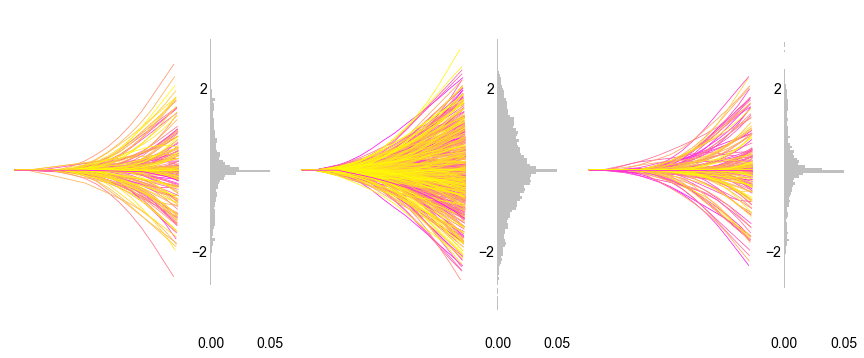

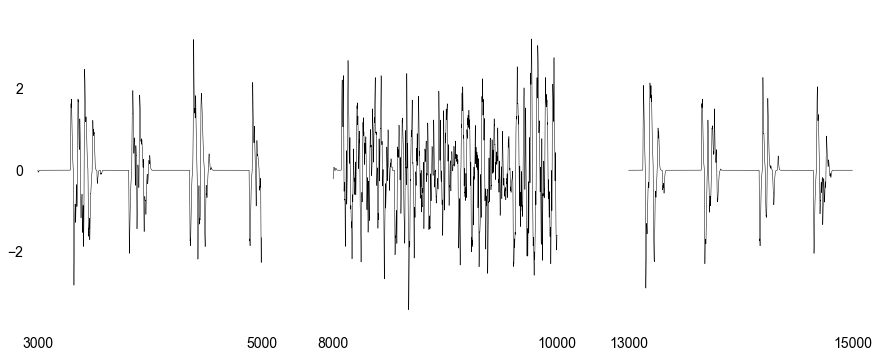

In [12]:
%matplotlib inline
# Import pandas for data saving
import pandas as pd
import numpy as np
import scipy.stats as stats
from pylab import *
from Analysis_tools import *

cmapYellow = matplotlib.cm.get_cmap('YlOrBr')
# Change default font to Arial
matplotlib.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"

rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.bf'] = 'Arial:italic:bold'

matplotlib.rcParams.update({'font.size': 14})

#This function computes midlines
def compute_midlines(Time, angle):
    
    midlines = []
    all_X = []
    all_Y = []
    for i,t in enumerate(Time):
        X = [np.cos(np.sum(angle[i,:j])) for j in range(len(angle[i]))]
        X = [np.sum(X[:i]) for i in range(len(X))]
        Y = [np.sin(np.sum(angle[i,:j])) for j in range(len(angle[i]))]
        Y = [np.sum(Y[:i]) for i in range(len(Y))]

        all_X.append(X)
        all_Y.append(Y)
        midlines.append((X,Y)) 
    
    return midlines, all_X, all_Y

read_data = pd.read_csv("Beat_and_Glide_strychnine.csv")
read_data

data_top = list(read_data.columns.values.tolist())
data_top

MN_index = []
dI6_index = [] 
V0v_index = []  
V2a_index = [] 
V1_index = []
Muscle_index = []

for i in range(0, len(data_top)):
    if (data_top[i].find('MN') != -1):
        MN_index.append(int(data_top[i][data_top[i].find('MN')+2:data_top[i].find('MN')+4]))
        nMN = max(MN_index) + 1
    if (data_top[i].find('dI6') != -1):
        dI6_index.append(int(data_top[i][data_top[i].find('dI6')+3:data_top[i].find('dI6')+5]))
        ndI6 = max(dI6_index) + 1
    if (data_top[i].find('V0v') != -1):
        V0v_index.append(int(data_top[i][data_top[i].find('V0v')+3:data_top[i].find('V0v')+5]))
        nV0v = max(V0v_index) + 1
    if (data_top[i].find('V2a') != -1):
        V2a_index.append(int(data_top[i][data_top[i].find('V2a')+3:data_top[i].find('V2a')+5]))
        nV2a = max(V2a_index) + 1
    if (data_top[i].find('V1') != -1):
        V1_index.append(int(data_top[i][data_top[i].find('V1')+2:data_top[i].find('V1')+4]))
        nV1 = max(V1_index) + 1
    if (data_top[i].find('Muscle') != -1):
        Muscle_index.append(int(data_top[i][data_top[i].find('Muscle')+6:data_top[i].find('Muscle')+8]))
        nMuscle = max(Muscle_index) + 1

read_sim = np.ascontiguousarray(read_data)
read_sim = np.transpose(read_sim)
read_sim
Time = read_sim[0]
next_start = 1
next_end = next_start + nMN
VLMN = read_sim[1:next_end]
next_start = next_end
next_end = next_start + nMN
VRMN = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + ndI6
VLdI6 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + ndI6
VRdI6 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV0v
VLV0v = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV0v
VRV0v = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV2a
VLV2a = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV2a
VRV2a = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV1
VLV1 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV1
VRV1 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nMuscle
VLMuscle = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nMuscle
VRMuscle = read_sim[next_start:next_end]
TIME_END = Time[-1]
TIME_END

dt = 0.1 #discretization time
# line length and width
LINELENGTH = 0.5
LINEWIDTH = 0.75

# font size
SMALL_SIZE = 7
MEDIUM_SIZE = 16
BIGGER_SIZE = 6
STANDARD_FONT_SIZE = 7

FONT_STYLE = 'bold'

### Calculate angles

vmin_=-0.1 
vmax_=0.1

nmax = len(VLMuscle[0,:])
nMuscle = len(VLMuscle[:,0])

# Allocating arrays for velocity and position
vel = np.zeros((nMuscle, nmax))
pos = np.zeros((nMuscle, nmax))

# Setting constants and initial values for vel. and pos.
khi = 3.0  #damping cste , high khi =0.5/ low = 0.1
w0 = 2.5 #2.5  #20Hz = 125.6
vel0 = 0.0
pos0 = 0.0
Wd = w0

for k in range (0,nMuscle):
    vel[k,0] = vel0    #Sets the initial velocity
    pos[k,0] = pos0    #Sets the initial position
    pos[nMuscle-1,0] = 0.0
    for i in range(1,nmax):

        vel[k,i] = -(w0**2)*pos[k,i-1]*dt + vel[k,i-1]*(1-(2*dt*khi*w0)) + 0.1*VRMuscle[k,i-1]*dt - 0.1*VLMuscle[k,i-1]*dt
        pos[k,i] = dt*vel[k,i-1] + pos[k,i-1]

pos2 = pos.transpose()
angle = pos2

fig, ax = plt.subplots(1,6, gridspec_kw={'width_ratios': [3, 1,3,1,3,1]}, frameon=False, figsize=(15, 6))

start_times = [0, 5000, 10000]
end_times = [5000, 10000, 15000]

EPOCH_SIZE = 50000
for i in range(0, 3): #compute midlines for all three epochs
        
    midlines, all_X, all_Y = compute_midlines(Time[start_times[i]*10:end_times[i]*10], angle[start_times[i]*10:end_times[i]*10])

    for side in ["top", "right", "bottom", "left"]:
        ax[i*2].spines[side].set_visible(False)

    time_min = start_times[i]#5000*i
    time_max = end_times[i]#5000*(i+1)
    #CONSTANTS
    nMIDLINES = int((time_max-time_min)/10)
    INTERVAL = 10
    MAP='spring' # choose carefully, or color transitions will not appear smoooth

    # Choose a color map, loop through the colors, and assign them to the color 
    # cycle. You need NPOINTS-1 colors, because you'll plot that many lines 
    # between pairs. In other words, your line is not cyclic, so there's 
    # no line from end to beginning
    cm = plt.get_cmap(MAP)
    #ax0.set_prop_cycle(color=[cm(1.*i/(NPOINTS-1)) for i in range(NPOINTS-1)])
    ax[i*2].set_prop_cycle(color=[cm(1.*i/(nMIDLINES-1)) for i in range(nMIDLINES-1)])

    for j,t in enumerate(Time[time_min*10:time_max*10]):
        if t%INTERVAL == 0:
            (X,Y) = midlines[j]
            ax[i*2].plot(X, Y, linewidth = LINEWIDTH)
    ax[i*2].set_xticks([])
    ax[i*2].set_yticks([])
    ax[i*2].set_ylim([-4, 4])

    # Plot histogram of y-coordinates of tail
    all_Y_terminals = [all_Y[i][-1] for i in range (len(all_Y))]
    ax[i*2+1].hist(all_Y_terminals, weights=np.ones(len(all_Y_terminals)) / len(all_Y_terminals), bins=100, color='silver', orientation='horizontal') # histogram of the last segment to get the density
    max_ = np.max(all_Y_terminals)
    min_ = np.min(all_Y_terminals)
    for side in ["top", "right", "bottom", "left"]:
        ax[i*2+1].spines[side].set_visible(False)
    ax[i*2+1].tick_params(axis='both', which='both', length=0)
    ax[i*2+1].set_xlim([0, 0.05])
    ax[i*2+1].set_ylim([-4, 4])
    ax[i*2+1].set_xticks([0, 0.05])
    ax[i*2+1].set_yticks([-2, 2])
plt.savefig('Strychnine_midlines_and_histogram.png', dpi=1000)
plt.show()
   
cmapGray = matplotlib.cm.get_cmap('gray')   
fig, ax = plt.subplots(1,3, gridspec_kw={'width_ratios': [1,1,1]}, frameon=False, figsize=(15, 6))

for i in range(0, 3):

    midlines, all_X, all_Y = compute_midlines(Time[start_times[i]*10:end_times[i]*10], angle[start_times[i]*10:end_times[i]*10])

    for side in ["top", "right", "bottom", "left"]:
        ax[i].spines[side].set_visible(False)

    time_min = start_times[i]#5000*i
    time_max = end_times[i]#5000*(i+1)
    #CONSTANTS
    nMIDLINES = int((time_max-time_min)/10)
    INTERVAL = 10
    MAP='spring' # choose carefully, or color transitions will not appear smoooth

    # Choose a color map, loop through the colors, and assign them to the color 
    # cycle. You need NPOINTS-1 colors, because you'll plot that many lines 
    # between pairs. In other words, your line is not cyclic, so there's 
    # no line from end to beginning
    cm = plt.get_cmap(MAP)
    #ax0.set_prop_cycle(color=[cm(1.*i/(NPOINTS-1)) for i in range(NPOINTS-1)])
    ax[i].set_prop_cycle(color=[cm(1.*i/(nMIDLINES-1)) for i in range(nMIDLINES-1)])

    for j,t in enumerate(Time[time_min*10:time_max*10]):
        if t%INTERVAL == 0:
            (X,Y) = midlines[j]

    # Plot histogram of y-coordinates of tail
    all_Y_terminals = [all_Y[i][-1] for i in range (len(all_Y))]
    ax[i].plot(Time[(time_min+3000)*10:time_max*10], all_Y_terminals[EPOCH_SIZE-20000:EPOCH_SIZE], linewidth = 0.5, c=cmapGray(0.0))
    ax[i].set_xticks([time_min+3000+2000*i for i in range(0,2)])
    if i == 0:
        ax[i].set_yticks([-2,0,2])
    else:
        ax[i].set_yticks([])
    ax[i].set_ylim([-4, 4])
    ax[i].tick_params(axis='both', which='both', length=0)
#fig.tight_layout()
plt.savefig('Strychnine_y_coordinates.png', dpi=1000)
plt.show()

## STATS FOR ALL NULL (KO) SIMULATIONS

In [ ]:
import scipy.stats as stats
import json
import numpy as np

### dI6 stats
results=[]
for i in range(0,3):
    names = "dI6_KO_results_epoch_" + str(i) + ".json"
    f = open(names,)
    results.append(json.load(f))

print("dI6_KO stats")
#test durations
print(stats.f_oneway(results[0]['Events']['Duration (ms)'], results[1]['Events']['Duration (ms)'], results[2]['Events']['Duration (ms)']))
print(len(results[0]['Events']['Duration (ms)']) + len(results[1]['Events']['Duration (ms)']) + len(results[2]['Events']['Duration (ms)'])-1)
print(stats.f_oneway(results[0]['Events']['Inter-event intervals'], results[1]['Events']['Inter-event intervals'], results[2]['Events']['Inter-event intervals']))
print(len(results[0]['Events']['Inter-event intervals']) + len(results[1]['Events']['Inter-event intervals']) + len(results[2]['Events']['Inter-event intervals']) -1)

#Filter out nan from Average frequency Instantanesou frequency
freq_temp = [results[i]['Average frequency']['Instantaneous frequency (Hz)'] for i in range(0,3)]

for i in range (0, 3):
    freq_temp[i] = [x for x in freq_temp[i] if math.isnan(x) == False]

print(stats.f_oneway(freq_temp[0], freq_temp[1], freq_temp[2]))
print(len(freq_temp[0]) + len(freq_temp[1]) + len(freq_temp[2]) -1)

print(stats.ttest_ind(freq_temp[0], freq_temp[1]))
print(stats.ttest_ind(freq_temp[1], freq_temp[2]))
print(stats.ttest_ind(freq_temp[0], freq_temp[2]))

### V0v stats
results=[]
for i in range(0,3):
    names = "V0v_KO_results_epoch_" + str(i) + ".json"
    f = open(names,)
    results.append(json.load(f))

print("V0v_KO stats")
#test durations
print(stats.f_oneway(results[0]['Events']['Duration (ms)'], results[1]['Events']['Duration (ms)'], results[2]['Events']['Duration (ms)']))
print(len(results[0]['Events']['Duration (ms)']) + len(results[1]['Events']['Duration (ms)']) + len(results[2]['Events']['Duration (ms)'])-1)

print(stats.ttest_ind(results[0]['Events']['Duration (ms)'], results[1]['Events']['Duration (ms)']))
print(stats.ttest_ind(results[1]['Events']['Duration (ms)'], results[2]['Events']['Duration (ms)']))
print(stats.ttest_ind(results[0]['Events']['Duration (ms)'], results[2]['Events']['Duration (ms)']))

print(stats.f_oneway(results[0]['Events']['Inter-event intervals'], results[1]['Events']['Inter-event intervals'], results[2]['Events']['Inter-event intervals']))
print(len(results[0]['Events']['Inter-event intervals']) + len(results[1]['Events']['Inter-event intervals']) + len(results[2]['Events']['Inter-event intervals']) -1)

print(stats.ttest_ind(results[0]['Events']['Inter-event intervals'], results[1]['Events']['Inter-event intervals']))
print(stats.ttest_ind(results[1]['Events']['Inter-event intervals'], results[2]['Events']['Inter-event intervals']))
print(stats.ttest_ind(results[0]['Events']['Inter-event intervals'], results[2]['Events']['Inter-event intervals']))

#Filter out nan from Average frequency Instantanesou frequency
freq_temp = [results[i]['Average frequency']['Instantaneous frequency (Hz)'] for i in range(0,3)]

for i in range (0, 3):
    freq_temp[i] = [x for x in freq_temp[i] if math.isnan(x) == False]

print(stats.f_oneway(freq_temp[0], freq_temp[1], freq_temp[2]))
print(len(freq_temp[0]) + len(freq_temp[1]) + len(freq_temp[2]) -1)

print(stats.ttest_ind(freq_temp[0], freq_temp[1]))
print(stats.ttest_ind(freq_temp[1], freq_temp[2]))
print(stats.ttest_ind(freq_temp[0], freq_temp[2]))

### V1 stats
results=[]
for i in range(0,3):
    names = "V1_KO_results_epoch_" + str(i) + ".json"
    f = open(names,)
    results.append(json.load(f))

print("V1_KO stats")
#test durations
print(stats.f_oneway(results[0]['Events']['Duration (ms)'], results[1]['Events']['Duration (ms)'], results[2]['Events']['Duration (ms)']))
print(len(results[0]['Events']['Duration (ms)']) + len(results[1]['Events']['Duration (ms)']) + len(results[2]['Events']['Duration (ms)'])-1)

print(stats.ttest_ind(results[0]['Events']['Duration (ms)'], results[1]['Events']['Duration (ms)']))
print(stats.ttest_ind(results[1]['Events']['Duration (ms)'], results[2]['Events']['Duration (ms)']))
print(stats.ttest_ind(results[0]['Events']['Duration (ms)'], results[2]['Events']['Duration (ms)']))

print(stats.f_oneway(results[0]['Events']['Inter-event intervals'], results[1]['Events']['Inter-event intervals'], results[2]['Events']['Inter-event intervals']))
print(len(results[0]['Events']['Inter-event intervals']) + len(results[1]['Events']['Inter-event intervals']) + len(results[2]['Events']['Inter-event intervals']) -1)

print(stats.ttest_ind(results[0]['Events']['Inter-event intervals'], results[1]['Events']['Inter-event intervals']))
print(stats.ttest_ind(results[1]['Events']['Inter-event intervals'], results[2]['Events']['Inter-event intervals']))
print(stats.ttest_ind(results[0]['Events']['Inter-event intervals'], results[2]['Events']['Inter-event intervals']))

#Filter out nan from Average frequency Instantaneous frequency
freq_temp = [results[i]['Average frequency']['Instantaneous frequency (Hz)'] for i in range(0,3)]

for i in range (0, 3):
    freq_temp[i] = [x for x in freq_temp[i] if math.isnan(x) == False]

print(stats.f_oneway(freq_temp[0], freq_temp[1], freq_temp[2]))
print(len(freq_temp[0]) + len(freq_temp[1]) + len(freq_temp[2]) -1)

print(stats.ttest_ind(freq_temp[0], freq_temp[1]))
print(stats.ttest_ind(freq_temp[1], freq_temp[2]))
print(stats.ttest_ind(freq_temp[0], freq_temp[2]))

### V2a stats
results=[]
for i in range(0,3):
    names = "V2a_KO_results_epoch_" + str(i) + ".json"
    f = open(names,)
    results.append(json.load(f))

print("V2a_KO stats")
#test durations

#Filter out nan from Duration
freq_temp = [results[i]['Events']['Duration (ms)'] for i in range(0,3)]

for i in range (0, 3):
    freq_temp[i] = [x for x in freq_temp[i] if math.isnan(x) == False]

print(stats.f_oneway(freq_temp[0], freq_temp[1], freq_temp[2]))
print(len(freq_temp[0]) + len(freq_temp[1]) + len(freq_temp[2]) -1)

print(stats.ttest_ind(freq_temp[0], freq_temp[1]))
print(stats.ttest_ind(freq_temp[1], freq_temp[2]))
print(stats.ttest_ind(freq_temp[0], freq_temp[2]))

#Filter out nan from Inter-event intervals

freq_temp = [results[i]['Events']['Inter-event intervals'] for i in range(0,3)]

for i in range (0, 3):
    freq_temp[i] = [x for x in freq_temp[i] if math.isnan(x) == False]

print(stats.f_oneway(freq_temp[0], freq_temp[1], freq_temp[2]))
print(len(freq_temp[0]) + len(freq_temp[1]) + len(freq_temp[2]) -1)

print(stats.ttest_ind(freq_temp[0], freq_temp[1]))
print(stats.ttest_ind(freq_temp[1], freq_temp[2]))
print(stats.ttest_ind(freq_temp[0], freq_temp[2]))

#Filter out nan from Average frequency Instantaneous frequency
freq_temp = [results[i]['Average frequency']['Instantaneous frequency (Hz)'] for i in range(0,3)]

for i in range (0, 3):
    freq_temp[i] = [x for x in freq_temp[i] if math.isnan(x) == False]

print(stats.f_oneway(freq_temp[0], freq_temp[1], freq_temp[2]))
print(len(freq_temp[0]) + len(freq_temp[1]) + len(freq_temp[2]) -1)

print(stats.ttest_ind(freq_temp[0], freq_temp[1]))
print(stats.ttest_ind(freq_temp[1], freq_temp[2]))
print(stats.ttest_ind(freq_temp[0], freq_temp[2]))


'''
dI6_KO stats
F_onewayResult(statistic=2.464298567977612, pvalue=0.10269880162642743)
31
F_onewayResult(statistic=0.9126007419950555, pvalue=0.41395715412692163)
28
F_onewayResult(statistic=3.4776642421888115, pvalue=0.033515881745929656)
145
Ttest_indResult(statistic=-3.0861354012101483, pvalue=0.0026790391992872545)
Ttest_indResult(statistic=1.245167333272325, pvalue=0.2156462052646845)
Ttest_indResult(statistic=-1.371095493964158, pvalue=0.17413208414253167)
V0v_KO stats
F_onewayResult(statistic=7.216561429581473, pvalue=0.002859997485086585)
31
Ttest_indResult(statistic=4.426634237017144, pvalue=0.00028963831830218755)
Ttest_indResult(statistic=-3.2406939316594654, pvalue=0.0043027563851406785)
Ttest_indResult(statistic=0.3023459682424065, pvalue=0.7655102105913186)
F_onewayResult(statistic=10.218264808392464, pvalue=0.0005314674839017719)
28
Ttest_indResult(statistic=-4.6241595009485605, pvalue=0.0002422690377615507)
Ttest_indResult(statistic=4.365188641131782, pvalue=0.00042154262301091007)
Ttest_indResult(statistic=0.1909907932270896, pvalue=0.8506705278085973)
F_onewayResult(statistic=3.427747534183849, pvalue=0.03587218866933021)
115
Ttest_indResult(statistic=2.239368881094125, pvalue=0.028559874161742244)
Ttest_indResult(statistic=-2.36136449259635, pvalue=0.021648909762403946)
Ttest_indResult(statistic=1.274239595251739, pvalue=0.20541851610661588)
V1_KO stats
F_onewayResult(statistic=10.480226212138508, pvalue=0.0005816414527095833)
25
Ttest_indResult(statistic=-3.2450640738821757, pvalue=0.006388640765768595)
Ttest_indResult(statistic=3.242766016757663, pvalue=0.005896959682765963)
Ttest_indResult(statistic=-1.112545842546478, pvalue=0.2797823496742844)
F_onewayResult(statistic=6.586941800186911, pvalue=0.0063436146265150066)
22
Ttest_indResult(statistic=5.878672739589637, pvalue=0.00010635934839083918)
Ttest_indResult(statistic=-1.95818243979227, pvalue=0.07386631534355483)
Ttest_indResult(statistic=1.6106260515093134, pvalue=0.12567137364043307)
F_onewayResult(statistic=6.550257009319315, pvalue=0.0017365754876983905)
214
Ttest_indResult(statistic=-2.3664948856489967, pvalue=0.019139179902078432)
Ttest_indResult(statistic=2.7951759750974627, pvalue=0.005769799005553259)
Ttest_indResult(statistic=0.24104083669678905, pvalue=0.8100841860506689)
V2a_KO stats
F_onewayResult(statistic=2.092365927006541, pvalue=0.14958470563246254)
22
Ttest_indResult(statistic=nan, pvalue=nan)
Ttest_indResult(statistic=nan, pvalue=nan)
Ttest_indResult(statistic=0.3077983306656235, pvalue=0.7614182927417342)
F_onewayResult(statistic=nan, pvalue=nan)
19
Ttest_indResult(statistic=nan, pvalue=nan)
Ttest_indResult(statistic=nan, pvalue=nan)
Ttest_indResult(statistic=-1.5317578994055543, pvalue=0.14296881307076503)
F_onewayResult(statistic=nan, pvalue=nan)
71
Ttest_indResult(statistic=nan, pvalue=nan)
Ttest_indResult(statistic=nan, pvalue=nan)
Ttest_indResult(statistic=-0.15729540367949188, pvalue=0.875464873935726)
'''


## Supplementary Videos

### Figure 5 - video 1 - V2a null 

<IPython.core.display.Javascript object>


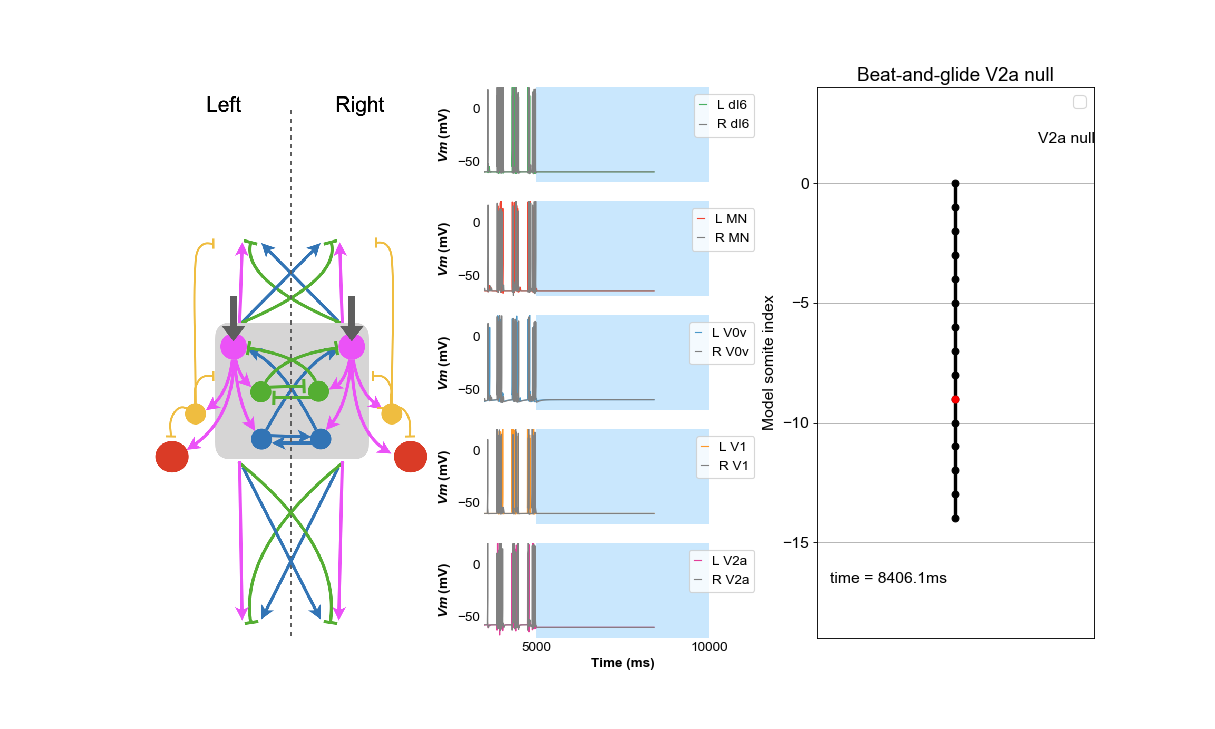

No handles with labels found to put in legend.


In [14]:

%matplotlib notebook
%matplotlib notebook
from Izhikevich_class import*
from Analysis_tools import *
import pandas as pd
import numpy as np
import matplotlib.image as mpimg

# line length and width
LINELENGTH = 0.5
LINEWIDTH = 1
plt.rc('lines', linewidth=LINEWIDTH) 

# Change default font to Arial
matplotlib.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"

rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.bf'] = 'Arial:italic:bold'

# font size
SMALLER_SIZE = 12
SMALL_SIZE = 12

FONT_STYLE = 'bold'

# y-axis limit
lower_y = -70
upper_y = 20

# color map
cmapGrey = matplotlib.cm.get_cmap('Greys')
cmapBlue = matplotlib.cm.get_cmap('Blues')
cmapRed = matplotlib.cm.get_cmap('Reds')
cmapGreen = matplotlib.cm.get_cmap('Greens')
cmapBrown = matplotlib.cm.get_cmap('YlOrBr')
cmapRedPurple = matplotlib.cm.get_cmap('RdPu')
cmapBrightGreen = matplotlib.cm.get_cmap('hsv')
cmapYellow = matplotlib.cm.get_cmap('YlOrBr')

# image for beat and glide diagram
img = mpimg.imread('Beat_and_glide_diagram.png')

# function that combines musculoskeletal model and cell firing
def multipanel_anim(Time,nMuscle,nmax, VRdI6, VLdI6, VRMN, VLMN, VRV0v, VLV0v, VRV1, VLV1, VRV2a, VLV2a, VRMuscle,VLMuscle,dt):

    #set figure including subplots 
    fig = plt.figure(figsize=(15, 9))
    
    fig_angles = fig.add_subplot(133)    
    fig_dI6 = fig.add_subplot(5,3,2)
    fig_MN = fig.add_subplot(5,3,5)
    fig_V0v = fig.add_subplot(5,3,8)
    fig_V1 = fig.add_subplot(5,3,11)
    fig_V2a = fig.add_subplot(5,3,14)
    
    fig_angles.set_title("Beat-and-glide V2a null")
    
    fig_diagram = fig.add_subplot(131)
    fig_diagram.imshow(img)
    fig_diagram.axis('off')
     
    LdI6_firing, = fig_dI6.plot([], [], lw=1, color = cmapGreen(0.6))
    RdI6_firing, = fig_dI6.plot([], [], lw=1, color = 'Grey')

    LMN_firing, = fig_MN.plot([], [], lw=1, color = cmapRed(0.6))
    RMN_firing, = fig_MN.plot([], [], lw=1, color = 'Grey')
 
    LV0v_firing, = fig_V0v.plot([], [], lw=1, color = cmapBlue(0.6))
    RV0v_firing, = fig_V0v.plot([], [], lw=1, color = 'Grey')

    LV1_firing, = fig_V1.plot([], [], lw=1, color = cmapYellow(0.5))
    RV1_firing, = fig_V1.plot([], [], lw=1, color = 'Grey')
    
    LV2a_firing, = fig_V2a.plot([], [], lw=1, color = cmapRedPurple(0.6))
    RV2a_firing, = fig_V2a.plot([], [], lw=1, color = 'Grey')
       
    Muscle_angles, = fig_angles.plot([], [], 'o-', lw=3, color = 'Black')
    Muscle_angles_highlight, = fig_angles.plot([], [], 'o-', lw=3, color = 'Red')
    
    # Allocating arrays for velocity and position
    vel = np.zeros((nMuscle, nmax))
    pos = np.zeros((nMuscle, nmax))
    
    # Setting constants and initial values for vel. and pos.
    khi = 3.0  #damping cste , high khi =0.5/ low = 0.1
    w0 = 2.5 #2.5  #20Hz = 125.6
    vel0 = 0.0
    pos0 = 0.0
    Wd = w0
    
    for k in range (0,nMuscle):
        vel[k,0] = vel0    #Sets the initial velocity
        pos[k,0] = pos0    #Sets the initial position
        pos[nMuscle-1,0] = 0.0
        for i in range(1,nmax):
        
            vel[k,i] = -(w0**2)*pos[k,i-1]*dt + vel[k,i-1]*(1-(2*dt*khi*w0)) + 0.1*VRMuscle[k,i-1]*dt - 0.1*VLMuscle[k,i-1]*dt
            pos[k,i] = dt*vel[k,i-1] + pos[k,i-1]
    
    ### DYNAMIC PLOTTING
    
    x = np.zeros((nMuscle,nmax))
    y = np.zeros((nMuscle,nmax))
    
    for i in range (0,nmax):
        x[0,i] = 0
        y[0,i] = 0
        pos[0,i] = 0
        for k in range (1,nMuscle):
            pos[k,i] = pos[k-1,i] + pos[k,i]
            
            x[k,i] = x[k-1,i] + np.sin(pos[k,i])
            y[k,i] = y[k-1,i] - np.cos(pos[k,i])
    #set limits for x and y-axis
    fig_angles.grid()
    fig_angles.set_ylim(-20, 5)
    fig_angles.set_xlim(-3, 3)
    fig_dI6.set_ylim(-80, 20)
    fig_dI6.set_xlim(0, nmax*dt)
    fig_MN.set_ylim(-80, 20)
    fig_MN.set_xlim(0, nmax*dt)
    fig_V0v.set_ylim(-80, 20)
    fig_V0v.set_xlim(0, nmax*dt)
    fig_V1.set_ylim(-80, 20)
    fig_V1.set_xlim(0, nmax*dt)
    fig_V2a.set_ylim(-80, 20)
    fig_V2a.set_xlim(0, nmax*dt)

    #time text
    time_template = 'time = %.1fms'
    time_text = fig_angles.text(0.05, 0.1, '', transform=fig_angles.transAxes)
    epoch_text = fig_angles.text(0.8, 0.9, '', transform=fig_angles.transAxes)
    fig_angles.legend()
    fig_angles.set_ylabel('Model somite index')
    fig_angles.set_ylim([-19, 4])
    fig_angles.set_xticks([])

    # set blue stripe at t=5000 to 10000
    fig_dI6.axvspan(5000, 10000, facecolor='xkcd:light blue', alpha=0.5)
    fig_MN.axvspan(5000, 10000, facecolor='xkcd:light blue', alpha=0.5)
    fig_V0v.axvspan(5000, 10000, facecolor='xkcd:light blue', alpha=0.5)
    fig_V1.axvspan(5000, 10000, facecolor='xkcd:light blue', alpha=0.5)
    fig_V2a.axvspan(5000, 10000, facecolor='xkcd:light blue', alpha=0.5)

    #legend for dI6 subplot
    leg=fig_dI6.legend(handles=[LdI6_firing, RdI6_firing], labels=['L dI6','R dI6'], loc='upper right', handlelength=LINELENGTH, fontsize=SMALLER_SIZE)
    leg.legendHandles[0].set_color(cmapGreen(0.6))
    leg.legendHandles[1].set_color('grey')
    for line in leg.get_lines():
        line.set_linewidth(LINEWIDTH)
        
    fig_dI6.set_ylabel(r"$\mathbf{Vm}$" + " (mV)", fontsize= SMALL_SIZE, fontweight=FONT_STYLE) #y-axis title
    fig_dI6.set_ylim([lower_y, upper_y]) #y-axis limt
    #remove borders
    fig_dI6.spines['top'].set_visible(False)
    fig_dI6.spines['right'].set_visible(False)
    fig_dI6.spines['bottom'].set_visible(False)
    fig_dI6.spines['left'].set_visible(False)
    #tick parameters
    fig_dI6.tick_params(axis='both', which='both', length=0)
    for item in ([fig_dI6.title, fig_dI6.xaxis.label, fig_dI6.yaxis.label] +
             fig_dI6.get_xticklabels() + fig_dI6.get_yticklabels()):
        item.set_fontsize(SMALL_SIZE)
    fig_dI6.set_yticks([i*50 + -50 for i in range(0,2)])
    fig_dI6.set_xticks([])
    fig_dI6.set_xlim([Time[0], Time[-1]])
    
    #settings for MN trace. Same as dI6
    leg=fig_MN.legend(handles=[LMN_firing, RMN_firing], labels=['L MN','R MN'], loc='upper right', handlelength=LINELENGTH, fontsize=SMALLER_SIZE)
    leg.legendHandles[0].set_color(cmapRed(0.6))
    leg.legendHandles[1].set_color('grey')
    for line in leg.get_lines():
        line.set_linewidth(LINEWIDTH)

    fig_MN.set_ylabel(r"$\mathbf{Vm}$" + " (mV)", fontsize= SMALL_SIZE, fontweight=FONT_STYLE)
    fig_MN.set_ylim([lower_y, upper_y])
    fig_MN.spines['top'].set_visible(False)
    fig_MN.spines['right'].set_visible(False)
    fig_MN.spines['bottom'].set_visible(False)
    fig_MN.spines['left'].set_visible(False)
    fig_MN.tick_params(axis='both', which='both', length=0)
    for item in ([fig_MN.title, fig_MN.xaxis.label, fig_MN.yaxis.label] +
             fig_MN.get_xticklabels() + fig_MN.get_yticklabels()):
        item.set_fontsize(SMALL_SIZE)
    fig_MN.set_yticks([i*50 + -50 for i in range(0,2)])
    fig_MN.set_xticks([])
    fig_MN.set_xlim([Time[0], Time[-1]])
    
    #settings for V0v trace. Same as dI6
    leg=fig_V0v.legend(handles=[LV0v_firing, RV0v_firing], labels=['L V0v','R V0v'], loc='upper right', handlelength=LINELENGTH, fontsize=SMALLER_SIZE)
    leg.legendHandles[0].set_color(cmapBlue(0.6))
    leg.legendHandles[1].set_color('grey')
    for line in leg.get_lines():
        line.set_linewidth(LINEWIDTH)

    fig_V0v.set_ylabel(r"$\mathbf{Vm}$" + " (mV)", fontsize= SMALL_SIZE, fontweight=FONT_STYLE)
    fig_V0v.set_ylim([lower_y, upper_y])
    fig_V0v.spines['top'].set_visible(False)
    fig_V0v.spines['right'].set_visible(False)
    fig_V0v.spines['bottom'].set_visible(False)
    fig_V0v.spines['left'].set_visible(False)
    fig_V0v.tick_params(axis='both', which='both', length=0)
    for item in ([fig_V0v.title, fig_V0v.xaxis.label, fig_V0v.yaxis.label] +
             fig_V0v.get_xticklabels() + fig_V0v.get_yticklabels()):
        item.set_fontsize(SMALL_SIZE)
    fig_V0v.set_yticks([i*50 + -50 for i in range(0,2)])
    fig_V0v.set_xticks([])
    fig_V0v.set_xlim([Time[0], Time[-1]])
    
    #settings for V1 trace. Same as dI6
    leg=fig_V1.legend(handles=[LV1_firing, RV1_firing], labels=['L V1','R V1'], loc='upper right', handlelength=LINELENGTH, fontsize=SMALLER_SIZE)
    leg.legendHandles[0].set_color(cmapYellow(0.5))
    leg.legendHandles[1].set_color('grey')
    for line in leg.get_lines():
        line.set_linewidth(LINEWIDTH)

    fig_V1.set_ylabel(r"$\mathbf{Vm}$" + " (mV)", fontsize= SMALL_SIZE, fontweight=FONT_STYLE)
    fig_V1.set_ylim([lower_y, upper_y])
    fig_V1.spines['top'].set_visible(False)
    fig_V1.spines['right'].set_visible(False)
    fig_V1.spines['bottom'].set_visible(False)
    fig_V1.spines['left'].set_visible(False)
    fig_V1.tick_params(axis='both', which='both', length=0)
    for item in ([fig_V1.title, fig_V1.xaxis.label, fig_V1.yaxis.label] +
             fig_V1.get_xticklabels() + fig_V1.get_yticklabels()):
        item.set_fontsize(SMALL_SIZE)
    fig_V1.set_yticks([i*50 + -50 for i in range(0,2)])
    fig_V1.set_xticks([])
    fig_V1.set_xlim([Time[0], Time[-1]])
    
    #settings for V2a trace. Same as dI6
    leg=fig_V2a.legend(handles=[LV2a_firing, RV2a_firing], labels=['L V2a','R V2a'], loc='upper right', handlelength=LINELENGTH, fontsize=SMALLER_SIZE)
    leg.legendHandles[0].set_color(cmapRedPurple(0.6))
    leg.legendHandles[1].set_color('grey')
    for line in leg.get_lines():
        line.set_linewidth(LINEWIDTH)

    fig_V2a.set_ylabel(r"$\mathbf{Vm}$" + " (mV)", fontsize= SMALL_SIZE, fontweight=FONT_STYLE)
    fig_V2a.set_ylim([lower_y, upper_y])
    fig_V2a.spines['top'].set_visible(False)
    fig_V2a.spines['right'].set_visible(False)
    fig_V2a.spines['bottom'].set_visible(False)
    fig_V2a.spines['left'].set_visible(False)
    fig_V2a.tick_params(axis='both', which='both', length=0)
    for item in ([fig_V2a.title, fig_V2a.xaxis.label, fig_V2a.yaxis.label] +
             fig_V2a.get_xticklabels() + fig_V2a.get_yticklabels()):
        item.set_fontsize(SMALL_SIZE)
    fig_V2a.set_yticks([i*50 + -50 for i in range(0,2)])
    fig_V2a.set_xticks([i*5000 for i in range(0,20)])
    fig_V2a.set_xlabel('Time (ms)', fontsize= SMALL_SIZE, fontweight='bold')
    fig_V2a.set_xlim([Time[0], Time[-1]])
    
    def init():
        Muscle_angles.set_data([], [])
        LdI6_firing.set_data([], [])
        RdI6_firing.set_data([], [])
        LMN_firing.set_data([], [])
        RMN_firing.set_data([], [])
        LV0v_firing.set_data([], [])
        RV0v_firing.set_data([], [])
        LV1_firing.set_data([], [])
        RV1_firing.set_data([], [])
        LV2a_firing.set_data([], [])
        RV2a_firing.set_data([], [])
        time_text.set_text('')
        epoch_text.set_text('')
        return Muscle_angles, LdI6_firing, RdI6_firing, LMN_firing, RMN_firing, LV0v_firing, RV0v_firing, LV1_firing, RV1_firing, LV2a_firing, RV2a_firing,  time_text, epoch_text
    
    #This function drives the animation by updating every time point
    def animate(i):
        
        thisx = [x[k,i] for k in range(nMuscle)]
        thisy = [y[k,i] for k in range(nMuscle)]
        
        Muscle_angles.set_data(thisx, thisy)
        Muscle_angles_highlight.set_data(x[9,i], y[9,i])
        
        time_text.set_text(time_template % (Time[i]))

        LdI6_firing.set_data(Time[0:i], VLdI6[9, 0:i])
        RdI6_firing.set_data(Time[0:i], VRdI6[9, 0:i])

        LMN_firing.set_data(Time[0:i], VLMN[9, 0:i])
        RMN_firing.set_data(Time[0:i], VRMN[9, 0:i])
        
        LV0v_firing.set_data(Time[0:i], VLV0v[9, 0:i])
        RV0v_firing.set_data(Time[0:i], VRV0v[9, 0:i])

        LV1_firing.set_data(Time[0:i], VLV1[5, 0:i])
        RV1_firing.set_data(Time[0:i], VRV1[5, 0:i])

        LV2a_firing.set_data(Time[0:i], VLV2a[7, 0:i])
        RV2a_firing.set_data(Time[0:i], VRV2a[7, 0:i])
        
        if Time[i] < 5000 or Time[i] > 10000:
            epoch_text.set_text("Control")
        elif 5000 < Time[i] < 10000:
            epoch_text.set_text("V2a null")
        
        return Muscle_angles, LdI6_firing, RdI6_firing, LMN_firing, RMN_firing, LV0v_firing, RV0v_firing, LV1_firing, RV1_firing, LV2a_firing, RV2a_firing,  time_text, epoch_text
     
    ani = animation.FuncAnimation(fig, animate, np.arange(1, len(Time), 10), #animation.FuncAnimation(fig, animate, np.arange(1, len(Time), 10), for faster animation
                                  interval=10, blit=False, init_func=init)
    
    plt.show()
    return ani

### NOW PLOTTING NEURON ACTIVITY DURING SWIMMING SIMULATION ###
# This file was used to make the figure for all of the neuron traces during a typical double coil
read_data = pd.read_csv("Beat_and_Glide_V2a_KO.csv")

data_top = list(read_data.columns.values.tolist())
data_top

MN_index = []
dI6_index = [] 
V0v_index = []  
V2a_index = [] 
V1_index = []
Muscle_index = []

for i in range(0, len(data_top)):
    if (data_top[i].find('MN') != -1):
        MN_index.append(int(data_top[i][data_top[i].find('MN')+2:data_top[i].find('MN')+4]))
        nMN = max(MN_index) + 1
    if (data_top[i].find('dI6') != -1):
        dI6_index.append(int(data_top[i][data_top[i].find('dI6')+3:data_top[i].find('dI6')+5]))
        ndI6 = max(dI6_index) + 1
    if (data_top[i].find('V0v') != -1):
        V0v_index.append(int(data_top[i][data_top[i].find('V0v')+3:data_top[i].find('V0v')+5]))
        nV0v = max(V0v_index) + 1
    if (data_top[i].find('V2a') != -1):
        V2a_index.append(int(data_top[i][data_top[i].find('V2a')+3:data_top[i].find('V2a')+5]))
        nV2a = max(V2a_index) + 1
    if (data_top[i].find('V1') != -1):
        V1_index.append(int(data_top[i][data_top[i].find('V1')+2:data_top[i].find('V1')+4]))
        nV1 = max(V1_index) + 1
    if (data_top[i].find('Muscle') != -1):
        Muscle_index.append(int(data_top[i][data_top[i].find('Muscle')+6:data_top[i].find('Muscle')+8]))
        nMuscle = max(Muscle_index) + 1
        
read_sim = np.ascontiguousarray(read_data)
read_sim = np.transpose(read_sim)
read_sim
Time = read_sim[0]
next_start = 1
next_end = next_start + nMN
VLMN = read_sim[1:next_end]
next_start = next_end
next_end = next_start + nMN
VRMN = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + ndI6
VLdI6 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + ndI6
VRdI6 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV0v
VLV0v = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV0v
VRV0v = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV2a
VLV2a = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV2a
VRV2a = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV1
VLV1 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV1
VRV1 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nMuscle
VLMuscle = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nMuscle
VRMuscle = read_sim[next_start:next_end]
TIME_END = Time[-1]
TIME_END

# x range for coiling simulation

mywriter = animation.FFMpegWriter()
nMuscle = 15
dt = 0.1
tstart = 3500
tend = 11500
start = int(tstart/dt)
end = int(tend/dt)
nmax = int((tend-tstart)/dt)
ani = multipanel_anim(Time[start:end],nMuscle,nmax, VRdI6[:,start:end], VLdI6[:,start:end], VRMN[:,start:end], VLMN[:,start:end], 
                      VRV0v[:,start:end], VLV0v[:,start:end], VRV1[:,start:end], VLV1[:,start:end], VRV2a[:,start:end], 
                      VLV2a[:,start:end], VRMuscle[:,start:end],VLMuscle[:,start:end],dt)

In [ ]:
ani.save("Figure 5 - video 1.mp4")#, fps=30)#, extra_args=['-vcodec', 'libx264'])

### Figure 5 - video 2 - V0v null 

Traceback (most recent call last):
  File "C:\Users\tuanm\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\tuanm\anaconda3\lib\site-packages\matplotlib\animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>


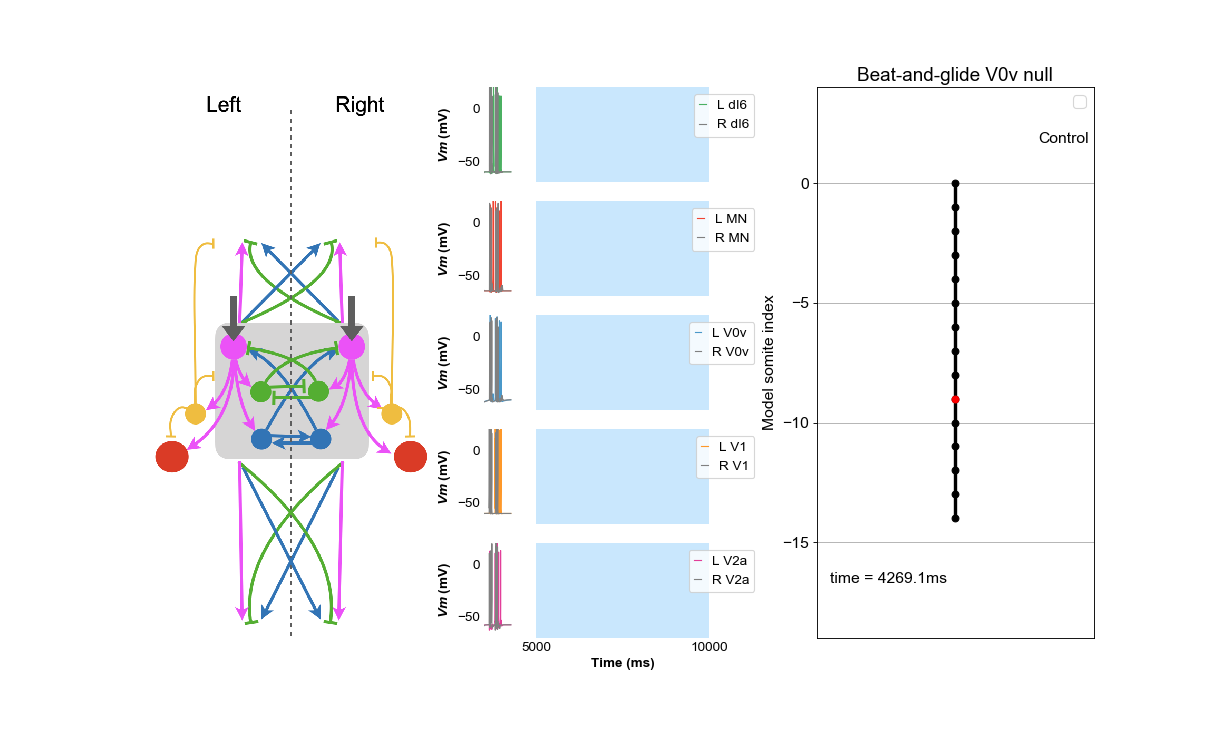

No handles with labels found to put in legend.


In [15]:
%matplotlib notebook
%matplotlib notebook
from Izhikevich_class import*
from Analysis_tools import *
import pandas as pd
import numpy as np
import matplotlib.image as mpimg

# line length and width
LINELENGTH = 0.5
LINEWIDTH = 1
plt.rc('lines', linewidth=LINEWIDTH) 

# Change default font to Arial
matplotlib.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"

rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.bf'] = 'Arial:italic:bold'

# font size
SMALLER_SIZE = 12
SMALL_SIZE = 12

FONT_STYLE = 'bold'

# y-axis limit
lower_y = -70
upper_y = 20

# color map
cmapGrey = matplotlib.cm.get_cmap('Greys')
cmapBlue = matplotlib.cm.get_cmap('Blues')
cmapRed = matplotlib.cm.get_cmap('Reds')
cmapGreen = matplotlib.cm.get_cmap('Greens')
cmapBrown = matplotlib.cm.get_cmap('YlOrBr')
cmapRedPurple = matplotlib.cm.get_cmap('RdPu')
cmapBrightGreen = matplotlib.cm.get_cmap('hsv')
cmapYellow = matplotlib.cm.get_cmap('YlOrBr')

# image for beat and glide diagram
img = mpimg.imread('Beat_and_glide_diagram.png')

# function that combines musculoskeletal model and cell firing
def multipanel_anim(Time,nMuscle,nmax, VRdI6, VLdI6, VRMN, VLMN, VRV0v, VLV0v, VRV1, VLV1, VRV2a, VLV2a, VRMuscle,VLMuscle,dt):

    #set figure including subplots 
    fig = plt.figure(figsize=(15, 9))
    
    fig_angles = fig.add_subplot(133)    
    fig_dI6 = fig.add_subplot(5,3,2)
    fig_MN = fig.add_subplot(5,3,5)
    fig_V0v = fig.add_subplot(5,3,8)
    fig_V1 = fig.add_subplot(5,3,11)
    fig_V2a = fig.add_subplot(5,3,14)
    
    fig_angles.set_title("Beat-and-glide V0v null")
    
    fig_diagram = fig.add_subplot(131)
    fig_diagram.imshow(img)
    fig_diagram.axis('off')
     
    LdI6_firing, = fig_dI6.plot([], [], lw=1, color = cmapGreen(0.6))
    RdI6_firing, = fig_dI6.plot([], [], lw=1, color = 'Grey')

    LMN_firing, = fig_MN.plot([], [], lw=1, color = cmapRed(0.6))
    RMN_firing, = fig_MN.plot([], [], lw=1, color = 'Grey')
 
    LV0v_firing, = fig_V0v.plot([], [], lw=1, color = cmapBlue(0.6))
    RV0v_firing, = fig_V0v.plot([], [], lw=1, color = 'Grey')

    LV1_firing, = fig_V1.plot([], [], lw=1, color = cmapYellow(0.5))
    RV1_firing, = fig_V1.plot([], [], lw=1, color = 'Grey')
    
    LV2a_firing, = fig_V2a.plot([], [], lw=1, color = cmapRedPurple(0.6))
    RV2a_firing, = fig_V2a.plot([], [], lw=1, color = 'Grey')
       
    Muscle_angles, = fig_angles.plot([], [], 'o-', lw=3, color = 'Black')
    Muscle_angles_highlight, = fig_angles.plot([], [], 'o-', lw=3, color = 'Red')
    
    # Allocating arrays for velocity and position
    vel = np.zeros((nMuscle, nmax))
    pos = np.zeros((nMuscle, nmax))
    
    # Setting constants and initial values for vel. and pos.
    khi = 3.0  #damping cste , high khi =0.5/ low = 0.1
    w0 = 2.5 #2.5  #20Hz = 125.6
    vel0 = 0.0
    pos0 = 0.0
    Wd = w0
    
    for k in range (0,nMuscle):
        vel[k,0] = vel0    #Sets the initial velocity
        pos[k,0] = pos0    #Sets the initial position
        pos[nMuscle-1,0] = 0.0
        for i in range(1,nmax):
        
            vel[k,i] = -(w0**2)*pos[k,i-1]*dt + vel[k,i-1]*(1-(2*dt*khi*w0)) + 0.1*VRMuscle[k,i-1]*dt - 0.1*VLMuscle[k,i-1]*dt
            pos[k,i] = dt*vel[k,i-1] + pos[k,i-1]
    
    ### DYNAMIC PLOTTING
    
    x = np.zeros((nMuscle,nmax))
    y = np.zeros((nMuscle,nmax))
    
    for i in range (0,nmax):
        x[0,i] = 0
        y[0,i] = 0
        pos[0,i] = 0
        for k in range (1,nMuscle):
            pos[k,i] = pos[k-1,i] + pos[k,i]
            
            x[k,i] = x[k-1,i] + np.sin(pos[k,i])
            y[k,i] = y[k-1,i] - np.cos(pos[k,i])
    #set limits for x and y-axis
    fig_angles.grid()
    fig_angles.set_ylim(-20, 5)
    fig_angles.set_xlim(-3, 3)
    fig_dI6.set_ylim(-80, 20)
    fig_dI6.set_xlim(0, nmax*dt)
    fig_MN.set_ylim(-80, 20)
    fig_MN.set_xlim(0, nmax*dt)
    fig_V0v.set_ylim(-80, 20)
    fig_V0v.set_xlim(0, nmax*dt)
    fig_V1.set_ylim(-80, 20)
    fig_V1.set_xlim(0, nmax*dt)
    fig_V2a.set_ylim(-80, 20)
    fig_V2a.set_xlim(0, nmax*dt)

    #time text
    time_template = 'time = %.1fms'
    time_text = fig_angles.text(0.05, 0.1, '', transform=fig_angles.transAxes)
    epoch_text = fig_angles.text(0.8, 0.9, '', transform=fig_angles.transAxes)
    fig_angles.legend()
    fig_angles.set_ylabel('Model somite index')
    fig_angles.set_ylim([-19, 4])
    fig_angles.set_xticks([])

    # set blue stripe at t=5000 to 10000
    fig_dI6.axvspan(5000, 10000, facecolor='xkcd:light blue', alpha=0.5)
    fig_MN.axvspan(5000, 10000, facecolor='xkcd:light blue', alpha=0.5)
    fig_V0v.axvspan(5000, 10000, facecolor='xkcd:light blue', alpha=0.5)
    fig_V1.axvspan(5000, 10000, facecolor='xkcd:light blue', alpha=0.5)
    fig_V2a.axvspan(5000, 10000, facecolor='xkcd:light blue', alpha=0.5)

    #legend for dI6 subplot
    leg=fig_dI6.legend(handles=[LdI6_firing, RdI6_firing], labels=['L dI6','R dI6'], loc='upper right', handlelength=LINELENGTH, fontsize=SMALLER_SIZE)
    leg.legendHandles[0].set_color(cmapGreen(0.6))
    leg.legendHandles[1].set_color('grey')
    for line in leg.get_lines():
        line.set_linewidth(LINEWIDTH)
        
    fig_dI6.set_ylabel(r"$\mathbf{Vm}$" + " (mV)", fontsize= SMALL_SIZE, fontweight=FONT_STYLE) #y-axis title
    fig_dI6.set_ylim([lower_y, upper_y]) #y-axis limt
    #remove borders
    fig_dI6.spines['top'].set_visible(False)
    fig_dI6.spines['right'].set_visible(False)
    fig_dI6.spines['bottom'].set_visible(False)
    fig_dI6.spines['left'].set_visible(False)
    #tick parameters
    fig_dI6.tick_params(axis='both', which='both', length=0)
    for item in ([fig_dI6.title, fig_dI6.xaxis.label, fig_dI6.yaxis.label] +
             fig_dI6.get_xticklabels() + fig_dI6.get_yticklabels()):
        item.set_fontsize(SMALL_SIZE)
    fig_dI6.set_yticks([i*50 + -50 for i in range(0,2)])
    fig_dI6.set_xticks([])
    fig_dI6.set_xlim([Time[0], Time[-1]])
    
    #settings for MN trace. Same as dI6
    leg=fig_MN.legend(handles=[LMN_firing, RMN_firing], labels=['L MN','R MN'], loc='upper right', handlelength=LINELENGTH, fontsize=SMALLER_SIZE)
    leg.legendHandles[0].set_color(cmapRed(0.6))
    leg.legendHandles[1].set_color('grey')
    for line in leg.get_lines():
        line.set_linewidth(LINEWIDTH)

    fig_MN.set_ylabel(r"$\mathbf{Vm}$" + " (mV)", fontsize= SMALL_SIZE, fontweight=FONT_STYLE)
    fig_MN.set_ylim([lower_y, upper_y])
    fig_MN.spines['top'].set_visible(False)
    fig_MN.spines['right'].set_visible(False)
    fig_MN.spines['bottom'].set_visible(False)
    fig_MN.spines['left'].set_visible(False)
    fig_MN.tick_params(axis='both', which='both', length=0)
    for item in ([fig_MN.title, fig_MN.xaxis.label, fig_MN.yaxis.label] +
             fig_MN.get_xticklabels() + fig_MN.get_yticklabels()):
        item.set_fontsize(SMALL_SIZE)
    fig_MN.set_yticks([i*50 + -50 for i in range(0,2)])
    fig_MN.set_xticks([])
    fig_MN.set_xlim([Time[0], Time[-1]])
    
    #settings for V0v trace. Same as dI6
    leg=fig_V0v.legend(handles=[LV0v_firing, RV0v_firing], labels=['L V0v','R V0v'], loc='upper right', handlelength=LINELENGTH, fontsize=SMALLER_SIZE)
    leg.legendHandles[0].set_color(cmapBlue(0.6))
    leg.legendHandles[1].set_color('grey')
    for line in leg.get_lines():
        line.set_linewidth(LINEWIDTH)

    fig_V0v.set_ylabel(r"$\mathbf{Vm}$" + " (mV)", fontsize= SMALL_SIZE, fontweight=FONT_STYLE)
    fig_V0v.set_ylim([lower_y, upper_y])
    fig_V0v.spines['top'].set_visible(False)
    fig_V0v.spines['right'].set_visible(False)
    fig_V0v.spines['bottom'].set_visible(False)
    fig_V0v.spines['left'].set_visible(False)
    fig_V0v.tick_params(axis='both', which='both', length=0)
    for item in ([fig_V0v.title, fig_V0v.xaxis.label, fig_V0v.yaxis.label] +
             fig_V0v.get_xticklabels() + fig_V0v.get_yticklabels()):
        item.set_fontsize(SMALL_SIZE)
    fig_V0v.set_yticks([i*50 + -50 for i in range(0,2)])
    fig_V0v.set_xticks([])
    fig_V0v.set_xlim([Time[0], Time[-1]])
    
    #settings for V1 trace. Same as dI6
    leg=fig_V1.legend(handles=[LV1_firing, RV1_firing], labels=['L V1','R V1'], loc='upper right', handlelength=LINELENGTH, fontsize=SMALLER_SIZE)
    leg.legendHandles[0].set_color(cmapYellow(0.5))
    leg.legendHandles[1].set_color('grey')
    for line in leg.get_lines():
        line.set_linewidth(LINEWIDTH)

    fig_V1.set_ylabel(r"$\mathbf{Vm}$" + " (mV)", fontsize= SMALL_SIZE, fontweight=FONT_STYLE)
    fig_V1.set_ylim([lower_y, upper_y])
    fig_V1.spines['top'].set_visible(False)
    fig_V1.spines['right'].set_visible(False)
    fig_V1.spines['bottom'].set_visible(False)
    fig_V1.spines['left'].set_visible(False)
    fig_V1.tick_params(axis='both', which='both', length=0)
    for item in ([fig_V1.title, fig_V1.xaxis.label, fig_V1.yaxis.label] +
             fig_V1.get_xticklabels() + fig_V1.get_yticklabels()):
        item.set_fontsize(SMALL_SIZE)
    fig_V1.set_yticks([i*50 + -50 for i in range(0,2)])
    fig_V1.set_xticks([])
    fig_V1.set_xlim([Time[0], Time[-1]])
    
    #settings for V2a trace. Same as dI6
    leg=fig_V2a.legend(handles=[LV2a_firing, RV2a_firing], labels=['L V2a','R V2a'], loc='upper right', handlelength=LINELENGTH, fontsize=SMALLER_SIZE)
    leg.legendHandles[0].set_color(cmapRedPurple(0.6))
    leg.legendHandles[1].set_color('grey')
    for line in leg.get_lines():
        line.set_linewidth(LINEWIDTH)

    fig_V2a.set_ylabel(r"$\mathbf{Vm}$" + " (mV)", fontsize= SMALL_SIZE, fontweight=FONT_STYLE)
    fig_V2a.set_ylim([lower_y, upper_y])
    fig_V2a.spines['top'].set_visible(False)
    fig_V2a.spines['right'].set_visible(False)
    fig_V2a.spines['bottom'].set_visible(False)
    fig_V2a.spines['left'].set_visible(False)
    fig_V2a.tick_params(axis='both', which='both', length=0)
    for item in ([fig_V2a.title, fig_V2a.xaxis.label, fig_V2a.yaxis.label] +
             fig_V2a.get_xticklabels() + fig_V2a.get_yticklabels()):
        item.set_fontsize(SMALL_SIZE)
    fig_V2a.set_yticks([i*50 + -50 for i in range(0,2)])
    fig_V2a.set_xticks([i*5000 for i in range(0,20)])
    fig_V2a.set_xlabel('Time (ms)', fontsize= SMALL_SIZE, fontweight='bold')
    fig_V2a.set_xlim([Time[0], Time[-1]])
    
    def init():
        Muscle_angles.set_data([], [])
        LdI6_firing.set_data([], [])
        RdI6_firing.set_data([], [])
        LMN_firing.set_data([], [])
        RMN_firing.set_data([], [])
        LV0v_firing.set_data([], [])
        RV0v_firing.set_data([], [])
        LV1_firing.set_data([], [])
        RV1_firing.set_data([], [])
        LV2a_firing.set_data([], [])
        RV2a_firing.set_data([], [])
        time_text.set_text('')
        epoch_text.set_text('')
        return Muscle_angles, LdI6_firing, RdI6_firing, LMN_firing, RMN_firing, LV0v_firing, RV0v_firing, LV1_firing, RV1_firing, LV2a_firing, RV2a_firing,  time_text, epoch_text
    
    #This function drives the animation by updating every time point
    def animate(i):
        
        thisx = [x[k,i] for k in range(nMuscle)]
        thisy = [y[k,i] for k in range(nMuscle)]
        
        Muscle_angles.set_data(thisx, thisy)
        Muscle_angles_highlight.set_data(x[9,i], y[9,i])
        
        time_text.set_text(time_template % (Time[i]))

        LdI6_firing.set_data(Time[0:i], VLdI6[9, 0:i])
        RdI6_firing.set_data(Time[0:i], VRdI6[9, 0:i])

        LMN_firing.set_data(Time[0:i], VLMN[9, 0:i])
        RMN_firing.set_data(Time[0:i], VRMN[9, 0:i])
        
        LV0v_firing.set_data(Time[0:i], VLV0v[9, 0:i])
        RV0v_firing.set_data(Time[0:i], VRV0v[9, 0:i])

        LV1_firing.set_data(Time[0:i], VLV1[9, 0:i])
        RV1_firing.set_data(Time[0:i], VRV1[9, 0:i])

        LV2a_firing.set_data(Time[0:i], VLV2a[9, 0:i])
        RV2a_firing.set_data(Time[0:i], VRV2a[9, 0:i])
        
        if Time[i] < 5000 or Time[i] > 10000:
            epoch_text.set_text("Control")
        elif 5000 < Time[i] < 10000:
            epoch_text.set_text("V0v null")
        
        return Muscle_angles, LdI6_firing, RdI6_firing, LMN_firing, RMN_firing, LV0v_firing, RV0v_firing, LV1_firing, RV1_firing, LV2a_firing, RV2a_firing,  time_text, epoch_text
     
    ani = animation.FuncAnimation(fig, animate, np.arange(1, len(Time), 10), #animation.FuncAnimation(fig, animate, np.arange(1, len(Time), 10), for faster animation
                                  interval=10, blit=False, init_func=init)
    
    plt.show()
    return ani

### NOW PLOTTING NEURON ACTIVITY DURING SWIMMING SIMULATION ###
# This file was used to make the figure for all of the neuron traces during a typical double coil
read_data = pd.read_csv("Beat_and_Glide_V0v_KO.csv")

data_top = list(read_data.columns.values.tolist())
data_top

MN_index = []
dI6_index = [] 
V0v_index = []  
V2a_index = [] 
V1_index = []
Muscle_index = []

for i in range(0, len(data_top)):
    if (data_top[i].find('MN') != -1):
        MN_index.append(int(data_top[i][data_top[i].find('MN')+2:data_top[i].find('MN')+4]))
        nMN = max(MN_index) + 1
    if (data_top[i].find('dI6') != -1):
        dI6_index.append(int(data_top[i][data_top[i].find('dI6')+3:data_top[i].find('dI6')+5]))
        ndI6 = max(dI6_index) + 1
    if (data_top[i].find('V0v') != -1):
        V0v_index.append(int(data_top[i][data_top[i].find('V0v')+3:data_top[i].find('V0v')+5]))
        nV0v = max(V0v_index) + 1
    if (data_top[i].find('V2a') != -1):
        V2a_index.append(int(data_top[i][data_top[i].find('V2a')+3:data_top[i].find('V2a')+5]))
        nV2a = max(V2a_index) + 1
    if (data_top[i].find('V1') != -1):
        V1_index.append(int(data_top[i][data_top[i].find('V1')+2:data_top[i].find('V1')+4]))
        nV1 = max(V1_index) + 1
    if (data_top[i].find('Muscle') != -1):
        Muscle_index.append(int(data_top[i][data_top[i].find('Muscle')+6:data_top[i].find('Muscle')+8]))
        nMuscle = max(Muscle_index) + 1
        
read_sim = np.ascontiguousarray(read_data)
read_sim = np.transpose(read_sim)
read_sim
Time = read_sim[0]
next_start = 1
next_end = next_start + nMN
VLMN = read_sim[1:next_end]
next_start = next_end
next_end = next_start + nMN
VRMN = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + ndI6
VLdI6 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + ndI6
VRdI6 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV0v
VLV0v = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV0v
VRV0v = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV2a
VLV2a = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV2a
VRV2a = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV1
VLV1 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV1
VRV1 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nMuscle
VLMuscle = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nMuscle
VRMuscle = read_sim[next_start:next_end]
TIME_END = Time[-1]
TIME_END

# x range for coiling simulation

mywriter = animation.FFMpegWriter()
nMuscle = 15
dt = 0.1
tstart = 3500
tend = 11500
start = int(tstart/dt)
end = int(tend/dt)
nmax = int((tend-tstart)/dt)
ani = multipanel_anim(Time[start:end],nMuscle,nmax, VRdI6[:,start:end], VLdI6[:,start:end], VRMN[:,start:end], VLMN[:,start:end], 
                      VRV0v[:,start:end], VLV0v[:,start:end], VRV1[:,start:end], VLV1[:,start:end], VRV2a[:,start:end], 
                      VLV2a[:,start:end], VRMuscle[:,start:end],VLMuscle[:,start:end],dt)

In [ ]:
ani.save("Figure 5 - video 2.mp4")#, fps=30)#, extra_args=['-vcodec', 'libx264'])

### Figure 6 - video 1 - V1 null 

Traceback (most recent call last):
  File "C:\Users\tuanm\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\tuanm\anaconda3\lib\site-packages\matplotlib\animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>


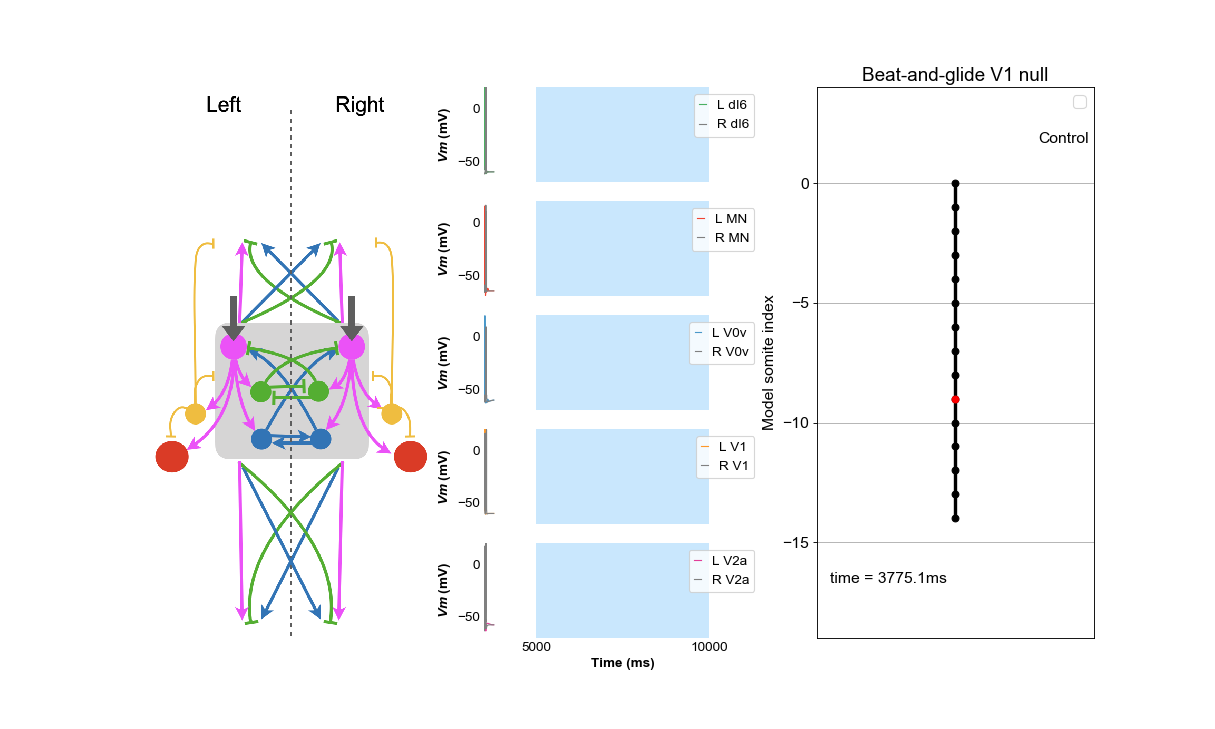

No handles with labels found to put in legend.


In [16]:
%matplotlib notebook
%matplotlib notebook
from Izhikevich_class import*
from Analysis_tools import *
import pandas as pd
import numpy as np
import matplotlib.image as mpimg

# line length and width
LINELENGTH = 0.5
LINEWIDTH = 1
plt.rc('lines', linewidth=LINEWIDTH) 

# Change default font to Arial
matplotlib.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"

rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.bf'] = 'Arial:italic:bold'

# font size
SMALLER_SIZE = 12
SMALL_SIZE = 12

FONT_STYLE = 'bold'

# y-axis limit
lower_y = -70
upper_y = 20

# color map
cmapGrey = matplotlib.cm.get_cmap('Greys')
cmapBlue = matplotlib.cm.get_cmap('Blues')
cmapRed = matplotlib.cm.get_cmap('Reds')
cmapGreen = matplotlib.cm.get_cmap('Greens')
cmapBrown = matplotlib.cm.get_cmap('YlOrBr')
cmapRedPurple = matplotlib.cm.get_cmap('RdPu')
cmapBrightGreen = matplotlib.cm.get_cmap('hsv')
cmapYellow = matplotlib.cm.get_cmap('YlOrBr')

# image for beat and glide diagram
img = mpimg.imread('Beat_and_glide_diagram.png')

# function that combines musculoskeletal model and cell firing
def multipanel_anim(Time,nMuscle,nmax, VRdI6, VLdI6, VRMN, VLMN, VRV0v, VLV0v, VRV1, VLV1, VRV2a, VLV2a, VRMuscle,VLMuscle,dt):

    #set figure including subplots 
    fig = plt.figure(figsize=(15, 9))
    
    fig_angles = fig.add_subplot(133)    
    fig_dI6 = fig.add_subplot(5,3,2)
    fig_MN = fig.add_subplot(5,3,5)
    fig_V0v = fig.add_subplot(5,3,8)
    fig_V1 = fig.add_subplot(5,3,11)
    fig_V2a = fig.add_subplot(5,3,14)
    
    fig_angles.set_title("Beat-and-glide V1 null")
    
    fig_diagram = fig.add_subplot(131)
    fig_diagram.imshow(img)
    fig_diagram.axis('off')
     
    LdI6_firing, = fig_dI6.plot([], [], lw=1, color = cmapGreen(0.6))
    RdI6_firing, = fig_dI6.plot([], [], lw=1, color = 'Grey')

    LMN_firing, = fig_MN.plot([], [], lw=1, color = cmapRed(0.6))
    RMN_firing, = fig_MN.plot([], [], lw=1, color = 'Grey')
 
    LV0v_firing, = fig_V0v.plot([], [], lw=1, color = cmapBlue(0.6))
    RV0v_firing, = fig_V0v.plot([], [], lw=1, color = 'Grey')

    LV1_firing, = fig_V1.plot([], [], lw=1, color = cmapYellow(0.5))
    RV1_firing, = fig_V1.plot([], [], lw=1, color = 'Grey')
    
    LV2a_firing, = fig_V2a.plot([], [], lw=1, color = cmapRedPurple(0.6))
    RV2a_firing, = fig_V2a.plot([], [], lw=1, color = 'Grey')
       
    Muscle_angles, = fig_angles.plot([], [], 'o-', lw=3, color = 'Black')
    Muscle_angles_highlight, = fig_angles.plot([], [], 'o-', lw=3, color = 'Red')
    
    # Allocating arrays for velocity and position
    vel = np.zeros((nMuscle, nmax))
    pos = np.zeros((nMuscle, nmax))
    
    # Setting constants and initial values for vel. and pos.
    khi = 3.0  #damping cste , high khi =0.5/ low = 0.1
    w0 = 2.5 #2.5  #20Hz = 125.6
    vel0 = 0.0
    pos0 = 0.0
    Wd = w0
    
    for k in range (0,nMuscle):
        vel[k,0] = vel0    #Sets the initial velocity
        pos[k,0] = pos0    #Sets the initial position
        pos[nMuscle-1,0] = 0.0
        for i in range(1,nmax):
        
            vel[k,i] = -(w0**2)*pos[k,i-1]*dt + vel[k,i-1]*(1-(2*dt*khi*w0)) + 0.1*VRMuscle[k,i-1]*dt - 0.1*VLMuscle[k,i-1]*dt
            pos[k,i] = dt*vel[k,i-1] + pos[k,i-1]
    
    ### DYNAMIC PLOTTING
    
    x = np.zeros((nMuscle,nmax))
    y = np.zeros((nMuscle,nmax))
    
    for i in range (0,nmax):
        x[0,i] = 0
        y[0,i] = 0
        pos[0,i] = 0
        for k in range (1,nMuscle):
            pos[k,i] = pos[k-1,i] + pos[k,i]
            
            x[k,i] = x[k-1,i] + np.sin(pos[k,i])
            y[k,i] = y[k-1,i] - np.cos(pos[k,i])
    #set limits for x and y-axis
    fig_angles.grid()
    fig_angles.set_ylim(-20, 5)
    fig_angles.set_xlim(-3, 3)
    fig_dI6.set_ylim(-80, 20)
    fig_dI6.set_xlim(0, nmax*dt)
    fig_MN.set_ylim(-80, 20)
    fig_MN.set_xlim(0, nmax*dt)
    fig_V0v.set_ylim(-80, 20)
    fig_V0v.set_xlim(0, nmax*dt)
    fig_V1.set_ylim(-80, 20)
    fig_V1.set_xlim(0, nmax*dt)
    fig_V2a.set_ylim(-80, 20)
    fig_V2a.set_xlim(0, nmax*dt)

    #time text
    time_template = 'time = %.1fms'
    time_text = fig_angles.text(0.05, 0.1, '', transform=fig_angles.transAxes)
    epoch_text = fig_angles.text(0.8, 0.9, '', transform=fig_angles.transAxes)
    fig_angles.legend()
    fig_angles.set_ylabel('Model somite index')
    fig_angles.set_ylim([-19, 4])
    fig_angles.set_xticks([])

    # set blue stripe at t=5000 to 10000
    fig_dI6.axvspan(5000, 10000, facecolor='xkcd:light blue', alpha=0.5)
    fig_MN.axvspan(5000, 10000, facecolor='xkcd:light blue', alpha=0.5)
    fig_V0v.axvspan(5000, 10000, facecolor='xkcd:light blue', alpha=0.5)
    fig_V1.axvspan(5000, 10000, facecolor='xkcd:light blue', alpha=0.5)
    fig_V2a.axvspan(5000, 10000, facecolor='xkcd:light blue', alpha=0.5)

    #legend for dI6 subplot
    leg=fig_dI6.legend(handles=[LdI6_firing, RdI6_firing], labels=['L dI6','R dI6'], loc='upper right', handlelength=LINELENGTH, fontsize=SMALLER_SIZE)
    leg.legendHandles[0].set_color(cmapGreen(0.6))
    leg.legendHandles[1].set_color('grey')
    for line in leg.get_lines():
        line.set_linewidth(LINEWIDTH)
        
    fig_dI6.set_ylabel(r"$\mathbf{Vm}$" + " (mV)", fontsize= SMALL_SIZE, fontweight=FONT_STYLE) #y-axis title
    fig_dI6.set_ylim([lower_y, upper_y]) #y-axis limt
    #remove borders
    fig_dI6.spines['top'].set_visible(False)
    fig_dI6.spines['right'].set_visible(False)
    fig_dI6.spines['bottom'].set_visible(False)
    fig_dI6.spines['left'].set_visible(False)
    #tick parameters
    fig_dI6.tick_params(axis='both', which='both', length=0)
    for item in ([fig_dI6.title, fig_dI6.xaxis.label, fig_dI6.yaxis.label] +
             fig_dI6.get_xticklabels() + fig_dI6.get_yticklabels()):
        item.set_fontsize(SMALL_SIZE)
    fig_dI6.set_yticks([i*50 + -50 for i in range(0,2)])
    fig_dI6.set_xticks([])
    fig_dI6.set_xlim([Time[0], Time[-1]])
    
    #settings for MN trace. Same as dI6
    leg=fig_MN.legend(handles=[LMN_firing, RMN_firing], labels=['L MN','R MN'], loc='upper right', handlelength=LINELENGTH, fontsize=SMALLER_SIZE)
    leg.legendHandles[0].set_color(cmapRed(0.6))
    leg.legendHandles[1].set_color('grey')
    for line in leg.get_lines():
        line.set_linewidth(LINEWIDTH)

    fig_MN.set_ylabel(r"$\mathbf{Vm}$" + " (mV)", fontsize= SMALL_SIZE, fontweight=FONT_STYLE)
    fig_MN.set_ylim([lower_y, upper_y])
    fig_MN.spines['top'].set_visible(False)
    fig_MN.spines['right'].set_visible(False)
    fig_MN.spines['bottom'].set_visible(False)
    fig_MN.spines['left'].set_visible(False)
    fig_MN.tick_params(axis='both', which='both', length=0)
    for item in ([fig_MN.title, fig_MN.xaxis.label, fig_MN.yaxis.label] +
             fig_MN.get_xticklabels() + fig_MN.get_yticklabels()):
        item.set_fontsize(SMALL_SIZE)
    fig_MN.set_yticks([i*50 + -50 for i in range(0,2)])
    fig_MN.set_xticks([])
    fig_MN.set_xlim([Time[0], Time[-1]])
    
    #settings for V0v trace. Same as dI6
    leg=fig_V0v.legend(handles=[LV0v_firing, RV0v_firing], labels=['L V0v','R V0v'], loc='upper right', handlelength=LINELENGTH, fontsize=SMALLER_SIZE)
    leg.legendHandles[0].set_color(cmapBlue(0.6))
    leg.legendHandles[1].set_color('grey')
    for line in leg.get_lines():
        line.set_linewidth(LINEWIDTH)

    fig_V0v.set_ylabel(r"$\mathbf{Vm}$" + " (mV)", fontsize= SMALL_SIZE, fontweight=FONT_STYLE)
    fig_V0v.set_ylim([lower_y, upper_y])
    fig_V0v.spines['top'].set_visible(False)
    fig_V0v.spines['right'].set_visible(False)
    fig_V0v.spines['bottom'].set_visible(False)
    fig_V0v.spines['left'].set_visible(False)
    fig_V0v.tick_params(axis='both', which='both', length=0)
    for item in ([fig_V0v.title, fig_V0v.xaxis.label, fig_V0v.yaxis.label] +
             fig_V0v.get_xticklabels() + fig_V0v.get_yticklabels()):
        item.set_fontsize(SMALL_SIZE)
    fig_V0v.set_yticks([i*50 + -50 for i in range(0,2)])
    fig_V0v.set_xticks([])
    fig_V0v.set_xlim([Time[0], Time[-1]])
    
    #settings for V1 trace. Same as dI6
    leg=fig_V1.legend(handles=[LV1_firing, RV1_firing], labels=['L V1','R V1'], loc='upper right', handlelength=LINELENGTH, fontsize=SMALLER_SIZE)
    leg.legendHandles[0].set_color(cmapYellow(0.5))
    leg.legendHandles[1].set_color('grey')
    for line in leg.get_lines():
        line.set_linewidth(LINEWIDTH)

    fig_V1.set_ylabel(r"$\mathbf{Vm}$" + " (mV)", fontsize= SMALL_SIZE, fontweight=FONT_STYLE)
    fig_V1.set_ylim([lower_y, upper_y])
    fig_V1.spines['top'].set_visible(False)
    fig_V1.spines['right'].set_visible(False)
    fig_V1.spines['bottom'].set_visible(False)
    fig_V1.spines['left'].set_visible(False)
    fig_V1.tick_params(axis='both', which='both', length=0)
    for item in ([fig_V1.title, fig_V1.xaxis.label, fig_V1.yaxis.label] +
             fig_V1.get_xticklabels() + fig_V1.get_yticklabels()):
        item.set_fontsize(SMALL_SIZE)
    fig_V1.set_yticks([i*50 + -50 for i in range(0,2)])
    fig_V1.set_xticks([])
    fig_V1.set_xlim([Time[0], Time[-1]])
    
    #settings for V2a trace. Same as dI6
    leg=fig_V2a.legend(handles=[LV2a_firing, RV2a_firing], labels=['L V2a','R V2a'], loc='upper right', handlelength=LINELENGTH, fontsize=SMALLER_SIZE)
    leg.legendHandles[0].set_color(cmapRedPurple(0.6))
    leg.legendHandles[1].set_color('grey')
    for line in leg.get_lines():
        line.set_linewidth(LINEWIDTH)

    fig_V2a.set_ylabel(r"$\mathbf{Vm}$" + " (mV)", fontsize= SMALL_SIZE, fontweight=FONT_STYLE)
    fig_V2a.set_ylim([lower_y, upper_y])
    fig_V2a.spines['top'].set_visible(False)
    fig_V2a.spines['right'].set_visible(False)
    fig_V2a.spines['bottom'].set_visible(False)
    fig_V2a.spines['left'].set_visible(False)
    fig_V2a.tick_params(axis='both', which='both', length=0)
    for item in ([fig_V2a.title, fig_V2a.xaxis.label, fig_V2a.yaxis.label] +
             fig_V2a.get_xticklabels() + fig_V2a.get_yticklabels()):
        item.set_fontsize(SMALL_SIZE)
    fig_V2a.set_yticks([i*50 + -50 for i in range(0,2)])
    fig_V2a.set_xticks([i*5000 for i in range(0,20)])
    fig_V2a.set_xlabel('Time (ms)', fontsize= SMALL_SIZE, fontweight='bold')
    fig_V2a.set_xlim([Time[0], Time[-1]])
    
    def init():
        Muscle_angles.set_data([], [])
        LdI6_firing.set_data([], [])
        RdI6_firing.set_data([], [])
        LMN_firing.set_data([], [])
        RMN_firing.set_data([], [])
        LV0v_firing.set_data([], [])
        RV0v_firing.set_data([], [])
        LV1_firing.set_data([], [])
        RV1_firing.set_data([], [])
        LV2a_firing.set_data([], [])
        RV2a_firing.set_data([], [])
        time_text.set_text('')
        epoch_text.set_text('')
        return Muscle_angles, LdI6_firing, RdI6_firing, LMN_firing, RMN_firing, LV0v_firing, RV0v_firing, LV1_firing, RV1_firing, LV2a_firing, RV2a_firing,  time_text, epoch_text
    
    #This function drives the animation by updating every time point
    def animate(i):
        
        thisx = [x[k,i] for k in range(nMuscle)]
        thisy = [y[k,i] for k in range(nMuscle)]
        
        Muscle_angles.set_data(thisx, thisy)
        Muscle_angles_highlight.set_data(x[9,i], y[9,i])
        
        time_text.set_text(time_template % (Time[i]))

        LdI6_firing.set_data(Time[0:i], VLdI6[9, 0:i])
        RdI6_firing.set_data(Time[0:i], VRdI6[9, 0:i])

        LMN_firing.set_data(Time[0:i], VLMN[9, 0:i])
        RMN_firing.set_data(Time[0:i], VRMN[9, 0:i])
        
        LV0v_firing.set_data(Time[0:i], VLV0v[9, 0:i])
        RV0v_firing.set_data(Time[0:i], VRV0v[9, 0:i])

        LV1_firing.set_data(Time[0:i], VLV1[9, 0:i])
        RV1_firing.set_data(Time[0:i], VRV1[9, 0:i])

        LV2a_firing.set_data(Time[0:i], VLV2a[9, 0:i])
        RV2a_firing.set_data(Time[0:i], VRV2a[9, 0:i])
        
        if Time[i] < 5000 or Time[i] > 10000:
            epoch_text.set_text("Control")
        elif 5000 < Time[i] < 10000:
            epoch_text.set_text("V1 null")
        
        return Muscle_angles, LdI6_firing, RdI6_firing, LMN_firing, RMN_firing, LV0v_firing, RV0v_firing, LV1_firing, RV1_firing, LV2a_firing, RV2a_firing,  time_text, epoch_text
     
    ani = animation.FuncAnimation(fig, animate, np.arange(1, len(Time), 10), #animation.FuncAnimation(fig, animate, np.arange(1, len(Time), 10), for faster animation
                                  interval=10, blit=False, init_func=init)
    
    plt.show()
    return ani

### NOW PLOTTING NEURON ACTIVITY DURING SWIMMING SIMULATION ###
# This file was used to make the figure for all of the neuron traces during a typical double coil
read_data = pd.read_csv("Beat_and_Glide_V1_KO.csv")

data_top = list(read_data.columns.values.tolist())
data_top

MN_index = []
dI6_index = [] 
V0v_index = []  
V2a_index = [] 
V1_index = []
Muscle_index = []

for i in range(0, len(data_top)):
    if (data_top[i].find('MN') != -1):
        MN_index.append(int(data_top[i][data_top[i].find('MN')+2:data_top[i].find('MN')+4]))
        nMN = max(MN_index) + 1
    if (data_top[i].find('dI6') != -1):
        dI6_index.append(int(data_top[i][data_top[i].find('dI6')+3:data_top[i].find('dI6')+5]))
        ndI6 = max(dI6_index) + 1
    if (data_top[i].find('V0v') != -1):
        V0v_index.append(int(data_top[i][data_top[i].find('V0v')+3:data_top[i].find('V0v')+5]))
        nV0v = max(V0v_index) + 1
    if (data_top[i].find('V2a') != -1):
        V2a_index.append(int(data_top[i][data_top[i].find('V2a')+3:data_top[i].find('V2a')+5]))
        nV2a = max(V2a_index) + 1
    if (data_top[i].find('V1') != -1):
        V1_index.append(int(data_top[i][data_top[i].find('V1')+2:data_top[i].find('V1')+4]))
        nV1 = max(V1_index) + 1
    if (data_top[i].find('Muscle') != -1):
        Muscle_index.append(int(data_top[i][data_top[i].find('Muscle')+6:data_top[i].find('Muscle')+8]))
        nMuscle = max(Muscle_index) + 1
        
read_sim = np.ascontiguousarray(read_data)
read_sim = np.transpose(read_sim)
read_sim
Time = read_sim[0]
next_start = 1
next_end = next_start + nMN
VLMN = read_sim[1:next_end]
next_start = next_end
next_end = next_start + nMN
VRMN = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + ndI6
VLdI6 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + ndI6
VRdI6 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV0v
VLV0v = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV0v
VRV0v = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV2a
VLV2a = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV2a
VRV2a = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV1
VLV1 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV1
VRV1 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nMuscle
VLMuscle = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nMuscle
VRMuscle = read_sim[next_start:next_end]
TIME_END = Time[-1]
TIME_END

# x range for coiling simulation

mywriter = animation.FFMpegWriter()
nMuscle = 15
dt = 0.1
tstart = 3500
tend = 11500
start = int(tstart/dt)
end = int(tend/dt)
nmax = int((tend-tstart)/dt)
ani = multipanel_anim(Time[start:end],nMuscle,nmax, VRdI6[:,start:end], VLdI6[:,start:end], VRMN[:,start:end], VLMN[:,start:end], 
                      VRV0v[:,start:end], VLV0v[:,start:end], VRV1[:,start:end], VLV1[:,start:end], VRV2a[:,start:end], 
                      VLV2a[:,start:end], VRMuscle[:,start:end],VLMuscle[:,start:end],dt)

In [ ]:
ani.save("Figure 6 - video 1.mp4")#, fps=30)#, extra_args=['-vcodec', 'libx264'])

### Figure 6 - video 2 - dI6 null 

Traceback (most recent call last):
  File "C:\Users\tuanm\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\tuanm\anaconda3\lib\site-packages\matplotlib\animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>


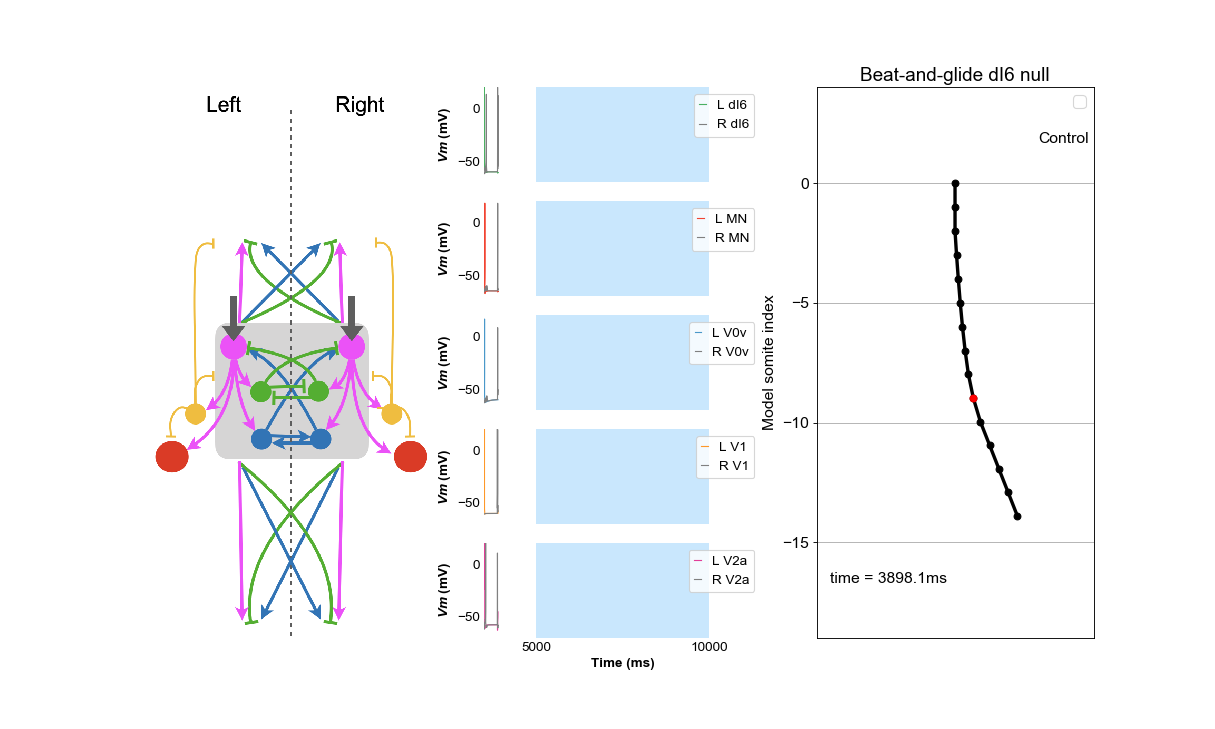

No handles with labels found to put in legend.


In [17]:
%matplotlib notebook
%matplotlib notebook
from Izhikevich_class import*
from Analysis_tools import *
import pandas as pd
import numpy as np
import matplotlib.image as mpimg

# line length and width
LINELENGTH = 0.5
LINEWIDTH = 1
plt.rc('lines', linewidth=LINEWIDTH) 

# Change default font to Arial
matplotlib.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"

rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.bf'] = 'Arial:italic:bold'

# font size
SMALLER_SIZE = 12
SMALL_SIZE = 12

FONT_STYLE = 'bold'

# y-axis limit
lower_y = -70
upper_y = 20

# color map
cmapGrey = matplotlib.cm.get_cmap('Greys')
cmapBlue = matplotlib.cm.get_cmap('Blues')
cmapRed = matplotlib.cm.get_cmap('Reds')
cmapGreen = matplotlib.cm.get_cmap('Greens')
cmapBrown = matplotlib.cm.get_cmap('YlOrBr')
cmapRedPurple = matplotlib.cm.get_cmap('RdPu')
cmapBrightGreen = matplotlib.cm.get_cmap('hsv')
cmapYellow = matplotlib.cm.get_cmap('YlOrBr')

# image for beat and glide diagram
img = mpimg.imread('Beat_and_glide_diagram.png')

# function that combines musculoskeletal model and cell firing
def multipanel_anim(Time,nMuscle,nmax, VRdI6, VLdI6, VRMN, VLMN, VRV0v, VLV0v, VRV1, VLV1, VRV2a, VLV2a, VRMuscle,VLMuscle,dt):

    #set figure including subplots 
    fig = plt.figure(figsize=(15, 9))
    
    fig_angles = fig.add_subplot(133)    
    fig_dI6 = fig.add_subplot(5,3,2)
    fig_MN = fig.add_subplot(5,3,5)
    fig_V0v = fig.add_subplot(5,3,8)
    fig_V1 = fig.add_subplot(5,3,11)
    fig_V2a = fig.add_subplot(5,3,14)
    
    fig_angles.set_title("Beat-and-glide dI6 null")
    
    fig_diagram = fig.add_subplot(131)
    fig_diagram.imshow(img)
    fig_diagram.axis('off')
     
    LdI6_firing, = fig_dI6.plot([], [], lw=1, color = cmapGreen(0.6))
    RdI6_firing, = fig_dI6.plot([], [], lw=1, color = 'Grey')

    LMN_firing, = fig_MN.plot([], [], lw=1, color = cmapRed(0.6))
    RMN_firing, = fig_MN.plot([], [], lw=1, color = 'Grey')
 
    LV0v_firing, = fig_V0v.plot([], [], lw=1, color = cmapBlue(0.6))
    RV0v_firing, = fig_V0v.plot([], [], lw=1, color = 'Grey')

    LV1_firing, = fig_V1.plot([], [], lw=1, color = cmapYellow(0.5))
    RV1_firing, = fig_V1.plot([], [], lw=1, color = 'Grey')
    
    LV2a_firing, = fig_V2a.plot([], [], lw=1, color = cmapRedPurple(0.6))
    RV2a_firing, = fig_V2a.plot([], [], lw=1, color = 'Grey')
       
    Muscle_angles, = fig_angles.plot([], [], 'o-', lw=3, color = 'Black')
    Muscle_angles_highlight, = fig_angles.plot([], [], 'o-', lw=3, color = 'Red')
    
    # Allocating arrays for velocity and position
    vel = np.zeros((nMuscle, nmax))
    pos = np.zeros((nMuscle, nmax))
    
    # Setting constants and initial values for vel. and pos.
    khi = 3.0  #damping cste , high khi =0.5/ low = 0.1
    w0 = 2.5 #2.5  #20Hz = 125.6
    vel0 = 0.0
    pos0 = 0.0
    Wd = w0
    
    for k in range (0,nMuscle):
        vel[k,0] = vel0    #Sets the initial velocity
        pos[k,0] = pos0    #Sets the initial position
        pos[nMuscle-1,0] = 0.0
        for i in range(1,nmax):
        
            vel[k,i] = -(w0**2)*pos[k,i-1]*dt + vel[k,i-1]*(1-(2*dt*khi*w0)) + 0.1*VRMuscle[k,i-1]*dt - 0.1*VLMuscle[k,i-1]*dt
            pos[k,i] = dt*vel[k,i-1] + pos[k,i-1]
    
    ### DYNAMIC PLOTTING
    
    x = np.zeros((nMuscle,nmax))
    y = np.zeros((nMuscle,nmax))
    
    for i in range (0,nmax):
        x[0,i] = 0
        y[0,i] = 0
        pos[0,i] = 0
        for k in range (1,nMuscle):
            pos[k,i] = pos[k-1,i] + pos[k,i]
            
            x[k,i] = x[k-1,i] + np.sin(pos[k,i])
            y[k,i] = y[k-1,i] - np.cos(pos[k,i])
    #set limits for x and y-axis
    fig_angles.grid()
    fig_angles.set_ylim(-20, 5)
    fig_angles.set_xlim(-3, 3)
    fig_dI6.set_ylim(-80, 20)
    fig_dI6.set_xlim(0, nmax*dt)
    fig_MN.set_ylim(-80, 20)
    fig_MN.set_xlim(0, nmax*dt)
    fig_V0v.set_ylim(-80, 20)
    fig_V0v.set_xlim(0, nmax*dt)
    fig_V1.set_ylim(-80, 20)
    fig_V1.set_xlim(0, nmax*dt)
    fig_V2a.set_ylim(-80, 20)
    fig_V2a.set_xlim(0, nmax*dt)

    #time text
    time_template = 'time = %.1fms'
    time_text = fig_angles.text(0.05, 0.1, '', transform=fig_angles.transAxes)
    epoch_text = fig_angles.text(0.8, 0.9, '', transform=fig_angles.transAxes)
    fig_angles.legend()
    fig_angles.set_ylabel('Model somite index')
    fig_angles.set_ylim([-19, 4])
    fig_angles.set_xticks([])

    # set blue stripe at t=5000 to 10000
    fig_dI6.axvspan(5000, 10000, facecolor='xkcd:light blue', alpha=0.5)
    fig_MN.axvspan(5000, 10000, facecolor='xkcd:light blue', alpha=0.5)
    fig_V0v.axvspan(5000, 10000, facecolor='xkcd:light blue', alpha=0.5)
    fig_V1.axvspan(5000, 10000, facecolor='xkcd:light blue', alpha=0.5)
    fig_V2a.axvspan(5000, 10000, facecolor='xkcd:light blue', alpha=0.5)

    #legend for dI6 subplot
    leg=fig_dI6.legend(handles=[LdI6_firing, RdI6_firing], labels=['L dI6','R dI6'], loc='upper right', handlelength=LINELENGTH, fontsize=SMALLER_SIZE)
    leg.legendHandles[0].set_color(cmapGreen(0.6))
    leg.legendHandles[1].set_color('grey')
    for line in leg.get_lines():
        line.set_linewidth(LINEWIDTH)
        
    fig_dI6.set_ylabel(r"$\mathbf{Vm}$" + " (mV)", fontsize= SMALL_SIZE, fontweight=FONT_STYLE) #y-axis title
    fig_dI6.set_ylim([lower_y, upper_y]) #y-axis limt
    #remove borders
    fig_dI6.spines['top'].set_visible(False)
    fig_dI6.spines['right'].set_visible(False)
    fig_dI6.spines['bottom'].set_visible(False)
    fig_dI6.spines['left'].set_visible(False)
    #tick parameters
    fig_dI6.tick_params(axis='both', which='both', length=0)
    for item in ([fig_dI6.title, fig_dI6.xaxis.label, fig_dI6.yaxis.label] +
             fig_dI6.get_xticklabels() + fig_dI6.get_yticklabels()):
        item.set_fontsize(SMALL_SIZE)
    fig_dI6.set_yticks([i*50 + -50 for i in range(0,2)])
    fig_dI6.set_xticks([])
    fig_dI6.set_xlim([Time[0], Time[-1]])
    
    #settings for MN trace. Same as dI6
    leg=fig_MN.legend(handles=[LMN_firing, RMN_firing], labels=['L MN','R MN'], loc='upper right', handlelength=LINELENGTH, fontsize=SMALLER_SIZE)
    leg.legendHandles[0].set_color(cmapRed(0.6))
    leg.legendHandles[1].set_color('grey')
    for line in leg.get_lines():
        line.set_linewidth(LINEWIDTH)

    fig_MN.set_ylabel(r"$\mathbf{Vm}$" + " (mV)", fontsize= SMALL_SIZE, fontweight=FONT_STYLE)
    fig_MN.set_ylim([lower_y, upper_y])
    fig_MN.spines['top'].set_visible(False)
    fig_MN.spines['right'].set_visible(False)
    fig_MN.spines['bottom'].set_visible(False)
    fig_MN.spines['left'].set_visible(False)
    fig_MN.tick_params(axis='both', which='both', length=0)
    for item in ([fig_MN.title, fig_MN.xaxis.label, fig_MN.yaxis.label] +
             fig_MN.get_xticklabels() + fig_MN.get_yticklabels()):
        item.set_fontsize(SMALL_SIZE)
    fig_MN.set_yticks([i*50 + -50 for i in range(0,2)])
    fig_MN.set_xticks([])
    fig_MN.set_xlim([Time[0], Time[-1]])
    
    #settings for V0v trace. Same as dI6
    leg=fig_V0v.legend(handles=[LV0v_firing, RV0v_firing], labels=['L V0v','R V0v'], loc='upper right', handlelength=LINELENGTH, fontsize=SMALLER_SIZE)
    leg.legendHandles[0].set_color(cmapBlue(0.6))
    leg.legendHandles[1].set_color('grey')
    for line in leg.get_lines():
        line.set_linewidth(LINEWIDTH)

    fig_V0v.set_ylabel(r"$\mathbf{Vm}$" + " (mV)", fontsize= SMALL_SIZE, fontweight=FONT_STYLE)
    fig_V0v.set_ylim([lower_y, upper_y])
    fig_V0v.spines['top'].set_visible(False)
    fig_V0v.spines['right'].set_visible(False)
    fig_V0v.spines['bottom'].set_visible(False)
    fig_V0v.spines['left'].set_visible(False)
    fig_V0v.tick_params(axis='both', which='both', length=0)
    for item in ([fig_V0v.title, fig_V0v.xaxis.label, fig_V0v.yaxis.label] +
             fig_V0v.get_xticklabels() + fig_V0v.get_yticklabels()):
        item.set_fontsize(SMALL_SIZE)
    fig_V0v.set_yticks([i*50 + -50 for i in range(0,2)])
    fig_V0v.set_xticks([])
    fig_V0v.set_xlim([Time[0], Time[-1]])
    
    #settings for V1 trace. Same as dI6
    leg=fig_V1.legend(handles=[LV1_firing, RV1_firing], labels=['L V1','R V1'], loc='upper right', handlelength=LINELENGTH, fontsize=SMALLER_SIZE)
    leg.legendHandles[0].set_color(cmapYellow(0.5))
    leg.legendHandles[1].set_color('grey')
    for line in leg.get_lines():
        line.set_linewidth(LINEWIDTH)

    fig_V1.set_ylabel(r"$\mathbf{Vm}$" + " (mV)", fontsize= SMALL_SIZE, fontweight=FONT_STYLE)
    fig_V1.set_ylim([lower_y, upper_y])
    fig_V1.spines['top'].set_visible(False)
    fig_V1.spines['right'].set_visible(False)
    fig_V1.spines['bottom'].set_visible(False)
    fig_V1.spines['left'].set_visible(False)
    fig_V1.tick_params(axis='both', which='both', length=0)
    for item in ([fig_V1.title, fig_V1.xaxis.label, fig_V1.yaxis.label] +
             fig_V1.get_xticklabels() + fig_V1.get_yticklabels()):
        item.set_fontsize(SMALL_SIZE)
    fig_V1.set_yticks([i*50 + -50 for i in range(0,2)])
    fig_V1.set_xticks([])
    fig_V1.set_xlim([Time[0], Time[-1]])
    
    #settings for V2a trace. Same as dI6
    leg=fig_V2a.legend(handles=[LV2a_firing, RV2a_firing], labels=['L V2a','R V2a'], loc='upper right', handlelength=LINELENGTH, fontsize=SMALLER_SIZE)
    leg.legendHandles[0].set_color(cmapRedPurple(0.6))
    leg.legendHandles[1].set_color('grey')
    for line in leg.get_lines():
        line.set_linewidth(LINEWIDTH)

    fig_V2a.set_ylabel(r"$\mathbf{Vm}$" + " (mV)", fontsize= SMALL_SIZE, fontweight=FONT_STYLE)
    fig_V2a.set_ylim([lower_y, upper_y])
    fig_V2a.spines['top'].set_visible(False)
    fig_V2a.spines['right'].set_visible(False)
    fig_V2a.spines['bottom'].set_visible(False)
    fig_V2a.spines['left'].set_visible(False)
    fig_V2a.tick_params(axis='both', which='both', length=0)
    for item in ([fig_V2a.title, fig_V2a.xaxis.label, fig_V2a.yaxis.label] +
             fig_V2a.get_xticklabels() + fig_V2a.get_yticklabels()):
        item.set_fontsize(SMALL_SIZE)
    fig_V2a.set_yticks([i*50 + -50 for i in range(0,2)])
    fig_V2a.set_xticks([i*5000 for i in range(0,20)])
    fig_V2a.set_xlabel('Time (ms)', fontsize= SMALL_SIZE, fontweight='bold')
    fig_V2a.set_xlim([Time[0], Time[-1]])
    
    def init():
        Muscle_angles.set_data([], [])
        LdI6_firing.set_data([], [])
        RdI6_firing.set_data([], [])
        LMN_firing.set_data([], [])
        RMN_firing.set_data([], [])
        LV0v_firing.set_data([], [])
        RV0v_firing.set_data([], [])
        LV1_firing.set_data([], [])
        RV1_firing.set_data([], [])
        LV2a_firing.set_data([], [])
        RV2a_firing.set_data([], [])
        time_text.set_text('')
        epoch_text.set_text('')
        return Muscle_angles, LdI6_firing, RdI6_firing, LMN_firing, RMN_firing, LV0v_firing, RV0v_firing, LV1_firing, RV1_firing, LV2a_firing, RV2a_firing,  time_text, epoch_text
    
    #This function drives the animation by updating every time point
    def animate(i):
        
        thisx = [x[k,i] for k in range(nMuscle)]
        thisy = [y[k,i] for k in range(nMuscle)]
        
        Muscle_angles.set_data(thisx, thisy)
        Muscle_angles_highlight.set_data(x[9,i], y[9,i])
        
        time_text.set_text(time_template % (Time[i]))

        LdI6_firing.set_data(Time[0:i], VLdI6[9, 0:i])
        RdI6_firing.set_data(Time[0:i], VRdI6[9, 0:i])

        LMN_firing.set_data(Time[0:i], VLMN[9, 0:i])
        RMN_firing.set_data(Time[0:i], VRMN[9, 0:i])
        
        LV0v_firing.set_data(Time[0:i], VLV0v[9, 0:i])
        RV0v_firing.set_data(Time[0:i], VRV0v[9, 0:i])

        LV1_firing.set_data(Time[0:i], VLV1[9, 0:i])
        RV1_firing.set_data(Time[0:i], VRV1[9, 0:i])

        LV2a_firing.set_data(Time[0:i], VLV2a[9, 0:i])
        RV2a_firing.set_data(Time[0:i], VRV2a[9, 0:i])
        
        if Time[i] < 5000 or Time[i] > 10000:
            epoch_text.set_text("Control")
        elif 5000 < Time[i] < 10000:
            epoch_text.set_text("dI6 null")
        
        return Muscle_angles, LdI6_firing, RdI6_firing, LMN_firing, RMN_firing, LV0v_firing, RV0v_firing, LV1_firing, RV1_firing, LV2a_firing, RV2a_firing,  time_text, epoch_text
     
    ani = animation.FuncAnimation(fig, animate, np.arange(1, len(Time), 10), #animation.FuncAnimation(fig, animate, np.arange(1, len(Time), 10), for faster animation
                                  interval=10, blit=False, init_func=init)
    
    plt.show()
    return ani
### NOW PLOTTING NEURON ACTIVITY DURING SWIMMING SIMULATION ###
# This file was used to make the figure for all of the neuron traces during a typical double coil
read_data = pd.read_csv("Beat_and_Glide_dI6_KO.csv")

data_top = list(read_data.columns.values.tolist())
data_top

MN_index = []
dI6_index = [] 
V0v_index = []  
V2a_index = [] 
V1_index = []
Muscle_index = []

for i in range(0, len(data_top)):
    if (data_top[i].find('MN') != -1):
        MN_index.append(int(data_top[i][data_top[i].find('MN')+2:data_top[i].find('MN')+4]))
        nMN = max(MN_index) + 1
    if (data_top[i].find('dI6') != -1):
        dI6_index.append(int(data_top[i][data_top[i].find('dI6')+3:data_top[i].find('dI6')+5]))
        ndI6 = max(dI6_index) + 1
    if (data_top[i].find('V0v') != -1):
        V0v_index.append(int(data_top[i][data_top[i].find('V0v')+3:data_top[i].find('V0v')+5]))
        nV0v = max(V0v_index) + 1
    if (data_top[i].find('V2a') != -1):
        V2a_index.append(int(data_top[i][data_top[i].find('V2a')+3:data_top[i].find('V2a')+5]))
        nV2a = max(V2a_index) + 1
    if (data_top[i].find('V1') != -1):
        V1_index.append(int(data_top[i][data_top[i].find('V1')+2:data_top[i].find('V1')+4]))
        nV1 = max(V1_index) + 1
    if (data_top[i].find('Muscle') != -1):
        Muscle_index.append(int(data_top[i][data_top[i].find('Muscle')+6:data_top[i].find('Muscle')+8]))
        nMuscle = max(Muscle_index) + 1
        
read_sim = np.ascontiguousarray(read_data)
read_sim = np.transpose(read_sim)
read_sim
Time = read_sim[0]
next_start = 1
next_end = next_start + nMN
VLMN = read_sim[1:next_end]
next_start = next_end
next_end = next_start + nMN
VRMN = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + ndI6
VLdI6 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + ndI6
VRdI6 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV0v
VLV0v = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV0v
VRV0v = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV2a
VLV2a = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV2a
VRV2a = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV1
VLV1 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV1
VRV1 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nMuscle
VLMuscle = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nMuscle
VRMuscle = read_sim[next_start:next_end]
TIME_END = Time[-1]
TIME_END

# x range for coiling simulation

mywriter = animation.FFMpegWriter()
nMuscle = 15
dt = 0.1
tstart = 3500
tend = 11500
start = int(tstart/dt)
end = int(tend/dt)
nmax = int((tend-tstart)/dt)
ani = multipanel_anim(Time[start:end],nMuscle,nmax, VRdI6[:,start:end], VLdI6[:,start:end], VRMN[:,start:end], VLMN[:,start:end], 
                      VRV0v[:,start:end], VLV0v[:,start:end], VRV1[:,start:end], VLV1[:,start:end], VRV2a[:,start:end], 
                      VLV2a[:,start:end], VRMuscle[:,start:end],VLMuscle[:,start:end],dt)

In [ ]:
ani.save("Figure 6 - video 2.mp4")#, fps=30)#, extra_args=['-vcodec', 'libx264'])

### Figure 7 - video 1 - strychnine 

Traceback (most recent call last):
  File "C:\Users\tuanm\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\tuanm\anaconda3\lib\site-packages\matplotlib\animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>


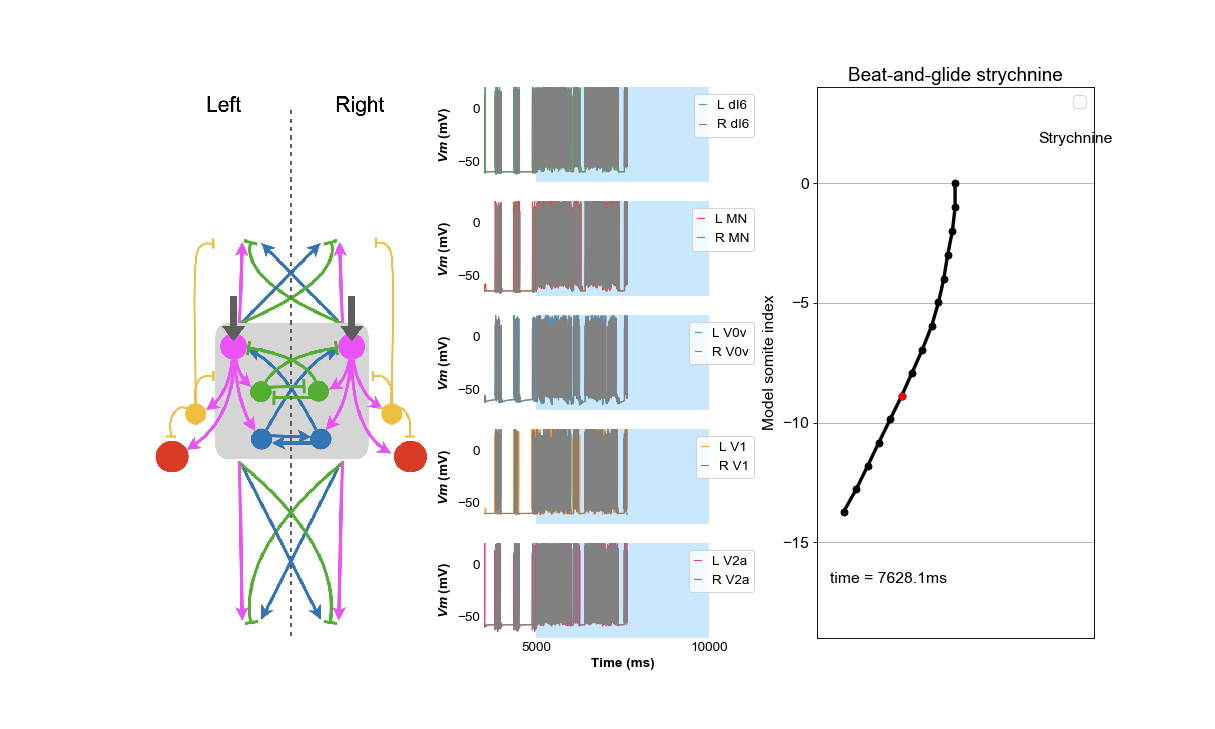

No handles with labels found to put in legend.


In [18]:
%matplotlib notebook
%matplotlib notebook
from Izhikevich_class import*
from Analysis_tools import *
import pandas as pd
import numpy as np
import matplotlib.image as mpimg

# line length and width
LINELENGTH = 0.5
LINEWIDTH = 1
plt.rc('lines', linewidth=LINEWIDTH) 

# Change default font to Arial
matplotlib.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"

rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.bf'] = 'Arial:italic:bold'

# font size
SMALLER_SIZE = 12
SMALL_SIZE = 12

FONT_STYLE = 'bold'

# y-axis limit
lower_y = -70
upper_y = 20

# color map
cmapGrey = matplotlib.cm.get_cmap('Greys')
cmapBlue = matplotlib.cm.get_cmap('Blues')
cmapRed = matplotlib.cm.get_cmap('Reds')
cmapGreen = matplotlib.cm.get_cmap('Greens')
cmapBrown = matplotlib.cm.get_cmap('YlOrBr')
cmapRedPurple = matplotlib.cm.get_cmap('RdPu')
cmapBrightGreen = matplotlib.cm.get_cmap('hsv')
cmapYellow = matplotlib.cm.get_cmap('YlOrBr')

# image for beat and glide diagram
img = mpimg.imread('Beat_and_glide_diagram.png')

# function that combines musculoskeletal model and cell firing
def multipanel_anim(Time,nMuscle,nmax, VRdI6, VLdI6, VRMN, VLMN, VRV0v, VLV0v, VRV1, VLV1, VRV2a, VLV2a, VRMuscle,VLMuscle,dt):

    #set figure including subplots 
    fig = plt.figure(figsize=(15, 9))
    
    fig_angles = fig.add_subplot(133)    
    fig_dI6 = fig.add_subplot(5,3,2)
    fig_MN = fig.add_subplot(5,3,5)
    fig_V0v = fig.add_subplot(5,3,8)
    fig_V1 = fig.add_subplot(5,3,11)
    fig_V2a = fig.add_subplot(5,3,14)
    
    fig_angles.set_title("Beat-and-glide strychnine")
    
    fig_diagram = fig.add_subplot(131)
    fig_diagram.imshow(img)
    fig_diagram.axis('off')
     
    LdI6_firing, = fig_dI6.plot([], [], lw=1, color = cmapGreen(0.6))
    RdI6_firing, = fig_dI6.plot([], [], lw=1, color = 'Grey')

    LMN_firing, = fig_MN.plot([], [], lw=1, color = cmapRed(0.6))
    RMN_firing, = fig_MN.plot([], [], lw=1, color = 'Grey')
 
    LV0v_firing, = fig_V0v.plot([], [], lw=1, color = cmapBlue(0.6))
    RV0v_firing, = fig_V0v.plot([], [], lw=1, color = 'Grey')

    LV1_firing, = fig_V1.plot([], [], lw=1, color = cmapYellow(0.5))
    RV1_firing, = fig_V1.plot([], [], lw=1, color = 'Grey')
    
    LV2a_firing, = fig_V2a.plot([], [], lw=1, color = cmapRedPurple(0.6))
    RV2a_firing, = fig_V2a.plot([], [], lw=1, color = 'Grey')
       
    Muscle_angles, = fig_angles.plot([], [], 'o-', lw=3, color = 'Black')
    Muscle_angles_highlight, = fig_angles.plot([], [], 'o-', lw=3, color = 'Red')
    
    # Allocating arrays for velocity and position
    vel = np.zeros((nMuscle, nmax))
    pos = np.zeros((nMuscle, nmax))
    
    # Setting constants and initial values for vel. and pos.
    khi = 3.0  #damping cste , high khi =0.5/ low = 0.1
    w0 = 2.5 #2.5  #20Hz = 125.6
    vel0 = 0.0
    pos0 = 0.0
    Wd = w0
    
    for k in range (0,nMuscle):
        vel[k,0] = vel0    #Sets the initial velocity
        pos[k,0] = pos0    #Sets the initial position
        pos[nMuscle-1,0] = 0.0
        for i in range(1,nmax):
        
            vel[k,i] = -(w0**2)*pos[k,i-1]*dt + vel[k,i-1]*(1-(2*dt*khi*w0)) + 0.1*VRMuscle[k,i-1]*dt - 0.1*VLMuscle[k,i-1]*dt
            pos[k,i] = dt*vel[k,i-1] + pos[k,i-1]
    
    ### DYNAMIC PLOTTING
    
    x = np.zeros((nMuscle,nmax))
    y = np.zeros((nMuscle,nmax))
    
    for i in range (0,nmax):
        x[0,i] = 0
        y[0,i] = 0
        pos[0,i] = 0
        for k in range (1,nMuscle):
            pos[k,i] = pos[k-1,i] + pos[k,i]
            
            x[k,i] = x[k-1,i] + np.sin(pos[k,i])
            y[k,i] = y[k-1,i] - np.cos(pos[k,i])
    #set limits for x and y-axis
    fig_angles.grid()
    fig_angles.set_ylim(-20, 5)
    fig_angles.set_xlim(-3, 3)
    fig_dI6.set_ylim(-80, 20)
    fig_dI6.set_xlim(0, nmax*dt)
    fig_MN.set_ylim(-80, 20)
    fig_MN.set_xlim(0, nmax*dt)
    fig_V0v.set_ylim(-80, 20)
    fig_V0v.set_xlim(0, nmax*dt)
    fig_V1.set_ylim(-80, 20)
    fig_V1.set_xlim(0, nmax*dt)
    fig_V2a.set_ylim(-80, 20)
    fig_V2a.set_xlim(0, nmax*dt)

    #time text
    time_template = 'time = %.1fms'
    time_text = fig_angles.text(0.05, 0.1, '', transform=fig_angles.transAxes)
    epoch_text = fig_angles.text(0.8, 0.9, '', transform=fig_angles.transAxes)
    fig_angles.legend()
    fig_angles.set_ylabel('Model somite index')
    fig_angles.set_ylim([-19, 4])
    fig_angles.set_xticks([])

    # set blue stripe at t=5000 to 10000
    fig_dI6.axvspan(5000, 10000, facecolor='xkcd:light blue', alpha=0.5)
    fig_MN.axvspan(5000, 10000, facecolor='xkcd:light blue', alpha=0.5)
    fig_V0v.axvspan(5000, 10000, facecolor='xkcd:light blue', alpha=0.5)
    fig_V1.axvspan(5000, 10000, facecolor='xkcd:light blue', alpha=0.5)
    fig_V2a.axvspan(5000, 10000, facecolor='xkcd:light blue', alpha=0.5)

    #legend for dI6 subplot
    leg=fig_dI6.legend(handles=[LdI6_firing, RdI6_firing], labels=['L dI6','R dI6'], loc='upper right', handlelength=LINELENGTH, fontsize=SMALLER_SIZE)
    leg.legendHandles[0].set_color(cmapGreen(0.6))
    leg.legendHandles[1].set_color('grey')
    for line in leg.get_lines():
        line.set_linewidth(LINEWIDTH)
        
    fig_dI6.set_ylabel(r"$\mathbf{Vm}$" + " (mV)", fontsize= SMALL_SIZE, fontweight=FONT_STYLE) #y-axis title
    fig_dI6.set_ylim([lower_y, upper_y]) #y-axis limt
    #remove borders
    fig_dI6.spines['top'].set_visible(False)
    fig_dI6.spines['right'].set_visible(False)
    fig_dI6.spines['bottom'].set_visible(False)
    fig_dI6.spines['left'].set_visible(False)
    #tick parameters
    fig_dI6.tick_params(axis='both', which='both', length=0)
    for item in ([fig_dI6.title, fig_dI6.xaxis.label, fig_dI6.yaxis.label] +
             fig_dI6.get_xticklabels() + fig_dI6.get_yticklabels()):
        item.set_fontsize(SMALL_SIZE)
    fig_dI6.set_yticks([i*50 + -50 for i in range(0,2)])
    fig_dI6.set_xticks([])
    fig_dI6.set_xlim([Time[0], Time[-1]])
    
    #settings for MN trace. Same as dI6
    leg=fig_MN.legend(handles=[LMN_firing, RMN_firing], labels=['L MN','R MN'], loc='upper right', handlelength=LINELENGTH, fontsize=SMALLER_SIZE)
    leg.legendHandles[0].set_color(cmapRed(0.6))
    leg.legendHandles[1].set_color('grey')
    for line in leg.get_lines():
        line.set_linewidth(LINEWIDTH)

    fig_MN.set_ylabel(r"$\mathbf{Vm}$" + " (mV)", fontsize= SMALL_SIZE, fontweight=FONT_STYLE)
    fig_MN.set_ylim([lower_y, upper_y])
    fig_MN.spines['top'].set_visible(False)
    fig_MN.spines['right'].set_visible(False)
    fig_MN.spines['bottom'].set_visible(False)
    fig_MN.spines['left'].set_visible(False)
    fig_MN.tick_params(axis='both', which='both', length=0)
    for item in ([fig_MN.title, fig_MN.xaxis.label, fig_MN.yaxis.label] +
             fig_MN.get_xticklabels() + fig_MN.get_yticklabels()):
        item.set_fontsize(SMALL_SIZE)
    fig_MN.set_yticks([i*50 + -50 for i in range(0,2)])
    fig_MN.set_xticks([])
    fig_MN.set_xlim([Time[0], Time[-1]])
    
    #settings for V0v trace. Same as dI6
    leg=fig_V0v.legend(handles=[LV0v_firing, RV0v_firing], labels=['L V0v','R V0v'], loc='upper right', handlelength=LINELENGTH, fontsize=SMALLER_SIZE)
    leg.legendHandles[0].set_color(cmapBlue(0.6))
    leg.legendHandles[1].set_color('grey')
    for line in leg.get_lines():
        line.set_linewidth(LINEWIDTH)

    fig_V0v.set_ylabel(r"$\mathbf{Vm}$" + " (mV)", fontsize= SMALL_SIZE, fontweight=FONT_STYLE)
    fig_V0v.set_ylim([lower_y, upper_y])
    fig_V0v.spines['top'].set_visible(False)
    fig_V0v.spines['right'].set_visible(False)
    fig_V0v.spines['bottom'].set_visible(False)
    fig_V0v.spines['left'].set_visible(False)
    fig_V0v.tick_params(axis='both', which='both', length=0)
    for item in ([fig_V0v.title, fig_V0v.xaxis.label, fig_V0v.yaxis.label] +
             fig_V0v.get_xticklabels() + fig_V0v.get_yticklabels()):
        item.set_fontsize(SMALL_SIZE)
    fig_V0v.set_yticks([i*50 + -50 for i in range(0,2)])
    fig_V0v.set_xticks([])
    fig_V0v.set_xlim([Time[0], Time[-1]])
    
    #settings for V1 trace. Same as dI6
    leg=fig_V1.legend(handles=[LV1_firing, RV1_firing], labels=['L V1','R V1'], loc='upper right', handlelength=LINELENGTH, fontsize=SMALLER_SIZE)
    leg.legendHandles[0].set_color(cmapYellow(0.5))
    leg.legendHandles[1].set_color('grey')
    for line in leg.get_lines():
        line.set_linewidth(LINEWIDTH)

    fig_V1.set_ylabel(r"$\mathbf{Vm}$" + " (mV)", fontsize= SMALL_SIZE, fontweight=FONT_STYLE)
    fig_V1.set_ylim([lower_y, upper_y])
    fig_V1.spines['top'].set_visible(False)
    fig_V1.spines['right'].set_visible(False)
    fig_V1.spines['bottom'].set_visible(False)
    fig_V1.spines['left'].set_visible(False)
    fig_V1.tick_params(axis='both', which='both', length=0)
    for item in ([fig_V1.title, fig_V1.xaxis.label, fig_V1.yaxis.label] +
             fig_V1.get_xticklabels() + fig_V1.get_yticklabels()):
        item.set_fontsize(SMALL_SIZE)
    fig_V1.set_yticks([i*50 + -50 for i in range(0,2)])
    fig_V1.set_xticks([])
    fig_V1.set_xlim([Time[0], Time[-1]])
    
    #settings for V2a trace. Same as dI6
    leg=fig_V2a.legend(handles=[LV2a_firing, RV2a_firing], labels=['L V2a','R V2a'], loc='upper right', handlelength=LINELENGTH, fontsize=SMALLER_SIZE)
    leg.legendHandles[0].set_color(cmapRedPurple(0.6))
    leg.legendHandles[1].set_color('grey')
    for line in leg.get_lines():
        line.set_linewidth(LINEWIDTH)

    fig_V2a.set_ylabel(r"$\mathbf{Vm}$" + " (mV)", fontsize= SMALL_SIZE, fontweight=FONT_STYLE)
    fig_V2a.set_ylim([lower_y, upper_y])
    fig_V2a.spines['top'].set_visible(False)
    fig_V2a.spines['right'].set_visible(False)
    fig_V2a.spines['bottom'].set_visible(False)
    fig_V2a.spines['left'].set_visible(False)
    fig_V2a.tick_params(axis='both', which='both', length=0)
    for item in ([fig_V2a.title, fig_V2a.xaxis.label, fig_V2a.yaxis.label] +
             fig_V2a.get_xticklabels() + fig_V2a.get_yticklabels()):
        item.set_fontsize(SMALL_SIZE)
    fig_V2a.set_yticks([i*50 + -50 for i in range(0,2)])
    fig_V2a.set_xticks([i*5000 for i in range(0,20)])
    fig_V2a.set_xlabel('Time (ms)', fontsize= SMALL_SIZE, fontweight='bold')
    fig_V2a.set_xlim([Time[0], Time[-1]])
    
    def init():
        Muscle_angles.set_data([], [])
        LdI6_firing.set_data([], [])
        RdI6_firing.set_data([], [])
        LMN_firing.set_data([], [])
        RMN_firing.set_data([], [])
        LV0v_firing.set_data([], [])
        RV0v_firing.set_data([], [])
        LV1_firing.set_data([], [])
        RV1_firing.set_data([], [])
        LV2a_firing.set_data([], [])
        RV2a_firing.set_data([], [])
        time_text.set_text('')
        epoch_text.set_text('')
        return Muscle_angles, LdI6_firing, RdI6_firing, LMN_firing, RMN_firing, LV0v_firing, RV0v_firing, LV1_firing, RV1_firing, LV2a_firing, RV2a_firing,  time_text, epoch_text
    
    #This function drives the animation by updating every time point
    def animate(i):
        
        thisx = [x[k,i] for k in range(nMuscle)]
        thisy = [y[k,i] for k in range(nMuscle)]
        
        Muscle_angles.set_data(thisx, thisy)
        Muscle_angles_highlight.set_data(x[9,i], y[9,i])
        
        time_text.set_text(time_template % (Time[i]))

        LdI6_firing.set_data(Time[0:i], VLdI6[9, 0:i])
        RdI6_firing.set_data(Time[0:i], VRdI6[9, 0:i])

        LMN_firing.set_data(Time[0:i], VLMN[9, 0:i])
        RMN_firing.set_data(Time[0:i], VRMN[9, 0:i])
        
        LV0v_firing.set_data(Time[0:i], VLV0v[9, 0:i])
        RV0v_firing.set_data(Time[0:i], VRV0v[9, 0:i])

        LV1_firing.set_data(Time[0:i], VLV1[9, 0:i])
        RV1_firing.set_data(Time[0:i], VRV1[9, 0:i])

        LV2a_firing.set_data(Time[0:i], VLV2a[9, 0:i])
        RV2a_firing.set_data(Time[0:i], VRV2a[9, 0:i])
        
        if Time[i] < 5000 or Time[i] > 10000:
            epoch_text.set_text("Control")
        elif 5000 < Time[i] < 10000:
            epoch_text.set_text("Strychnine")
        
        return Muscle_angles, LdI6_firing, RdI6_firing, LMN_firing, RMN_firing, LV0v_firing, RV0v_firing, LV1_firing, RV1_firing, LV2a_firing, RV2a_firing,  time_text, epoch_text
     
    ani = animation.FuncAnimation(fig, animate, np.arange(1, len(Time), 10), #animation.FuncAnimation(fig, animate, np.arange(1, len(Time), 10), for faster animation
                                  interval=10, blit=False, init_func=init)
    
    plt.show()
    return ani

### NOW PLOTTING NEURON ACTIVITY DURING SWIMMING SIMULATION ###
# This file was used to make the figure for all of the neuron traces during a typical double coil
read_data = pd.read_csv("Beat_and_Glide_strychnine.csv")

data_top = list(read_data.columns.values.tolist())
data_top

MN_index = []
dI6_index = [] 
V0v_index = []  
V2a_index = [] 
V1_index = []
Muscle_index = []

for i in range(0, len(data_top)):
    if (data_top[i].find('MN') != -1):
        MN_index.append(int(data_top[i][data_top[i].find('MN')+2:data_top[i].find('MN')+4]))
        nMN = max(MN_index) + 1
    if (data_top[i].find('dI6') != -1):
        dI6_index.append(int(data_top[i][data_top[i].find('dI6')+3:data_top[i].find('dI6')+5]))
        ndI6 = max(dI6_index) + 1
    if (data_top[i].find('V0v') != -1):
        V0v_index.append(int(data_top[i][data_top[i].find('V0v')+3:data_top[i].find('V0v')+5]))
        nV0v = max(V0v_index) + 1
    if (data_top[i].find('V2a') != -1):
        V2a_index.append(int(data_top[i][data_top[i].find('V2a')+3:data_top[i].find('V2a')+5]))
        nV2a = max(V2a_index) + 1
    if (data_top[i].find('V1') != -1):
        V1_index.append(int(data_top[i][data_top[i].find('V1')+2:data_top[i].find('V1')+4]))
        nV1 = max(V1_index) + 1
    if (data_top[i].find('Muscle') != -1):
        Muscle_index.append(int(data_top[i][data_top[i].find('Muscle')+6:data_top[i].find('Muscle')+8]))
        nMuscle = max(Muscle_index) + 1
        
read_sim = np.ascontiguousarray(read_data)
read_sim = np.transpose(read_sim)
read_sim
Time = read_sim[0]
next_start = 1
next_end = next_start + nMN
VLMN = read_sim[1:next_end]
next_start = next_end
next_end = next_start + nMN
VRMN = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + ndI6
VLdI6 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + ndI6
VRdI6 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV0v
VLV0v = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV0v
VRV0v = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV2a
VLV2a = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV2a
VRV2a = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV1
VLV1 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nV1
VRV1 = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nMuscle
VLMuscle = read_sim[next_start:next_end]
next_start = next_end
next_end = next_start + nMuscle
VRMuscle = read_sim[next_start:next_end]
TIME_END = Time[-1]
TIME_END

# x range for coiling simulation

mywriter = animation.FFMpegWriter()
nMuscle = 15
dt = 0.1
tstart = 3500
tend = 11500
start = int(tstart/dt)
end = int(tend/dt)
nmax = int((tend-tstart)/dt)
ani = multipanel_anim(Time[start:end],nMuscle,nmax, VRdI6[:,start:end], VLdI6[:,start:end], VRMN[:,start:end], VLMN[:,start:end], 
                      VRV0v[:,start:end], VLV0v[:,start:end], VRV1[:,start:end], VLV1[:,start:end], VRV2a[:,start:end], 
                      VLV2a[:,start:end], VRMuscle[:,start:end],VLMuscle[:,start:end],dt)

In [ ]:
ani.save("Figure 7 - video 1.mp4")#, fps=30)#, extra_args=['-vcodec', 'libx264'])

Stats for base model

In [ ]:
# Import pandas for data saving
import pandas as pd
import numpy as np
import json
import csv
import scipy.stats as stats
from pylab import *
from Analysis_tools import *
import seaborn as sns

%matplotlib inline

SMALL_SIZE = 10
FONT_STYLE = 'bold'
# Change default font to Arial
matplotlib.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"

dt = 0.1

cmapGrey = matplotlib.cm.get_cmap('Greys')
cmapBlue = matplotlib.cm.get_cmap('Blues')
cmapRed = matplotlib.cm.get_cmap('Reds')
cmapGreen = matplotlib.cm.get_cmap('Greens')
cmapBrown = matplotlib.cm.get_cmap('YlOrBr')
cmapRedPurple = matplotlib.cm.get_cmap('RdPu')
cmapBrightGreen = matplotlib.cm.get_cmap('hsv')

LINELENGTH = 0.5
LINEWIDTH = 1

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

MARKER_SIZE = 3

FONT_STYLE = 'bold'

#fig, axes = plt.subplots(4, 1, figsize=(3.5, 8))

fig, axes = plt.subplots(4, 1, figsize=(2.5, 8))

file_names = ['./JSONs/Analysis_Beat_and_Glide_base_0pt00_0.json',
              './JSONs/Analysis_Beat_and_Glide_base_0pt00_0.json',
              './JSONs/Analysis_Beat_and_Glide_base_0pt00_2.json',
              './JSONs/Analysis_Beat_and_Glide_base_0pt00_3.json',
              './JSONs/Analysis_Beat_and_Glide_base_0pt00_4.json',
              './JSONs/Analysis_Beat_and_Glide_base_0pt00_5.json',
              './JSONs/Analysis_Beat_and_Glide_base_0pt00_6.json',
              './JSONs/Analysis_Beat_and_Glide_base_0pt00_7.json',
              './JSONs/Analysis_Beat_and_Glide_base_0pt00_8.json',
              './JSONs/Analysis_Beat_and_Glide_base_0pt00_9.json']
'''
'./JSONs/Analysis_Beat_and_Glide_SigmaD_0pt10_0.json',
              './JSONs/Analysis_Beat_and_Glide_SigmaD_0pt10_1.json',
              './JSONs/Analysis_Beat_and_Glide_SigmaD_0pt10_2.json',
              './JSONs/Analysis_Beat_and_Glide_SigmaD_0pt10_3.json',
              './JSONs/Analysis_Beat_and_Glide_SigmaD_0pt10_4.json',
              './JSONs/Analysis_Beat_and_Glide_SigmaD_0pt10_5.json',
              './JSONs/Analysis_Beat_and_Glide_SigmaD_0pt10_6.json',
              './JSONs/Analysis_Beat_and_Glide_SigmaD_0pt10_7.json',
              './JSONs/Analysis_Beat_and_Glide_SigmaD_0pt10_8.json',
              './JSONs/Analysis_Beat_and_Glide_SigmaD_0pt10_9.json',
              './JSONs/Analysis_Beat_and_Glide_SigmaD_0pt20_0.json',
              './JSONs/Analysis_Beat_and_Glide_SigmaD_0pt20_1.json',
              './JSONs/Analysis_Beat_and_Glide_SigmaD_0pt20_2.json',
              './JSONs/Analysis_Beat_and_Glide_SigmaD_0pt20_3.json',
              './JSONs/Analysis_Beat_and_Glide_SigmaD_0pt20_4.json',
              './JSONs/Analysis_Beat_and_Glide_SigmaD_0pt20_5.json',
              './JSONs/Analysis_Beat_and_Glide_SigmaD_0pt20_6.json',
              './JSONs/Analysis_Beat_and_Glide_SigmaD_0pt20_7.json',
              './JSONs/Analysis_Beat_and_Glide_SigmaD_0pt20_8.json',
              './JSONs/Analysis_Beat_and_Glide_SigmaD_0pt20_9.json',
              './JSONs/Analysis_Beat_and_Glide_SigmaD_0pt30_0.json',
              './JSONs/Analysis_Beat_and_Glide_SigmaD_0pt30_1.json',
              './JSONs/Analysis_Beat_and_Glide_SigmaD_0pt30_2.json',
              './JSONs/Analysis_Beat_and_Glide_SigmaD_0pt30_3.json',
              './JSONs/Analysis_Beat_and_Glide_SigmaD_0pt30_4.json',
              './JSONs/Analysis_Beat_and_Glide_SigmaD_0pt30_5.json',
              './JSONs/Analysis_Beat_and_Glide_SigmaD_0pt30_6.json',
              './JSONs/Analysis_Beat_and_Glide_SigmaD_0pt30_7.json',
              './JSONs/Analysis_Beat_and_Glide_SigmaD_0pt30_8.json',
              './JSONs/Analysis_Beat_and_Glide_SigmaD_0pt30_9.json',
              './JSONs/Analysis_Beat_and_Glide_SigmaD_0pt40_0.json',
              './JSONs/Analysis_Beat_and_Glide_SigmaD_0pt40_1.json',
              './JSONs/Analysis_Beat_and_Glide_SigmaD_0pt40_2.json',
              './JSONs/Analysis_Beat_and_Glide_SigmaD_0pt40_3.json',
              './JSONs/Analysis_Beat_and_Glide_SigmaD_0pt40_4.json',
              './JSONs/Analysis_Beat_and_Glide_SigmaD_0pt40_5.json',
              './JSONs/Analysis_Beat_and_Glide_SigmaD_0pt40_6.json',
              './JSONs/Analysis_Beat_and_Glide_SigmaD_0pt40_7.json',
              './JSONs/Analysis_Beat_and_Glide_SigmaD_0pt40_8.json',
              './JSONs/Analysis_Beat_and_Glide_SigmaD_0pt40_9.json',
              './JSONs/Analysis_Beat_and_Glide_SigmaD_0pt50_0.json',
              './JSONs/Analysis_Beat_and_Glide_SigmaD_0pt50_1.json',
              './JSONs/Analysis_Beat_and_Glide_SigmaD_0pt50_2.json',
              './JSONs/Analysis_Beat_and_Glide_SigmaD_0pt50_3.json',
              './JSONs/Analysis_Beat_and_Glide_SigmaD_0pt50_4.json',
              './JSONs/Analysis_Beat_and_Glide_SigmaD_0pt50_5.json',
              './JSONs/Analysis_Beat_and_Glide_SigmaD_0pt50_6.json',
              './JSONs/Analysis_Beat_and_Glide_SigmaD_0pt50_7.json',
              './JSONs/Analysis_Beat_and_Glide_SigmaD_0pt50_8.json',
              './JSONs/Analysis_Beat_and_Glide_SigmaD_0pt50_9.json']
'''
somite_index = 9
i = 0

durations_dict=dict()
inter_events_dict = dict()
tail_beat_delays_dict = dict()
LR_mins_dict = dict()
all_weights=[]

durations_df = pd.DataFrame(columns = ["Durations", "Weight", "Sim_index"])
inter_events_df = pd.DataFrame(columns = ["Inter_events", "Weight", "Sim_index"])
tail_beat_delays_df = pd.DataFrame(columns = ["Tail_beat_delays", "Weight", "Sim_index"])
LR_mins_df = pd.DataFrame(columns = ["LR_mins", "Weight", "Sim_index"])

for names in file_names:
    
    i=i+1
    
    f = open(names,)
    results = json.load(f)

    sim_index = names[names.find('.j')-1:names.find('.j')]
    
    all_durations = results['Events']['Duration (ms)']
    
    all_inter_events = results['Events']['Inter-event intervals']
    
    all_tail_beat_delays = results['Tail beat delay']['Computed tail beat time delay (ms)']
    
    all_LR_mins = results['Left/Right Xcorr min delay']['Computed L/R min']
    
    weight_str = names[names.find('pt')-1:names.find('pt')+4]
    weight = int(weight_str[0]) + int(weight_str[3:5])/100
        
    if weight not in all_weights:
        all_weights.append(weight)
        durations_dict[str(weight)] = []
        inter_events_dict[str(weight)] = []
        tail_beat_delays_dict[str(weight)] = []
        LR_mins_dict[str(weight)] = []

    tail_beat_delays_to_add = all_tail_beat_delays[somite_index]
    LR_mins_to_add = all_LR_mins[somite_index]
    
    durations_dict[str(weight)].extend(all_durations[1:])
    inter_events_dict[str(weight)].extend(all_inter_events)
    tail_beat_delays_dict[str(weight)].append(tail_beat_delays_to_add)
    if LR_mins_to_add < 1.1:
        LR_mins_dict[str(weight)].append(LR_mins_to_add)
    
    temp_durations = list(zip(all_durations[1:], [weight for i in range(1, len(all_durations))], [sim_index for i in range(1, len(all_durations))]))
    temp_durations_df = pd.DataFrame(temp_durations, columns = ["Durations", "Weight", "Sim_index"]) 
    durations_df = durations_df.append(temp_durations_df)    
        
    temp_inter_events = list(zip(all_inter_events, [weight for i in range(0, len(all_inter_events))], [sim_index for i in range(0, len(all_inter_events))]))
    temp_inter_events_df = pd.DataFrame(temp_inter_events, columns = ["Inter_events", "Weight", "Sim_index"]) 
    inter_events_df = inter_events_df.append(temp_inter_events_df)  

    temp_tail_beat_delays = list(zip([tail_beat_delays_to_add], [weight] , [sim_index]))
    temp_tail_beat_delays_df = pd.DataFrame(temp_tail_beat_delays, columns = ["Tail_beat_delays", "Weight", "Sim_index"]) 
    tail_beat_delays_df = tail_beat_delays_df.append(temp_tail_beat_delays_df)    

    if LR_mins_to_add < 1.1:
        temp_LR_mins = list(zip([LR_mins_to_add], [weight], [sim_index]))
        temp_LR_mins_df = pd.DataFrame(temp_LR_mins, columns = ["LR_mins", "Weight", "Sim_index"]) 
        LR_mins_df = LR_mins_df.append(temp_LR_mins_df)    

sns.swarmplot(ax=axes[0], x="Weight", y="Durations", data=durations_df, hue = "Sim_index", size = MARKER_SIZE-1, alpha = 0.7)
sns.swarmplot(ax=axes[1], x="Weight", y="Inter_events", data=inter_events_df, hue = "Sim_index", size = MARKER_SIZE-1, alpha = 0.7)
sns.swarmplot(ax=axes[2], x="Weight", y="Tail_beat_delays", data=tail_beat_delays_df, hue = "Sim_index", size = MARKER_SIZE, alpha = 1)
sns.swarmplot(ax=axes[3], x="Weight", y="LR_mins", data=LR_mins_df, hue = "Sim_index", size = MARKER_SIZE, alpha = 1)

WIDTH = 0.7
COLOR = '0.8'
LINEWIDTH = 1

PROPS = {
    'boxprops':{'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}

sns.boxplot(ax=axes[0], x="Weight", y="Durations", data=durations_df, width = WIDTH, linewidth = LINEWIDTH, color=COLOR, showfliers = False, **PROPS)
sns.boxplot(ax=axes[1], x="Weight", y="Inter_events", data=inter_events_df, width = WIDTH, linewidth = LINEWIDTH, color=COLOR, showfliers = False, **PROPS)
sns.boxplot(ax=axes[2], x="Weight", y="Tail_beat_delays", data=tail_beat_delays_df, width = WIDTH, linewidth = LINEWIDTH, color=COLOR, showfliers = False, **PROPS)
sns.boxplot(ax=axes[3], x="Weight", y="LR_mins", data=LR_mins_df, width = WIDTH, color=COLOR, linewidth = LINEWIDTH, showfliers = False, **PROPS)

#axes[0].axhspan(160., 200, facecolor='xkcd:light blue', alpha=0.5)
#axes[1].axhspan(360, 420, facecolor='xkcd:light blue', alpha=0.5)
#axes[2].axhspan(27, 30.3, facecolor='xkcd:light blue', alpha=0.5)
#axes[3].axhspan(0.19414659927532016, 0.2321524787383282, facecolor='xkcd:light blue', alpha=0.5)


axes[3].set_ylim(0, 1)

for ax in axes:
    ax.set_ylabel("")
    ax.legend([],[], frameon=False)
    for item in (ax.get_xticklabels() + ax.get_yticklabels()): 
        item.set_fontsize(SMALL_SIZE)
    ax.set_xlabel('')
        
plt.tight_layout()

plt.savefig("SigmaD.png", dpi=1000)

plt.show()

# STATISTICAL TESTING

df_durations=[]
df_inter_events=[]
df_tail_beat_delays=[]
df_LR_mins=[]


dfs_durations = 0
dfs_inter_events=0
dfs_tail_beat_delays = 0
dfs_LR_mins = 0

for i in all_weights:
    df_durations.append(durations_dict[str(i)])
    df_inter_events.append(inter_events_dict[str(i)])
    df_tail_beat_delays.append(tail_beat_delays_dict[str(i)])
    df_LR_mins.append(LR_mins_dict[str(i)])

    
#test durations
print("DURATIONS")
print(stats.f_oneway(*df_durations))

for i in range(0, len(all_weights)):
    dfs_durations = dfs_durations + sum(len(df_durations[i]))

dfs_durations = dfs_durations - len(df_durations)
print("dfs_durations =" + str(dfs_durations))

print("EPISODE DURATIONS T-TESTS")
for i in range (0, len(all_weights)):
    for j in range (i+1, len(all_weights)):
        print("Durations t-test between weight " + str(all_weights[i]) + " and weight " + str(all_weights[j]) + ": "
              + str(stats.ttest_ind(durations_dict[str(all_weights[i])], durations_dict[str(all_weights[j])])))

print("\n")        

print("INTER-EPISODE INTERVALS")
print(stats.f_oneway(*df_inter_events))

for i in range(0, len(all_weights)):
    dfs_inter_events = dfs_inter_events + sum(len(df_inter_events[i]))

dfs_inter_events = dfs_inter_events - len(df_inter_events)

print("dfs_inter_events =" + str(dfs_inter_events))

print("INTER-EPISODE INTERVALS T-TESTS")
for i in range (0, len(all_weights)):
    for j in range (i+1, len(all_weights)):
        print("inter_events t-test between weight " + str(all_weights[i]) + " and weight " + str(all_weights[j]) + ": "
              + str(stats.ttest_ind(inter_events_dict[str(all_weights[i])], inter_events_dict[str(all_weights[j])])))
print("\n")
        
print("TIME DELAY AT PEAK AUTOCORRELATION")
print(stats.f_oneway(*df_tail_beat_delays))

for i in range(0, len(all_weights)):
    dfs_tail_beat_delays = dfs_tail_beat_delays + sum(len(df_tail_beat_delays[i]))

dfs_tail_beat_delays = dfs_tail_beat_delays - len(df_tail_beat_delays)

print("dfs_tail_beat_delays =" + str(dfs_tail_beat_delays))

print("TIME DELAY T-TESTS")
for i in range (0, len(all_weights)):
    for j in range (i+1, len(all_weights)):
        print("tail_beat_delays t-test between weight " + str(all_weights[i]) + " and weight " + str(all_weights[j]) + ": "
              + str(stats.ttest_ind(tail_beat_delays_dict[str(all_weights[i])], tail_beat_delays_dict[str(all_weights[j])])))

print("\n")
        
print("MINIMUM OF LEFT-RIGHT CROSS-CORRELATION")
print(stats.f_oneway(*df_LR_mins))

for i in range(0, len(all_weights)):
    dfs_LR_mins = dfs_LR_mins + sum(len(df_LR_mins[i]))

dfs_LR_mins = dfs_LR_mins - len(df_LR_mins)

print("dfs_LR_mins =" + str(dfs_LR_mins))

print("MINIMUM OF LEFT-RIGHT CROSS-CORRELATION T-TESTS")
for i in range (0, len(all_weights)):
    for j in range (i+1, len(all_weights)):
        print("LR_mins t-test between weight " + str(all_weights[i]) + " and weight " + str(all_weights[j]) + ": "
              + str(stats.ttest_ind(LR_mins_dict[str(all_weights[i])], LR_mins_dict[str(all_weights[j])])))

'''
DURATIONS
F_onewayResult(statistic=19.539134267053612, pvalue=9.154061736410102e-19)
dfs_durations =1228
EPISODE DURATIONS T-TESTS
Durations t-test between weight 0.0 and weight 0.5: Ttest_indResult(statistic=-2.027584226862336, pvalue=0.043179940105583646)
Durations t-test between weight 0.0 and weight 1.0: Ttest_indResult(statistic=-2.1024128017089656, pvalue=0.03605651982174204)
Durations t-test between weight 0.0 and weight 1.5: Ttest_indResult(statistic=-5.161363188365396, pvalue=3.749808391409854e-07)
Durations t-test between weight 0.0 and weight 2.0: Ttest_indResult(statistic=-7.089891368095936, pvalue=5.9114850740917305e-12)
Durations t-test between weight 0.0 and weight 2.5: Ttest_indResult(statistic=-7.181439652861466, pvalue=3.328771150168936e-12)
Durations t-test between weight 0.5 and weight 1.0: Ttest_indResult(statistic=-0.21302290451542186, pvalue=0.8314051399234623)
Durations t-test between weight 0.5 and weight 1.5: Ttest_indResult(statistic=-3.4541464996070315, pvalue=0.0006081580274333319)
Durations t-test between weight 0.5 and weight 2.0: Ttest_indResult(statistic=-5.482825900073676, pvalue=7.43969837370177e-08)
Durations t-test between weight 0.5 and weight 2.5: Ttest_indResult(statistic=-5.700878014790139, pvalue=2.3400681834783514e-08)
Durations t-test between weight 1.0 and weight 1.5: Ttest_indResult(statistic=-3.1578069753392097, pvalue=0.001703218706618627)
Durations t-test between weight 1.0 and weight 2.0: Ttest_indResult(statistic=-5.168996704798965, pvalue=3.712647963081765e-07)
Durations t-test between weight 1.0 and weight 2.5: Ttest_indResult(statistic=-5.419479746746443, pvalue=1.0377780679621637e-07)
Durations t-test between weight 1.5 and weight 2.0: Ttest_indResult(statistic=-2.0355570425297196, pvalue=0.04250500866580002)
Durations t-test between weight 1.5 and weight 2.5: Ttest_indResult(statistic=-2.4487591588704434, pvalue=0.014803362937569734)
Durations t-test between weight 2.0 and weight 2.5: Ttest_indResult(statistic=-0.4905559203060811, pvalue=0.6240524211285967)


INTER-EPISODE INTERVALS
F_onewayResult(statistic=38.53694637488762, pvalue=7.932314368100942e-37)
dfs_inter_events =1228
INTER-EPISODE INTERVALS T-TESTS
inter_events t-test between weight 0.0 and weight 0.5: Ttest_indResult(statistic=1.9251704798243174, pvalue=0.0548256184549551)
inter_events t-test between weight 0.0 and weight 1.0: Ttest_indResult(statistic=5.261738600401003, pvalue=2.1864525859976253e-07)
inter_events t-test between weight 0.0 and weight 1.5: Ttest_indResult(statistic=7.649611902357604, pvalue=1.3291519942701017e-13)
inter_events t-test between weight 0.0 and weight 2.0: Ttest_indResult(statistic=10.934880056379644, pvalue=1.3521306102150351e-24)
inter_events t-test between weight 0.0 and weight 2.5: Ttest_indResult(statistic=11.92010577832315, pvalue=2.7581400918617543e-28)
inter_events t-test between weight 0.5 and weight 1.0: Ttest_indResult(statistic=2.965683809942117, pvalue=0.003180027840230547)
inter_events t-test between weight 0.5 and weight 1.5: Ttest_indResult(statistic=5.0853422295415065, pvalue=5.539892120505885e-07)
inter_events t-test between weight 0.5 and weight 2.0: Ttest_indResult(statistic=7.805904155571942, pvalue=5.2476902218539143e-14)
inter_events t-test between weight 0.5 and weight 2.5: Ttest_indResult(statistic=8.694965948269527, pvalue=9.48097958933474e-17)
inter_events t-test between weight 1.0 and weight 1.5: Ttest_indResult(statistic=2.2385951535694915, pvalue=0.02570046175680222)
inter_events t-test between weight 1.0 and weight 2.0: Ttest_indResult(statistic=4.986715732919581, pvalue=9.143623637139873e-07)
inter_events t-test between weight 1.0 and weight 2.5: Ttest_indResult(statistic=5.95313515652089, pvalue=5.779669234927344e-09)
inter_events t-test between weight 1.5 and weight 2.0: Ttest_indResult(statistic=2.7053442380028834, pvalue=0.007138096360828461)
inter_events t-test between weight 1.5 and weight 2.5: Ttest_indResult(statistic=3.717174042805801, pvalue=0.0002329745813472534)
inter_events t-test between weight 2.0 and weight 2.5: Ttest_indResult(statistic=1.1363924290081875, pvalue=0.256581096994499)


TIME DELAY AT PEAK AUTOCORRELATION
F_onewayResult(statistic=1.1725577318138882, pvalue=0.3346859557039651)
dfs_tail_beat_delays =54
TIME DELAY T-TESTS
tail_beat_delays t-test between weight 0.0 and weight 0.5: Ttest_indResult(statistic=1.2252102631571635, pvalue=0.236287296176316)
tail_beat_delays t-test between weight 0.0 and weight 1.0: Ttest_indResult(statistic=1.2222576180933118, pvalue=0.23737473881350996)
tail_beat_delays t-test between weight 0.0 and weight 1.5: Ttest_indResult(statistic=-0.4116344401286661, pvalue=0.6854674560597771)
tail_beat_delays t-test between weight 0.0 and weight 2.0: Ttest_indResult(statistic=-0.3099265422741717, pvalue=0.7601763079159567)
tail_beat_delays t-test between weight 0.0 and weight 2.5: Ttest_indResult(statistic=0.05182727112687321, pvalue=0.9592371584991313)
tail_beat_delays t-test between weight 0.5 and weight 1.0: Ttest_indResult(statistic=-0.09162470910880464, pvalue=0.9280082141460542)
tail_beat_delays t-test between weight 0.5 and weight 1.5: Ttest_indResult(statistic=-1.8267910712692548, pvalue=0.0843622269661975)
tail_beat_delays t-test between weight 0.5 and weight 2.0: Ttest_indResult(statistic=-1.5308567819048913, pvalue=0.14319035364208832)
tail_beat_delays t-test between weight 0.5 and weight 2.5: Ttest_indResult(statistic=-1.3247508261619836, pvalue=0.20182726871867526)
tail_beat_delays t-test between weight 1.0 and weight 1.5: Ttest_indResult(statistic=-1.8842463505518525, pvalue=0.07578686353736816)
tail_beat_delays t-test between weight 1.0 and weight 2.0: Ttest_indResult(statistic=-1.5445180056836256, pvalue=0.139862247853909)
tail_beat_delays t-test between weight 1.0 and weight 2.5: Ttest_indResult(statistic=-1.342185320427387, pvalue=0.19622127005279907)
tail_beat_delays t-test between weight 1.5 and weight 2.0: Ttest_indResult(statistic=0.06269787586956216, pvalue=0.9506980756525734)
tail_beat_delays t-test between weight 1.5 and weight 2.5: Ttest_indResult(statistic=0.5236182849332951, pvalue=0.6069313946910588)
tail_beat_delays t-test between weight 2.0 and weight 2.5: Ttest_indResult(statistic=0.3914029098572637, pvalue=0.7000941257483225)


MINIMUM OF LEFT-RIGHT CROSS-CORRELATION
F_onewayResult(statistic=0.7683402600573751, pvalue=0.576697776701687)
dfs_LR_mins =54
MINIMUM OF LEFT-RIGHT CROSS-CORRELATION T-TESTS
LR_mins t-test between weight 0.0 and weight 0.5: Ttest_indResult(statistic=0.7560326174925416, pvalue=0.4594104011670319)
LR_mins t-test between weight 0.0 and weight 1.0: Ttest_indResult(statistic=1.0270960367437856, pvalue=0.3179806335859302)
LR_mins t-test between weight 0.0 and weight 1.5: Ttest_indResult(statistic=1.506907207812503, pvalue=0.1491837916849093)
LR_mins t-test between weight 0.0 and weight 2.0: Ttest_indResult(statistic=1.6008056480891826, pvalue=0.1268240572084769)
LR_mins t-test between weight 0.0 and weight 2.5: Ttest_indResult(statistic=1.6288155962238582, pvalue=0.12072769227636532)
LR_mins t-test between weight 0.5 and weight 1.0: Ttest_indResult(statistic=0.13412975831233084, pvalue=0.8947883056919368)
LR_mins t-test between weight 0.5 and weight 1.5: Ttest_indResult(statistic=0.5228659288960747, pvalue=0.607444318952617)
LR_mins t-test between weight 0.5 and weight 2.0: Ttest_indResult(statistic=0.6257501089117885, pvalue=0.5393328759411093)
LR_mins t-test between weight 0.5 and weight 2.5: Ttest_indResult(statistic=0.7617978490050019, pvalue=0.4560469797489224)
LR_mins t-test between weight 1.0 and weight 1.5: Ttest_indResult(statistic=0.45696326390980596, pvalue=0.6531641067974627)
LR_mins t-test between weight 1.0 and weight 2.0: Ttest_indResult(statistic=0.5781661109304357, pvalue=0.5703154076973531)
LR_mins t-test between weight 1.0 and weight 2.5: Ttest_indResult(statistic=0.7285042375497818, pvalue=0.4756769049598669)
LR_mins t-test between weight 1.5 and weight 2.0: Ttest_indResult(statistic=0.13854348875523578, pvalue=0.8913490978146343)
LR_mins t-test between weight 1.5 and weight 2.5: Ttest_indResult(statistic=0.3516919624113457, pvalue=0.7291527559165203)
LR_mins t-test between weight 2.0 and weight 2.5: Ttest_indResult(statistic=0.2279323856839273, pvalue=0.8222679328298665)
'''
